In [1]:
import os
import math
import uproot
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Initial photons tracks

In [2]:
old_file = "/lfs/l1/legend/users/cbarton/simulations/campaigns/opticalmap/4-innermap-wlsr-Feb2024/output/InnerMapMoreInfo.root"
new_file = "/lfs/l1/legend/users/cbarton/simulations/campaigns/opticalmap/16-innermap-7mcryo-smallmoderator-Oct2024/output/rawdata1Mallinfo.root"
corrected_file = "/lfs/l1/legend/users/cbarton/simulations/campaigns/opticalmap/16-innermap-7mcryo-smallmoderator-Oct2024/output/NEWrawdata1Mallinfo.root"

In [3]:
files = {"old_file" : old_file, "new_file" : new_file, "corrected_file" : corrected_file}

In [5]:
units = {"X" : "[mm]", "Y" : "[mm]", "Z" : "[mm]", "Time" : "[?]", "KineticEnergy" : "[eV]", "Wavelength" : "[nm]", "TrackID" : "", "EventID" : "",
         "CreatorProcess" : "", "Volume" : "", "px" : "", "py" : "", "pz" : ""}

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.65it/s]
/user/.local/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/user/.local/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/user/.local/lib/python3.7/site-packages/ipykernel_launcher.py:15: Runti

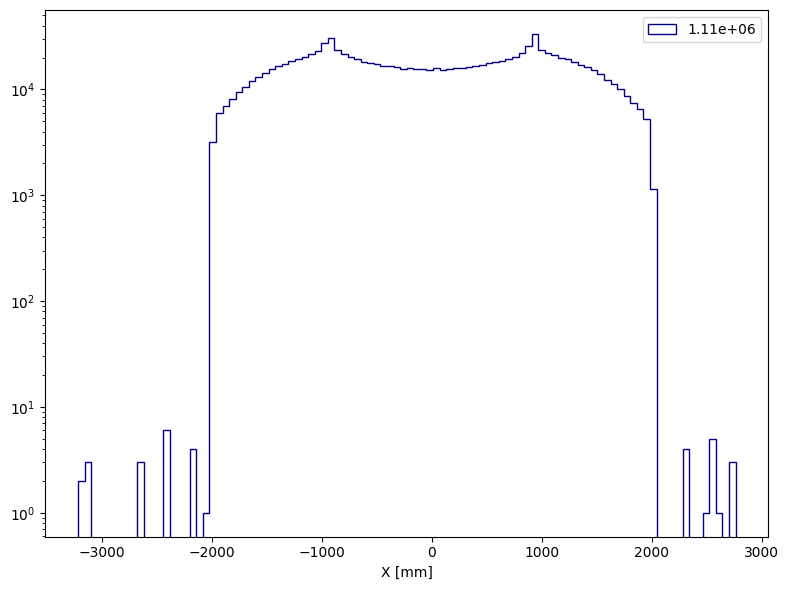

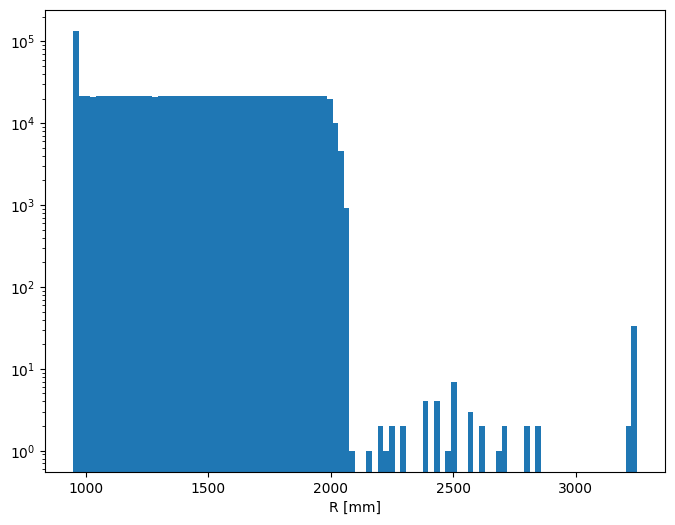

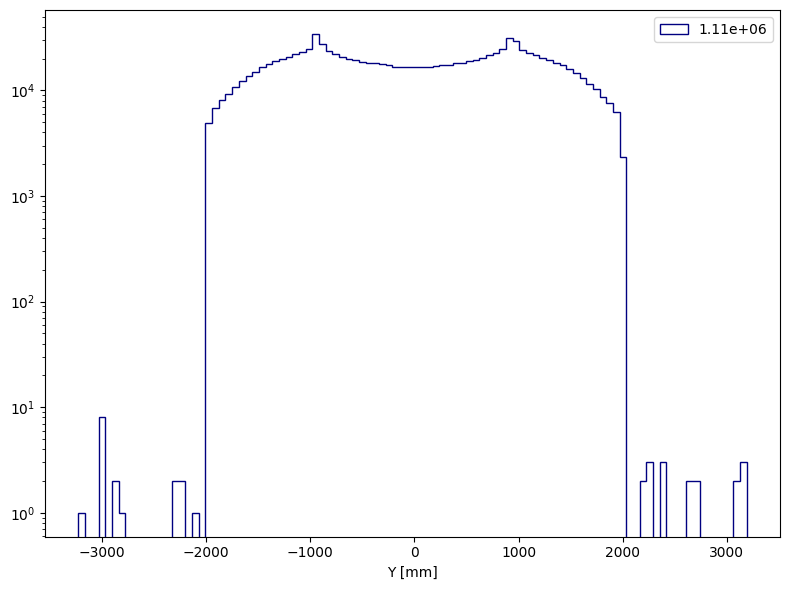

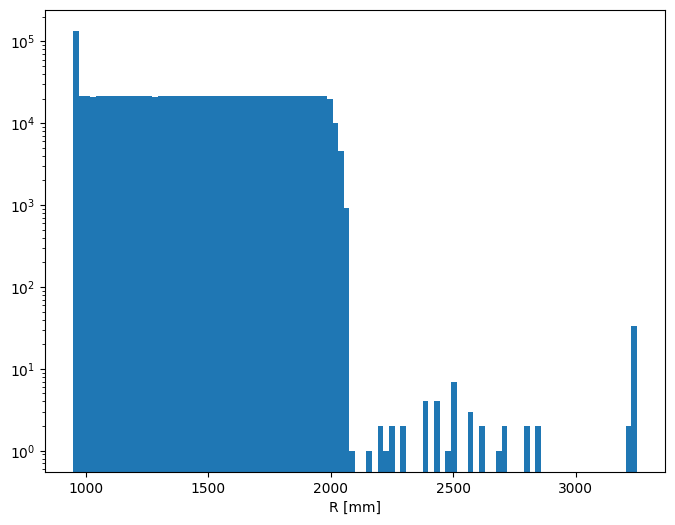

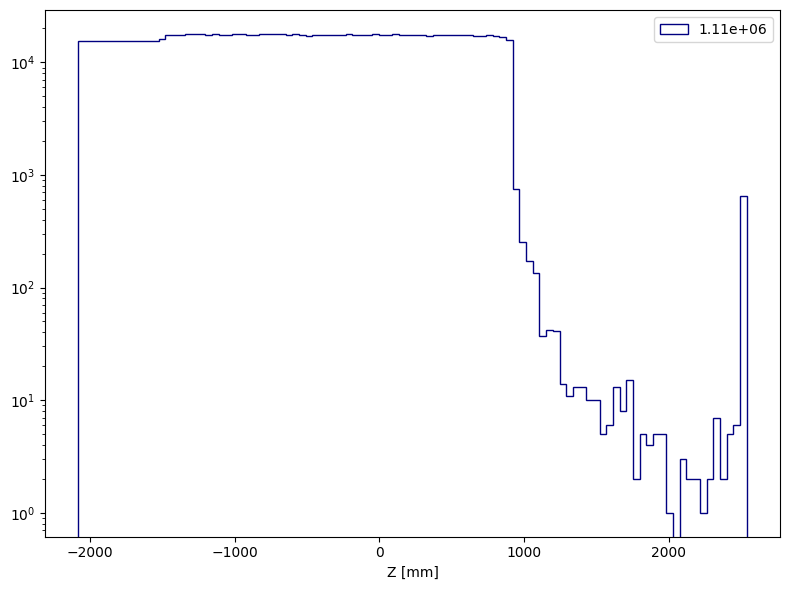

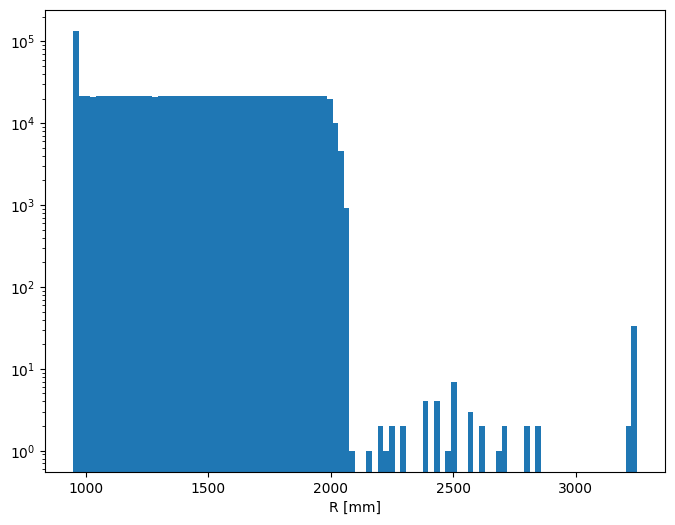

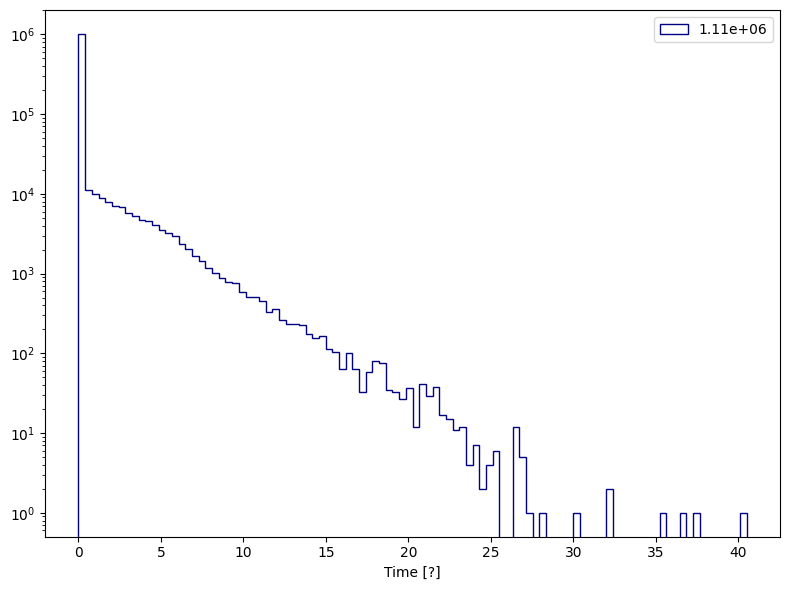

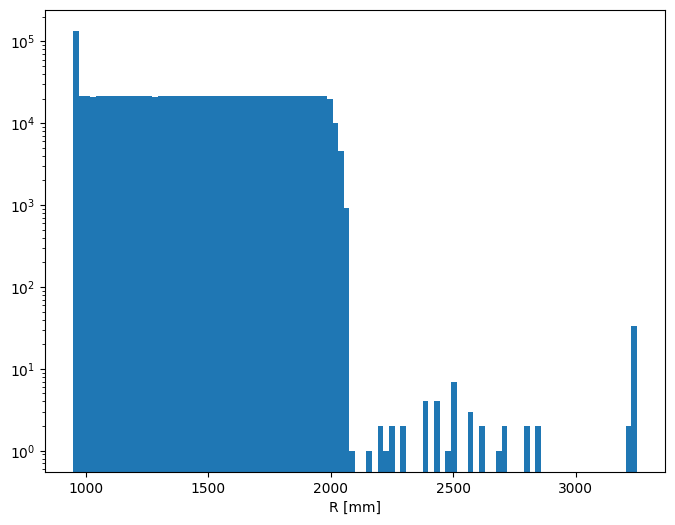

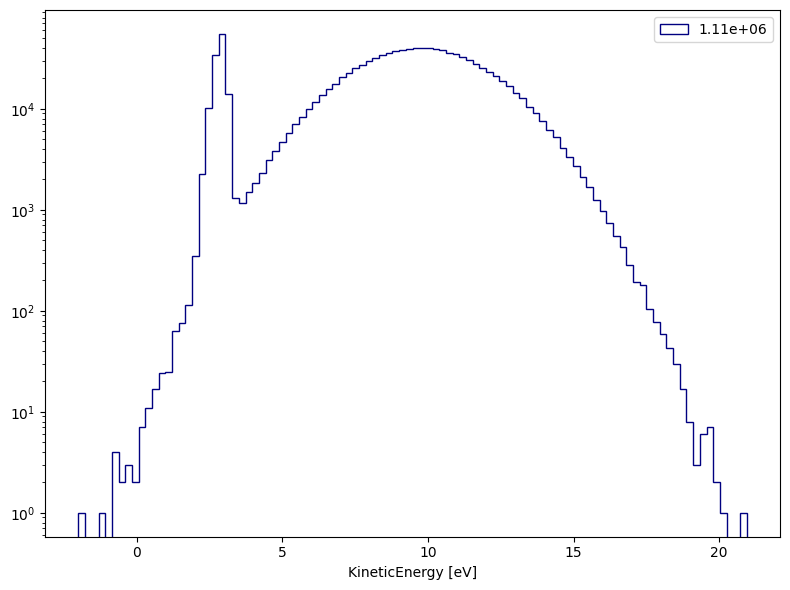

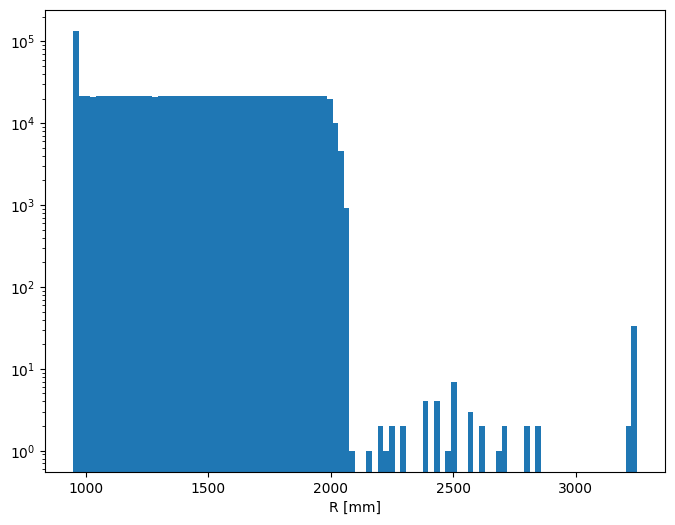

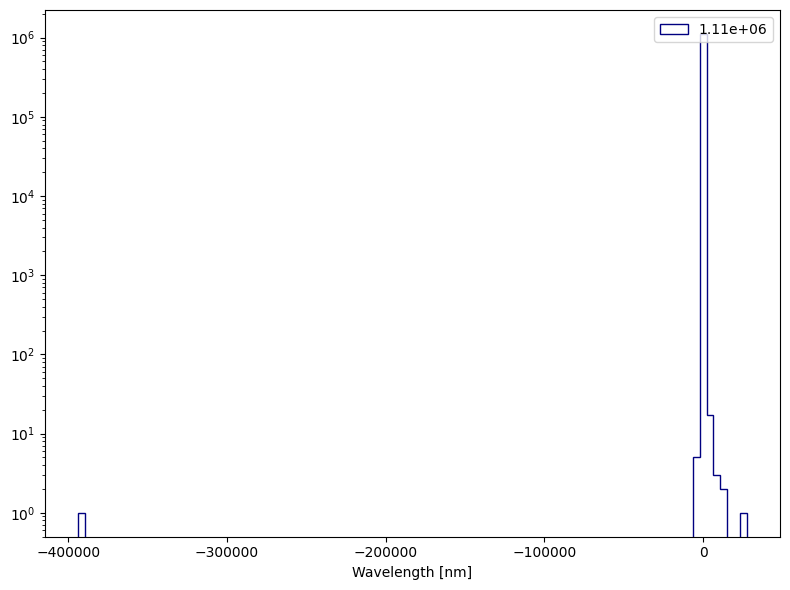

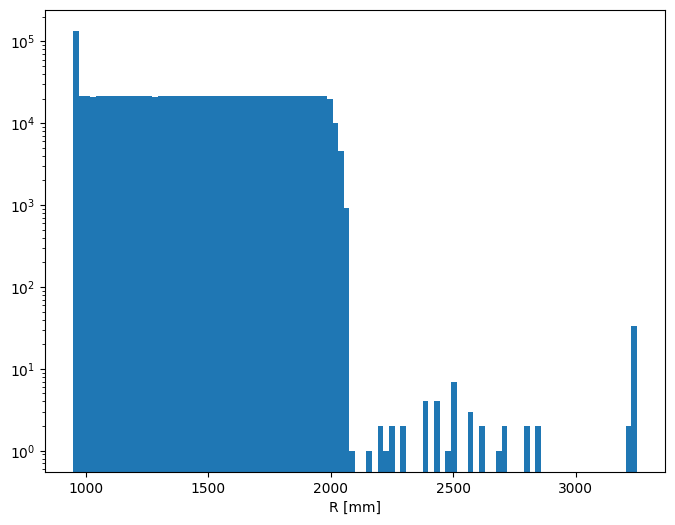

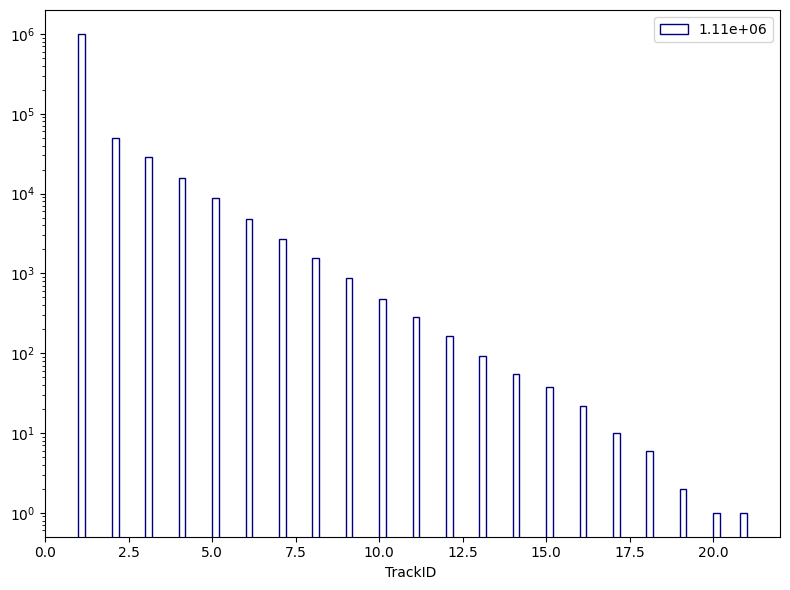

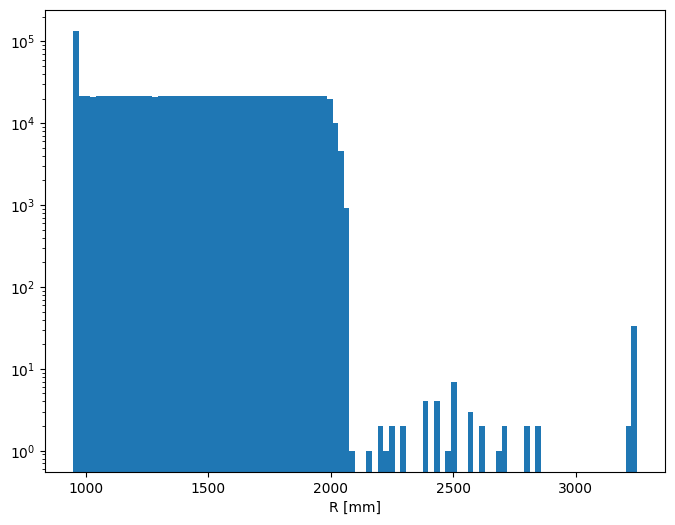

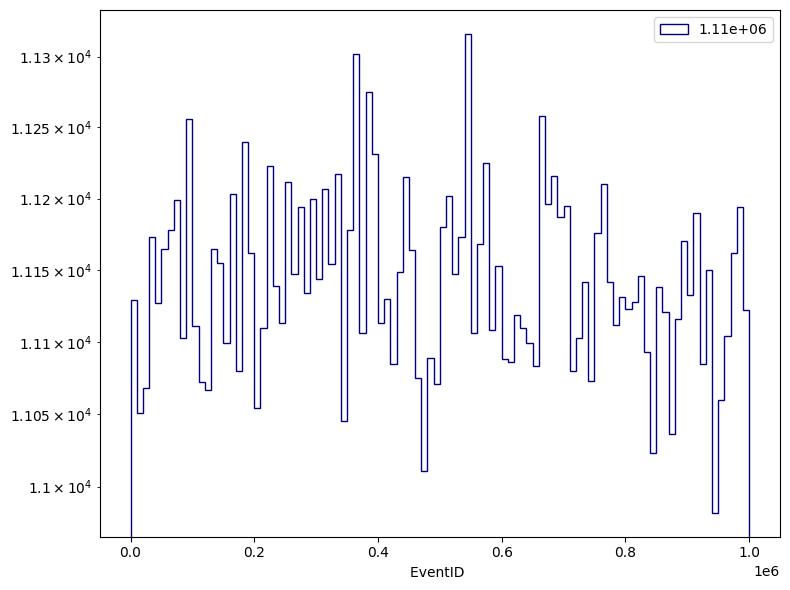

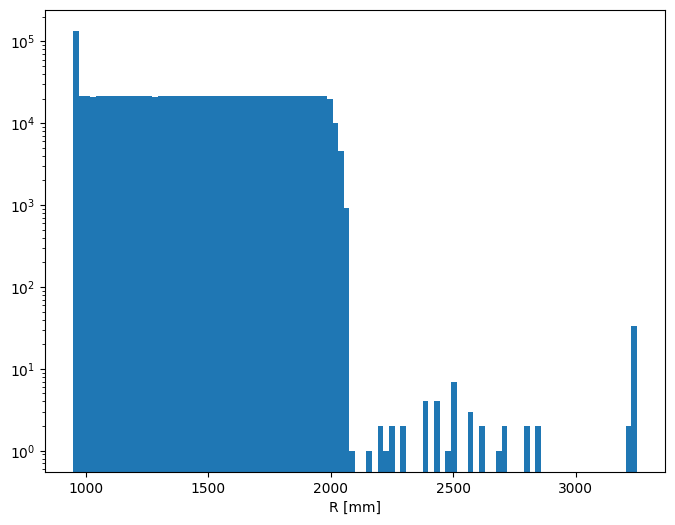

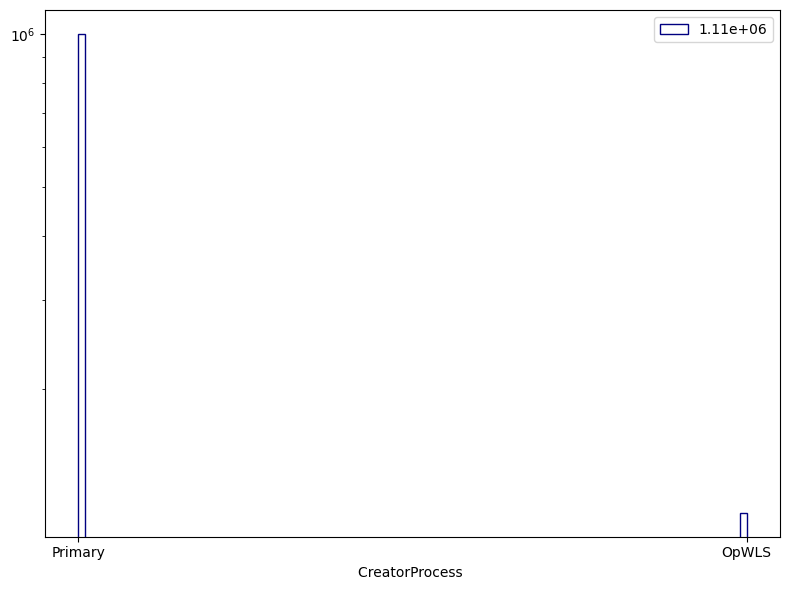

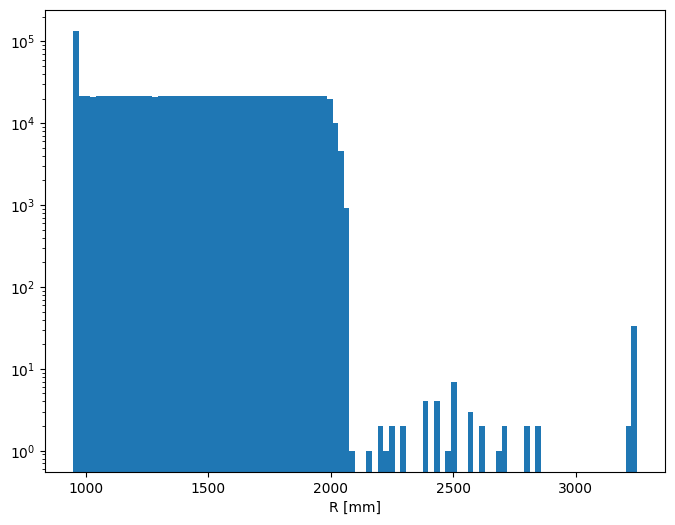

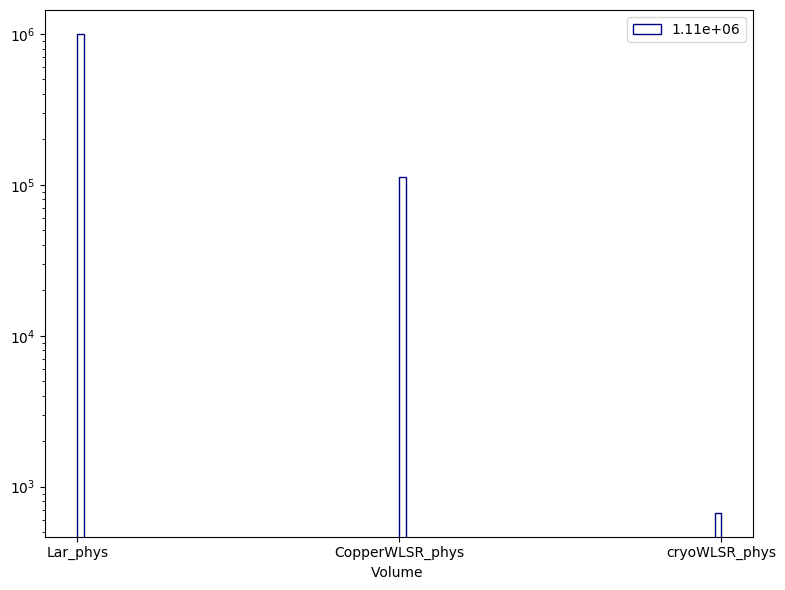

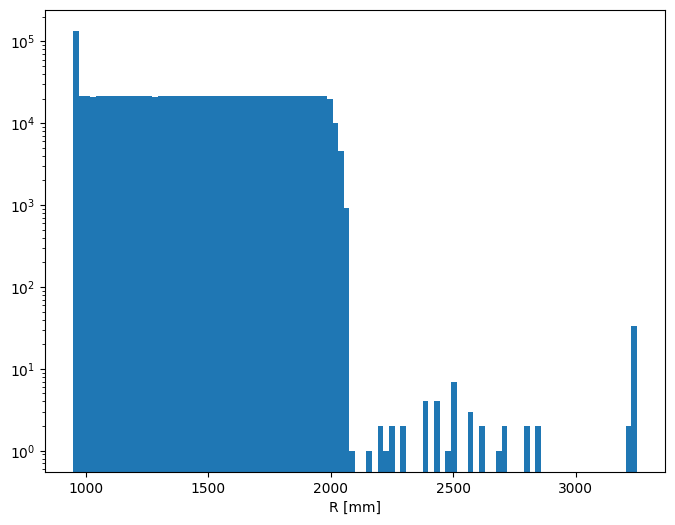

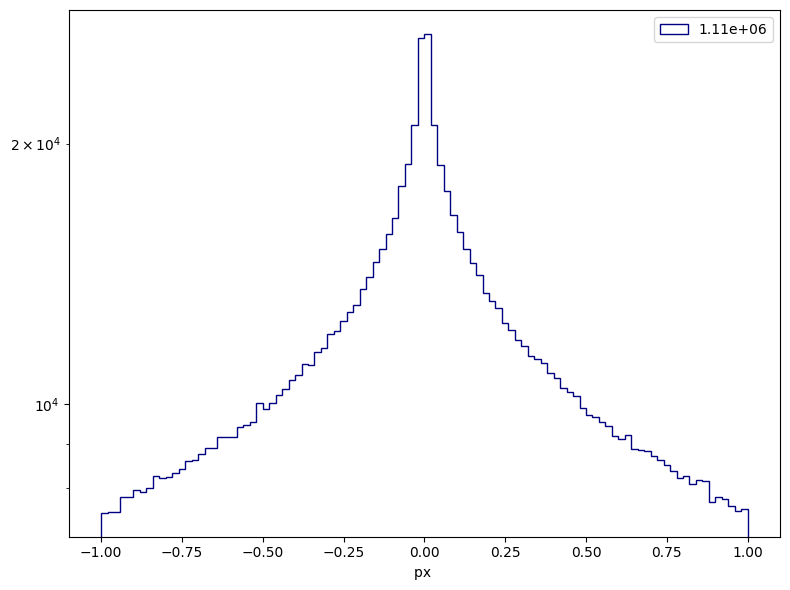

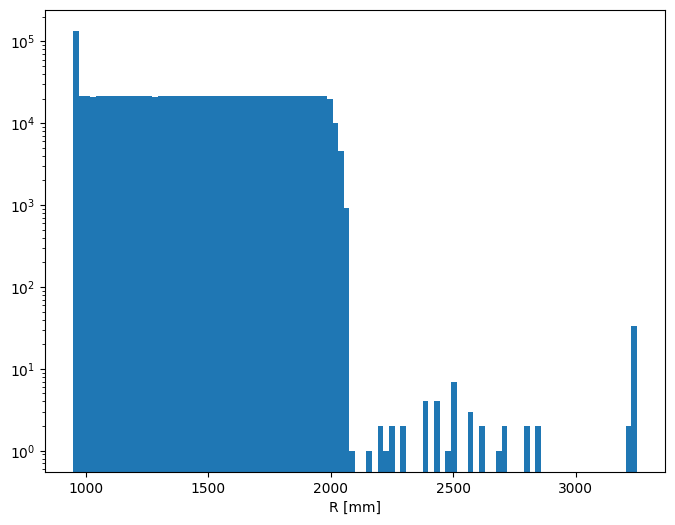

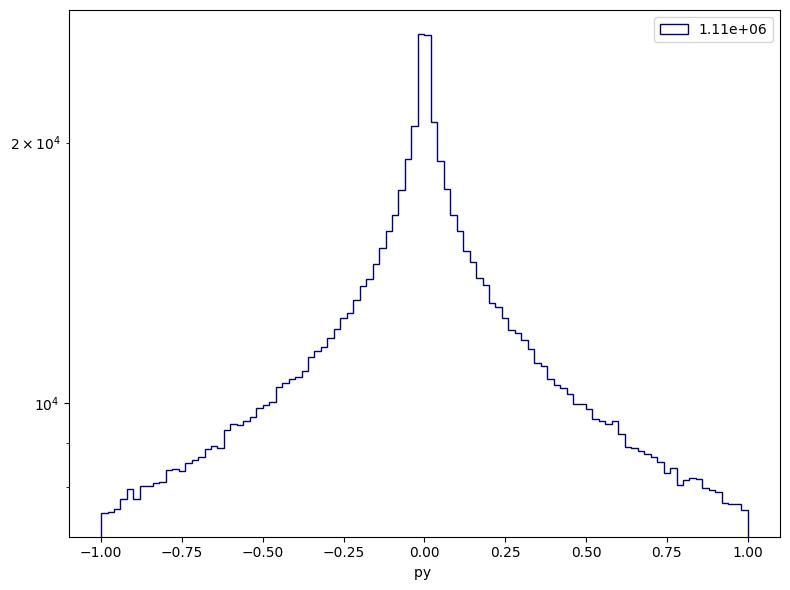

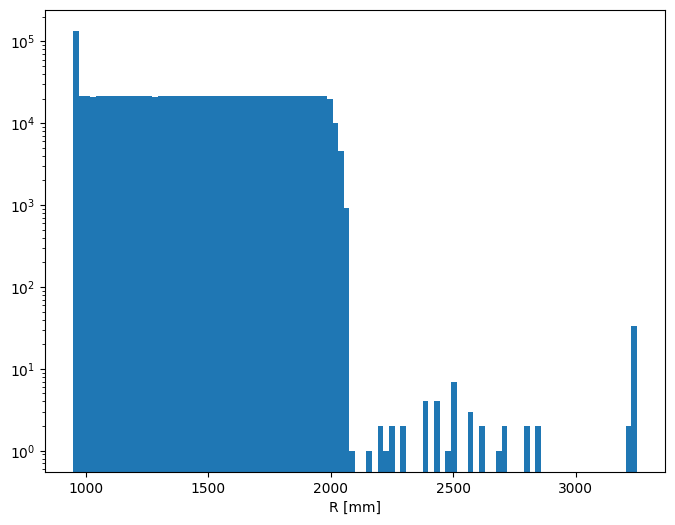

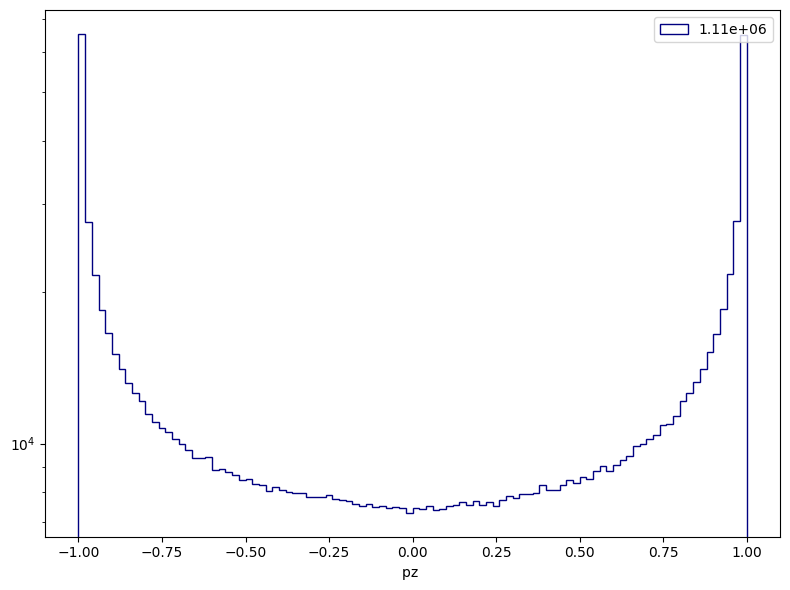

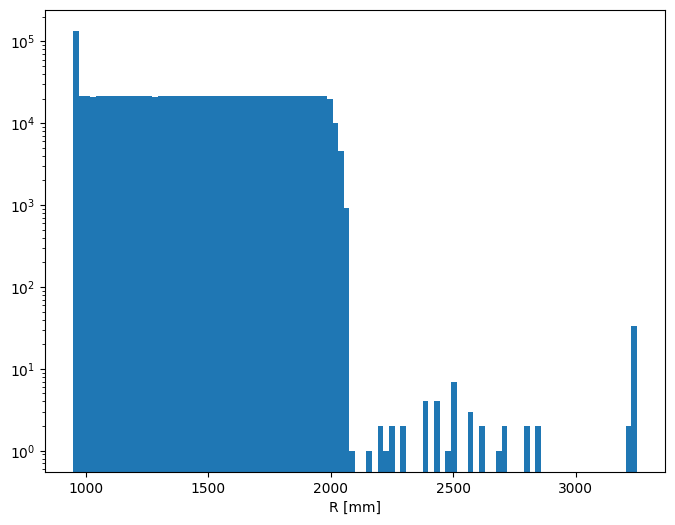

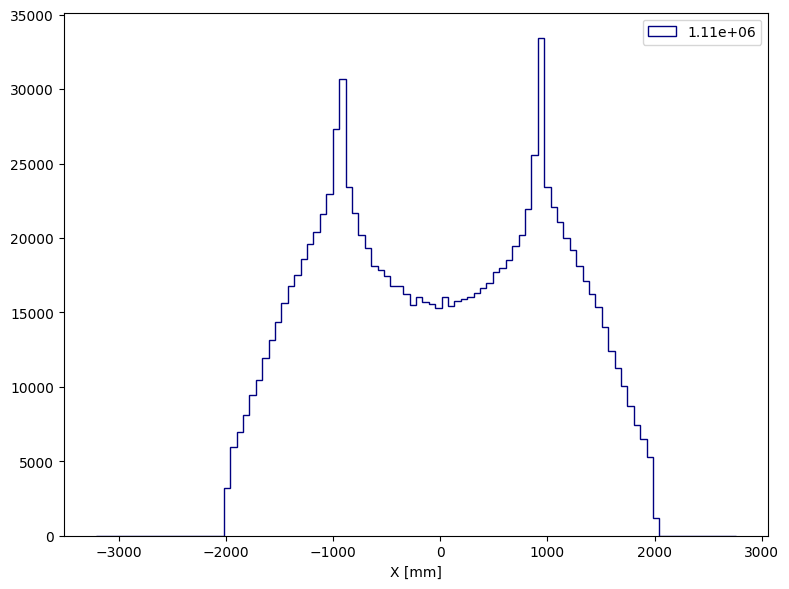

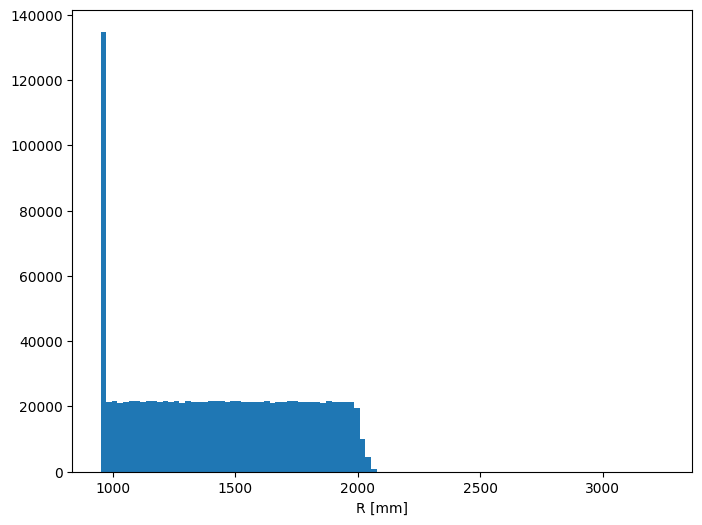

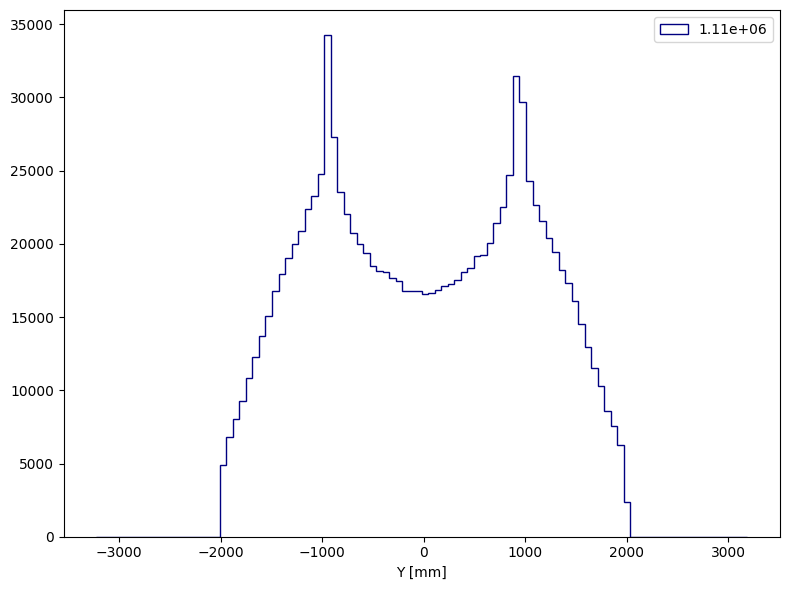

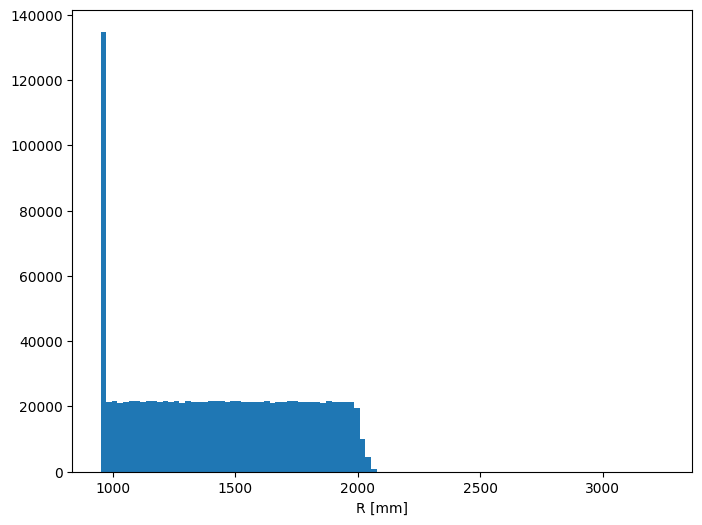

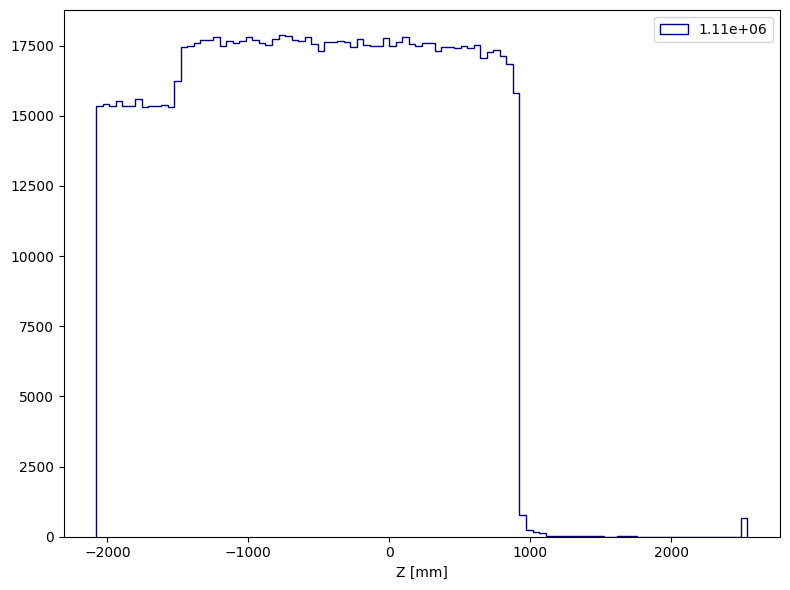

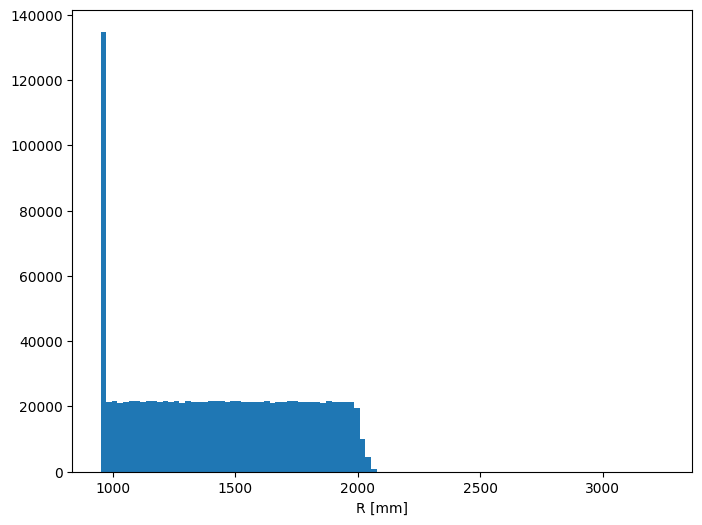

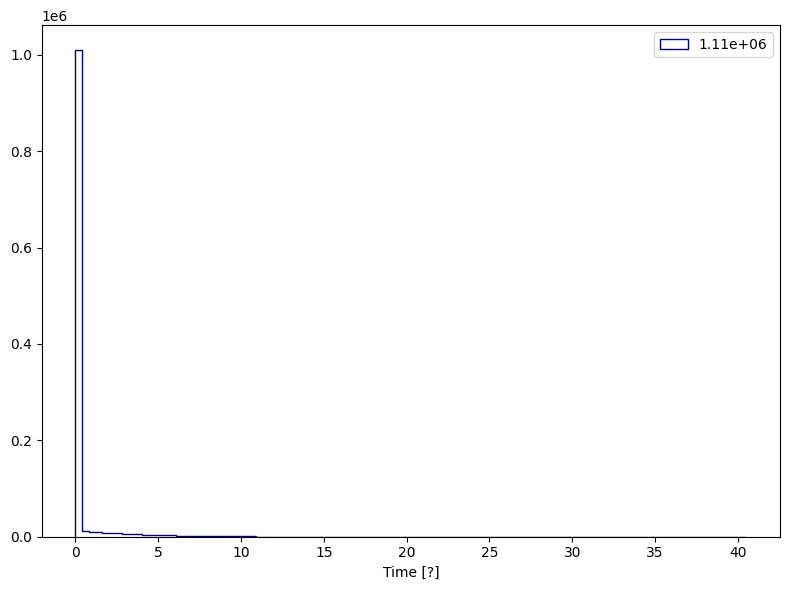

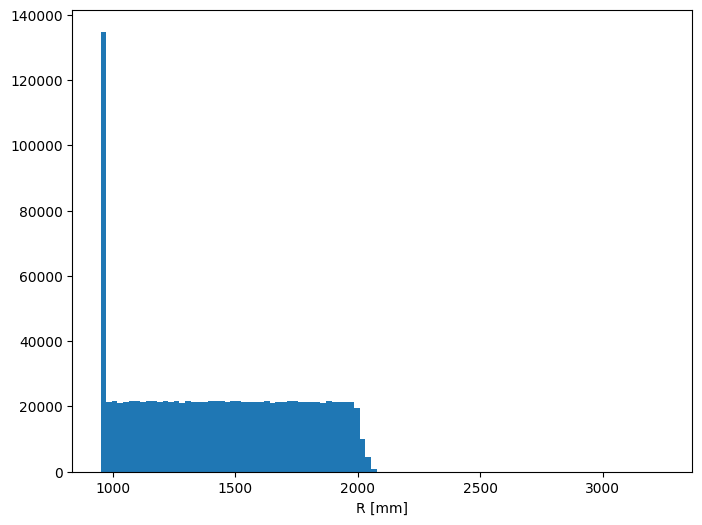

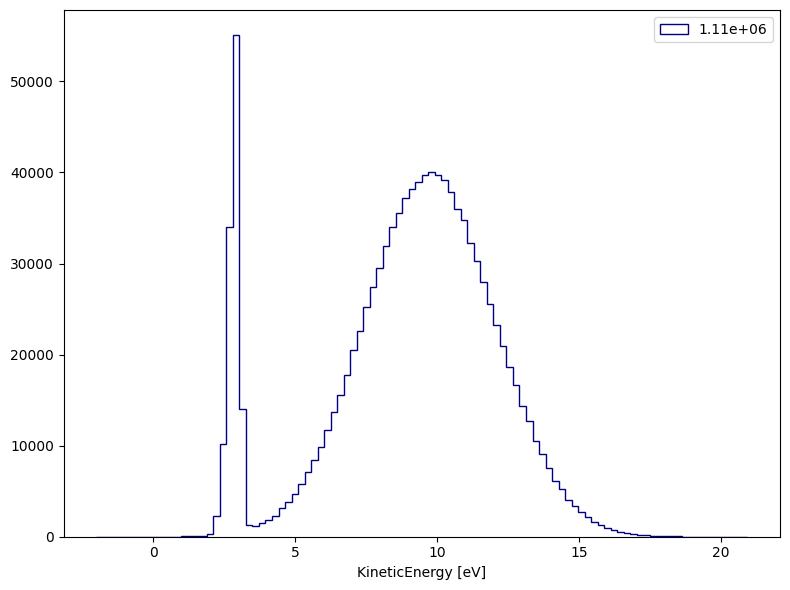

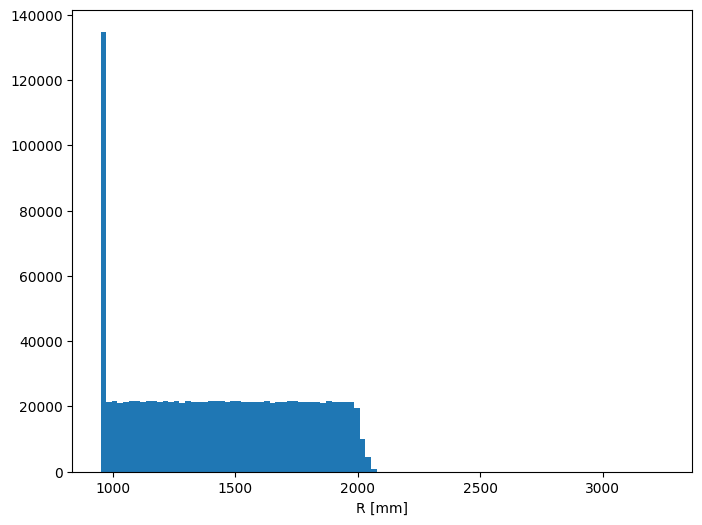

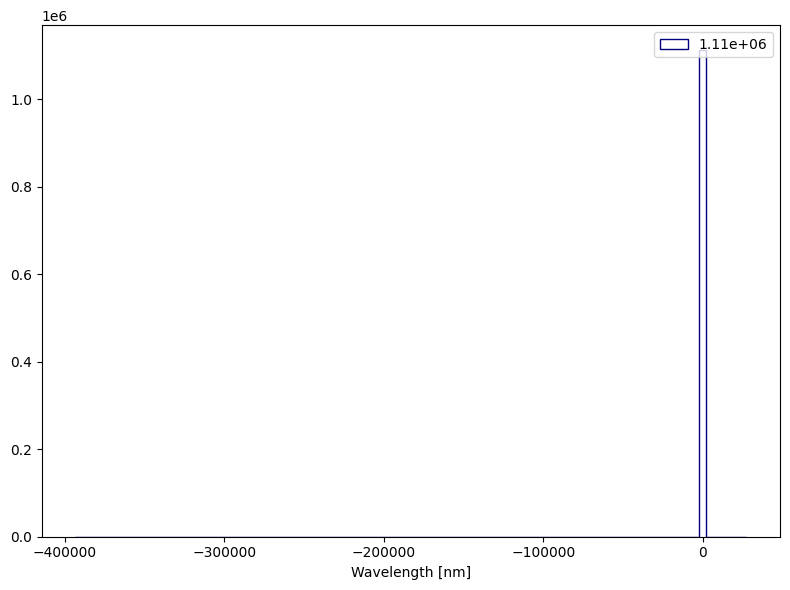

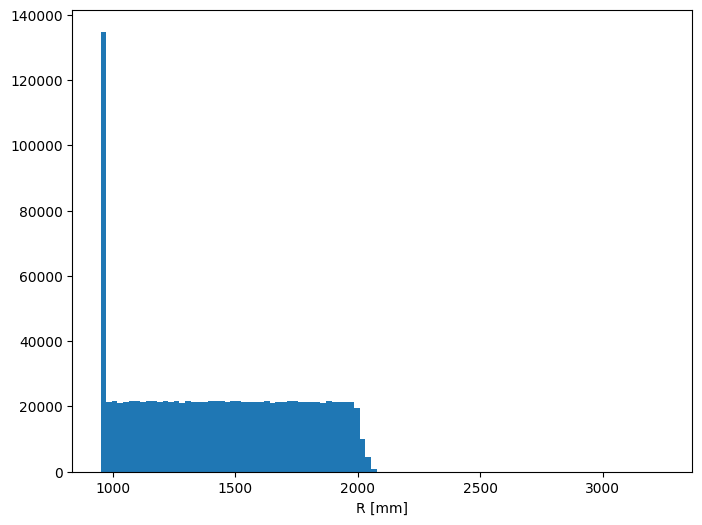

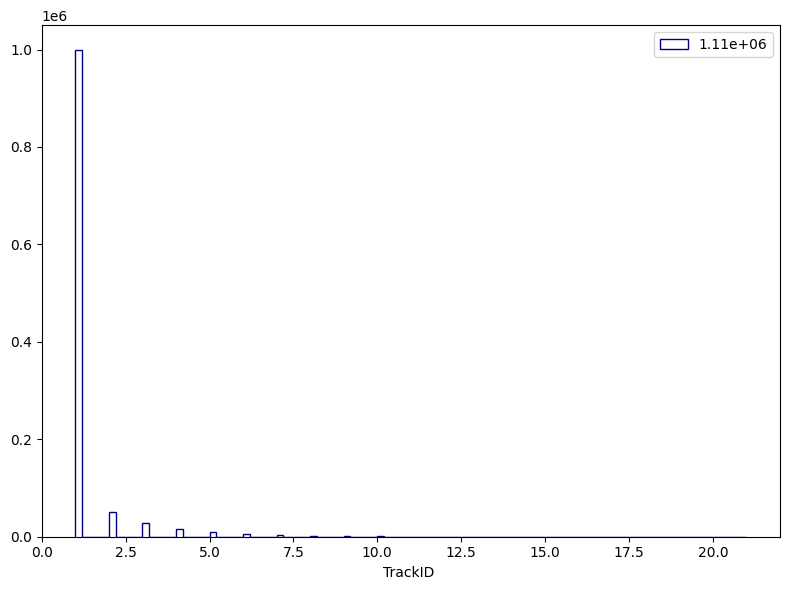

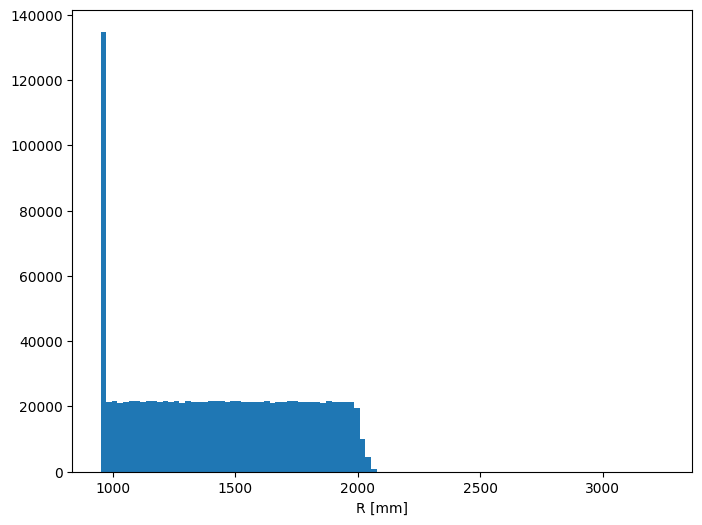

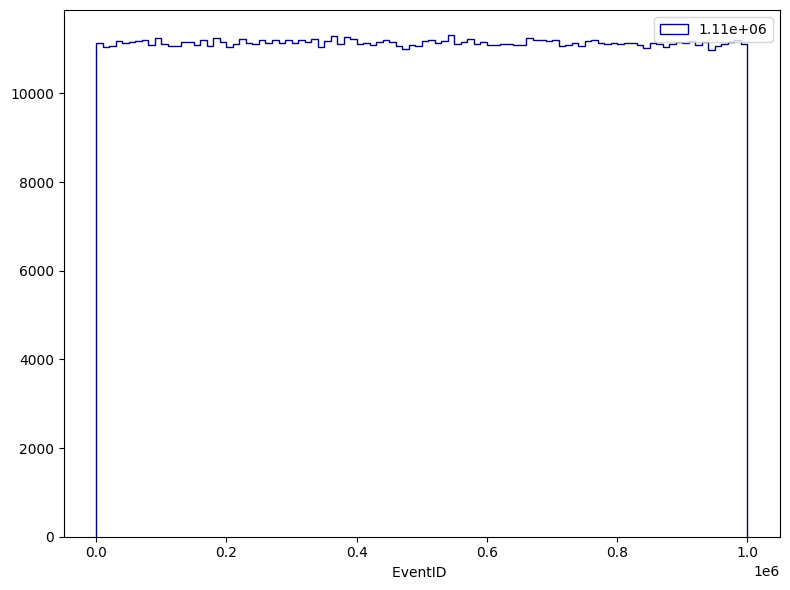

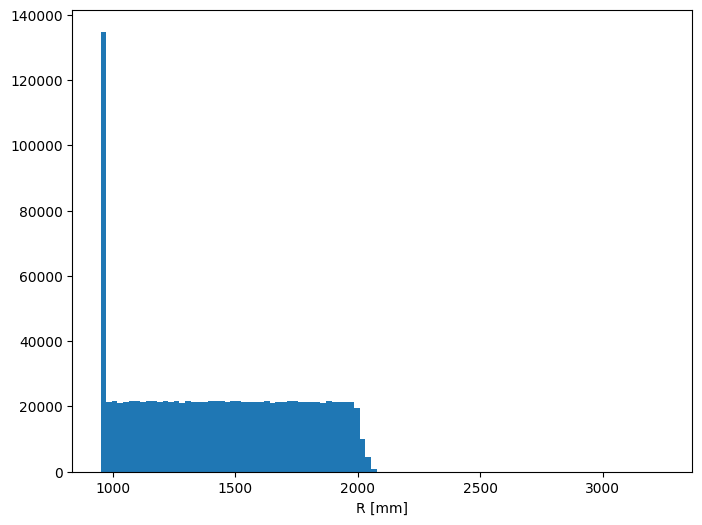

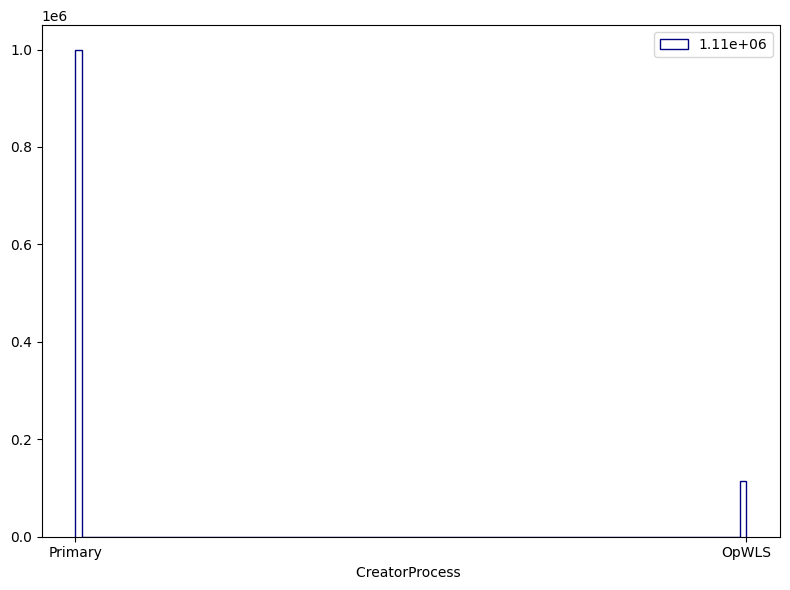

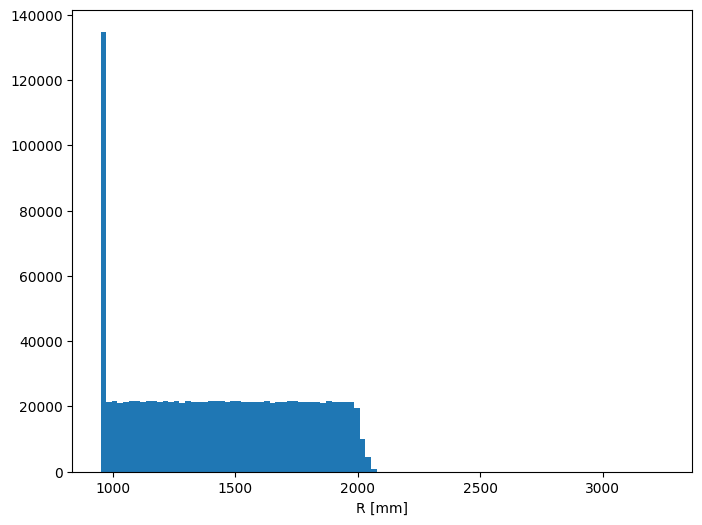

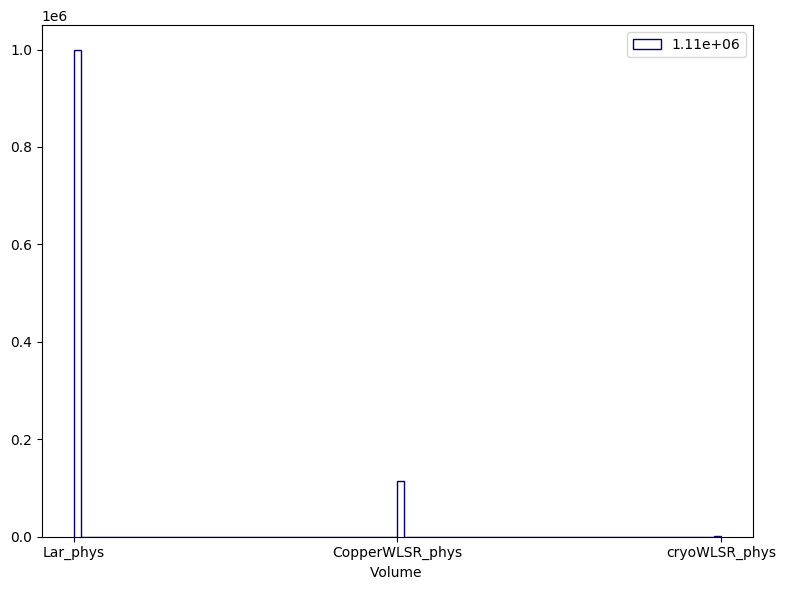

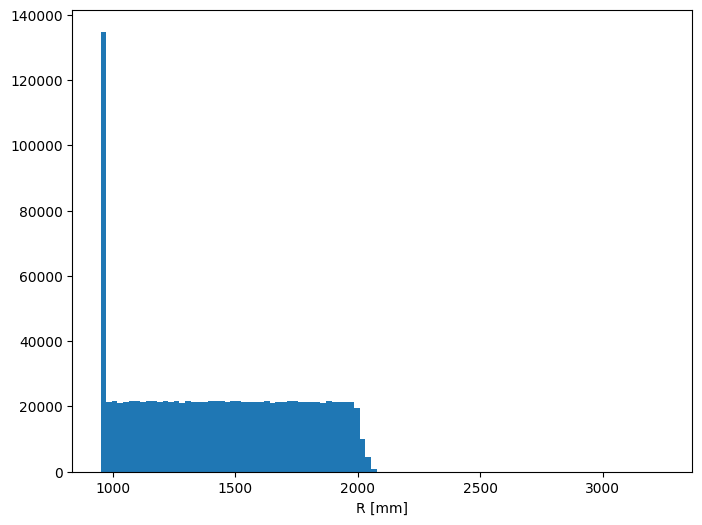

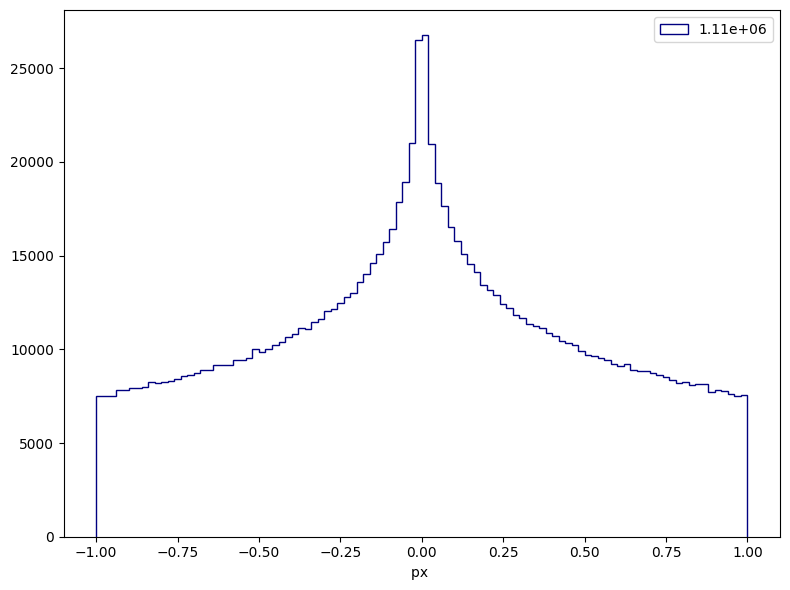

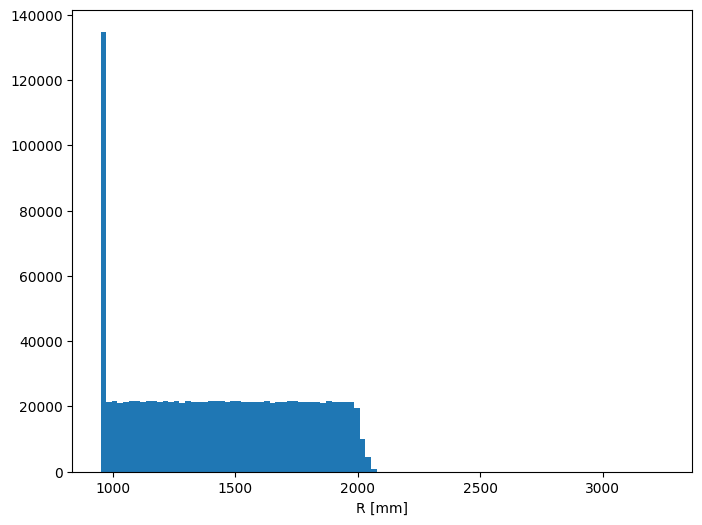

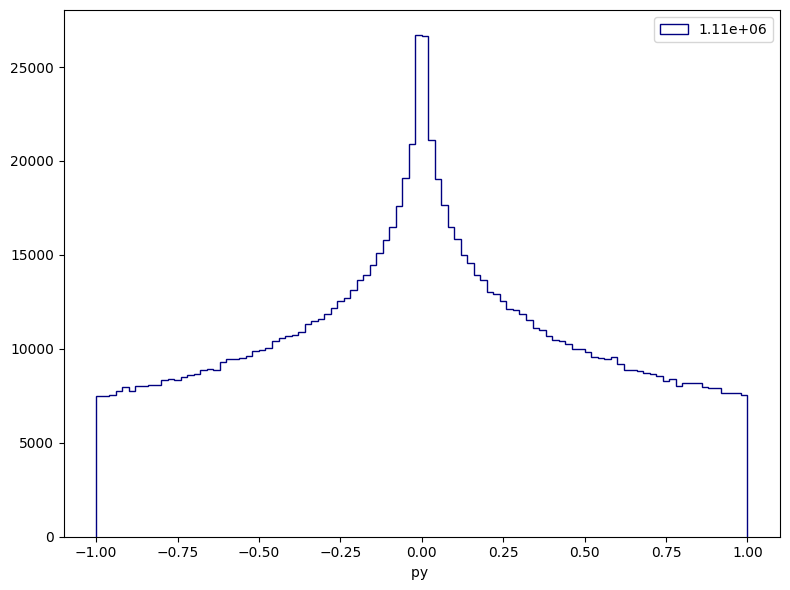

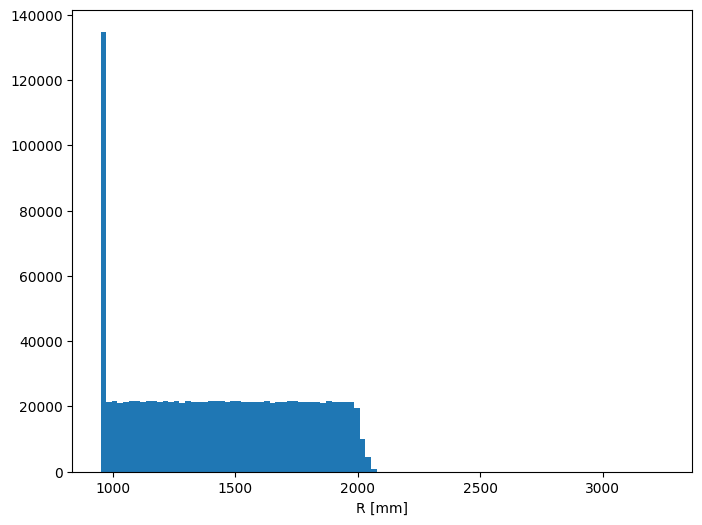

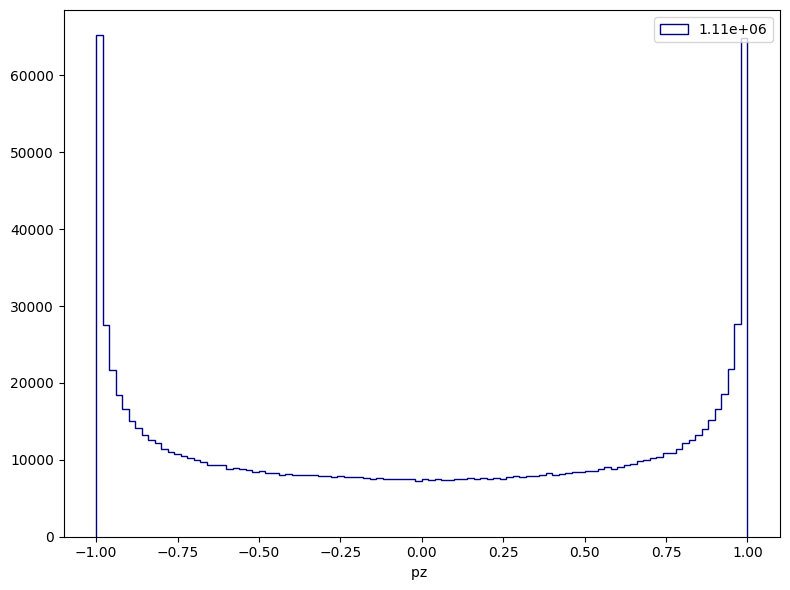

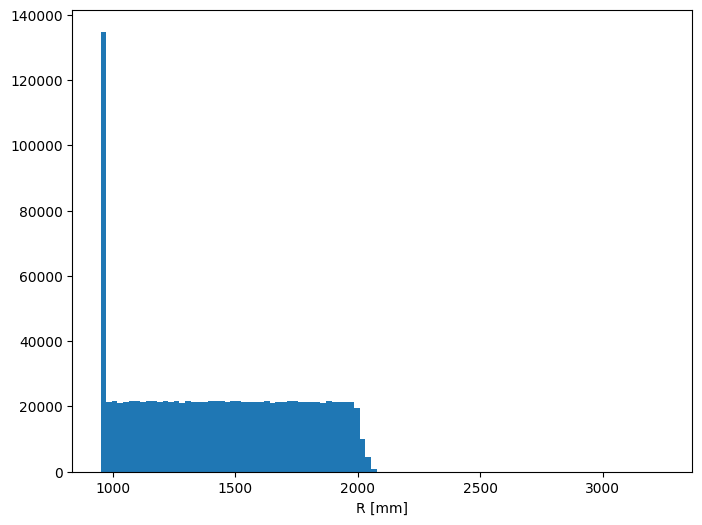

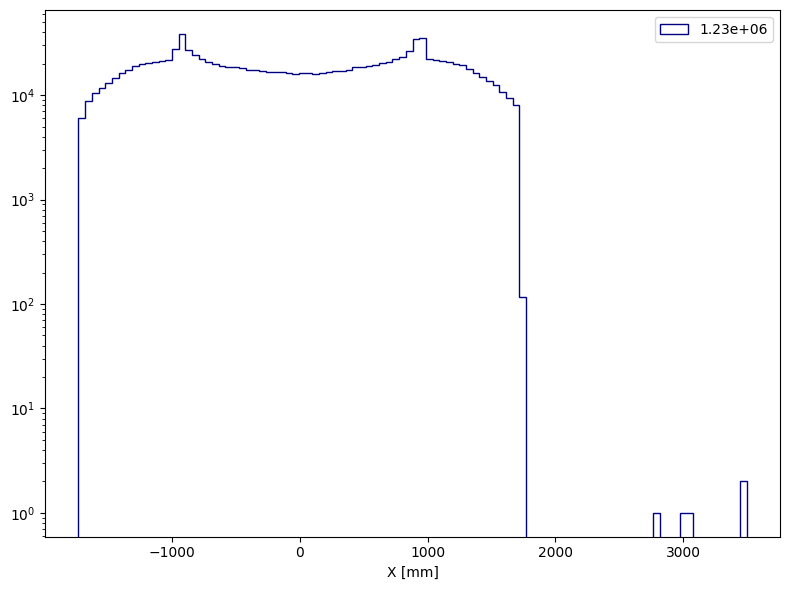

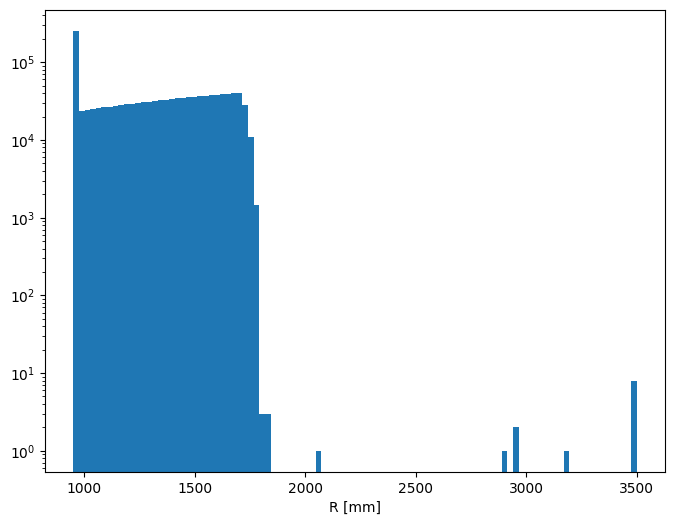

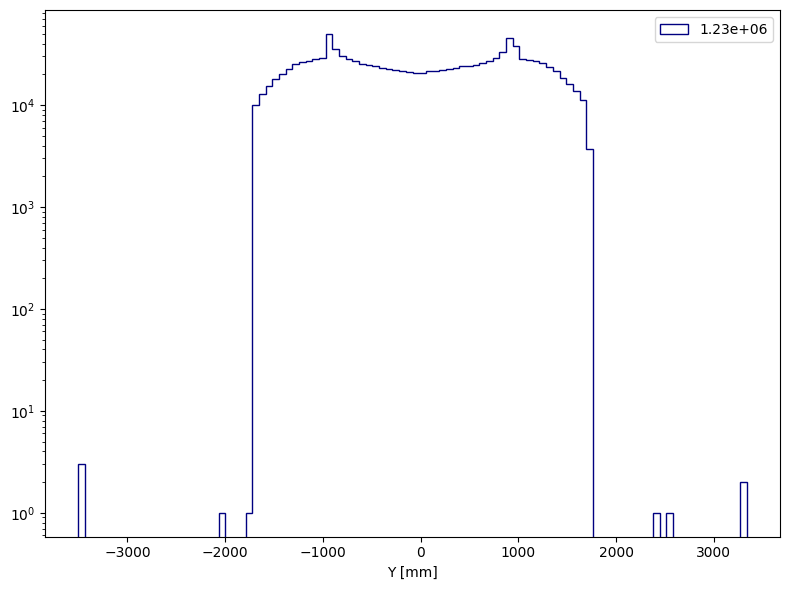

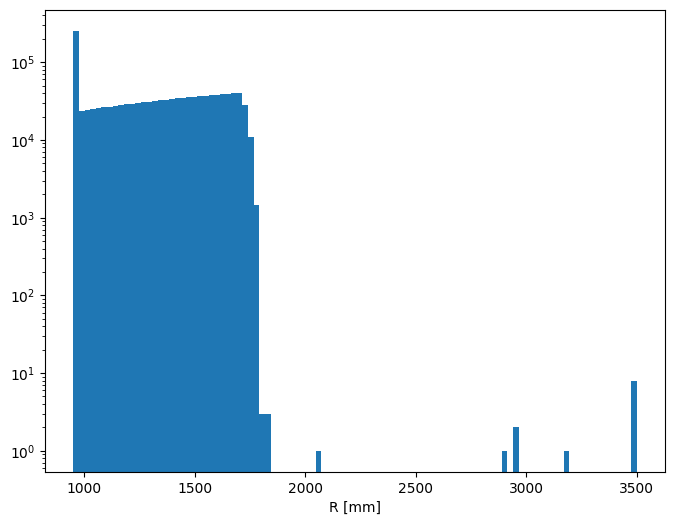

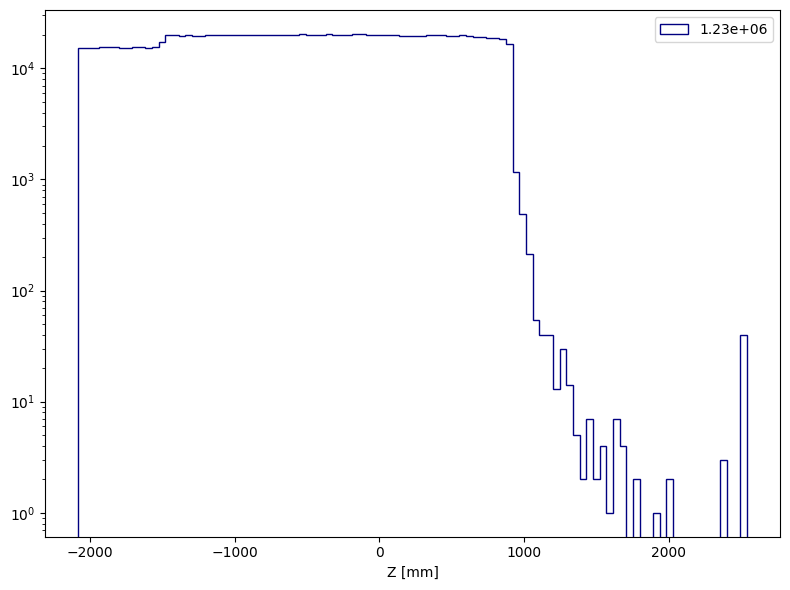

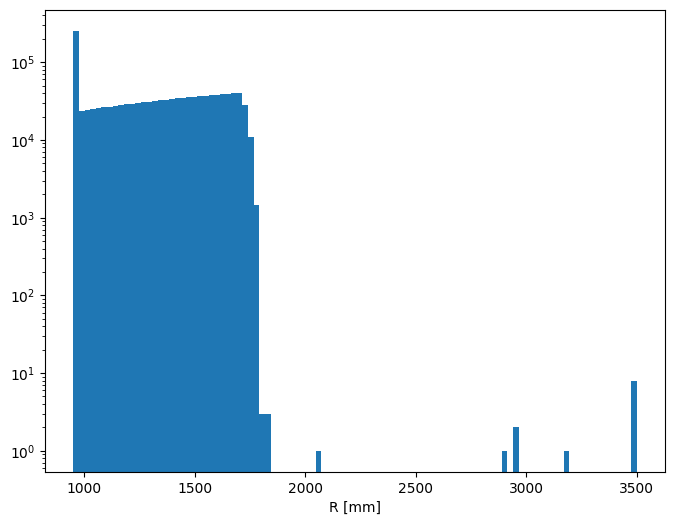

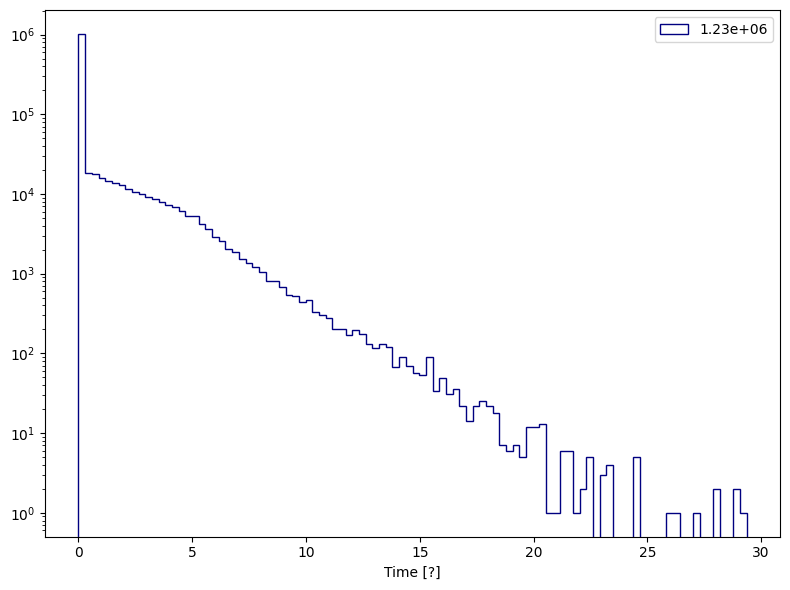

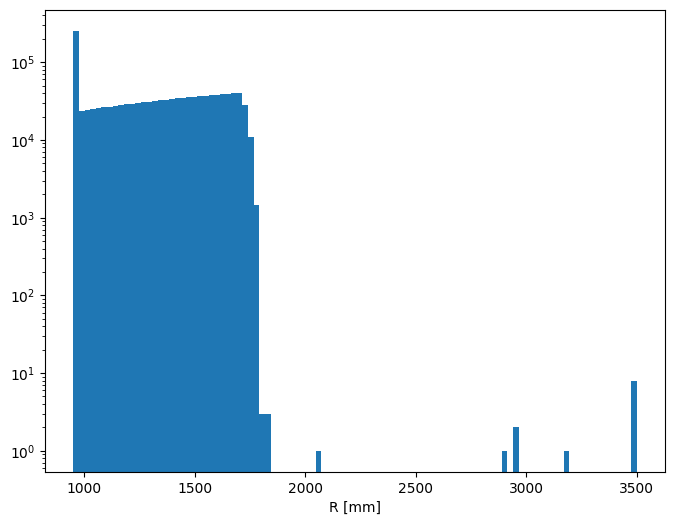

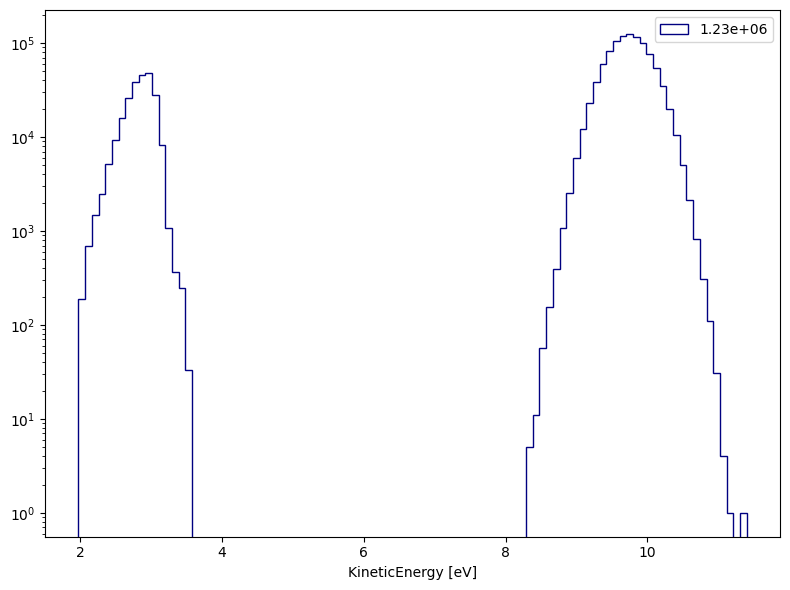

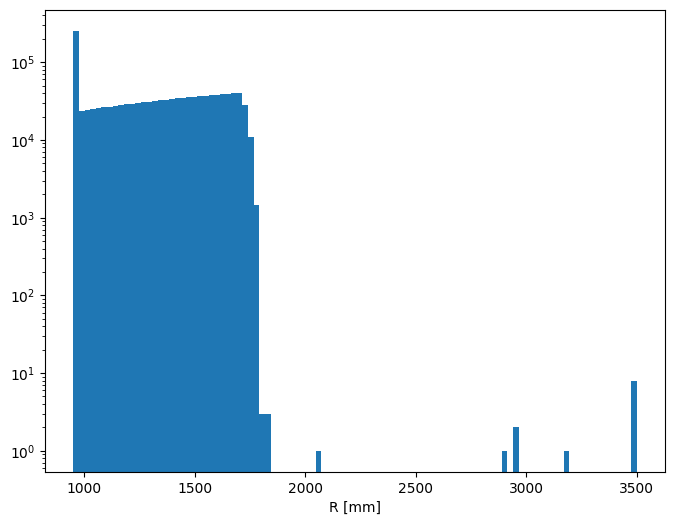

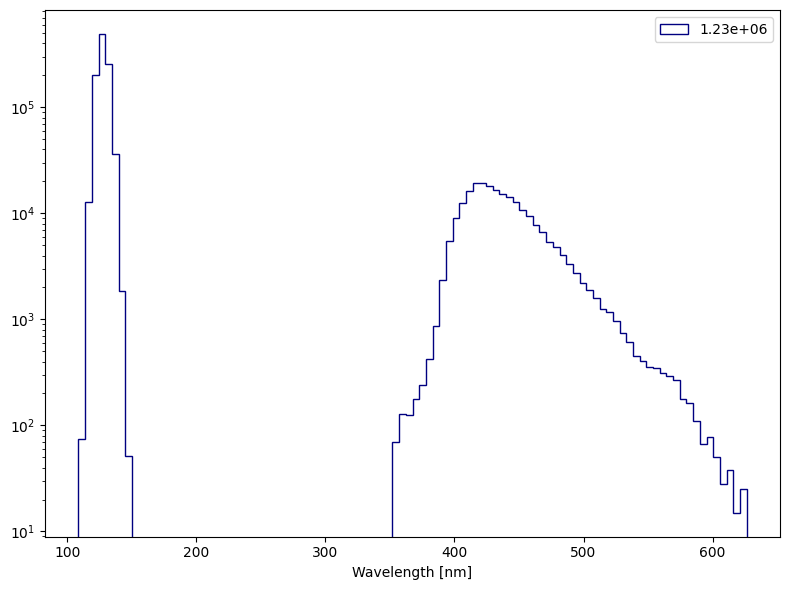

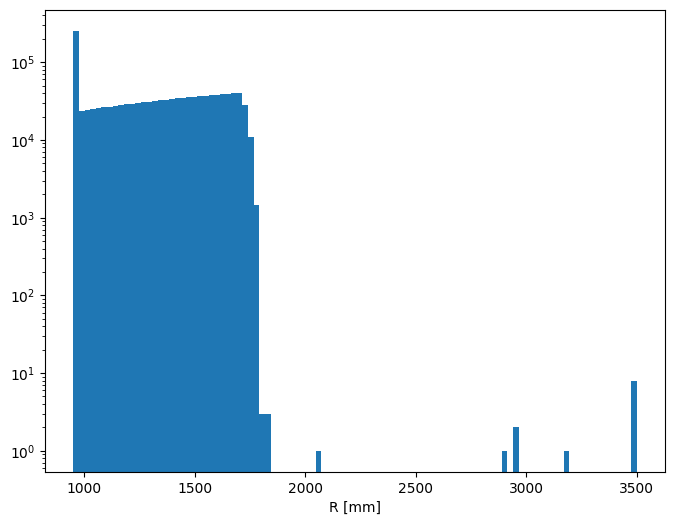

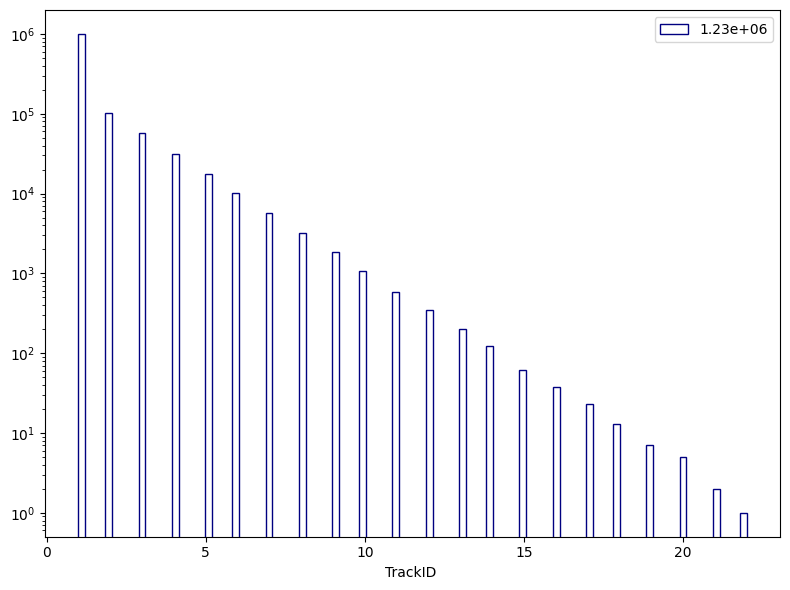

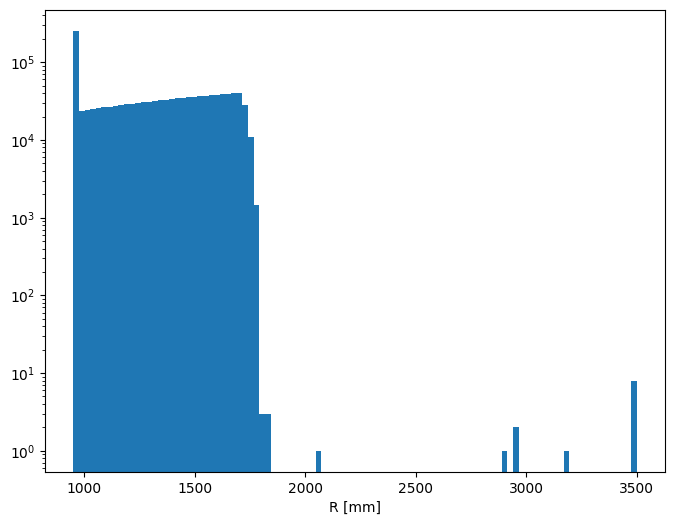

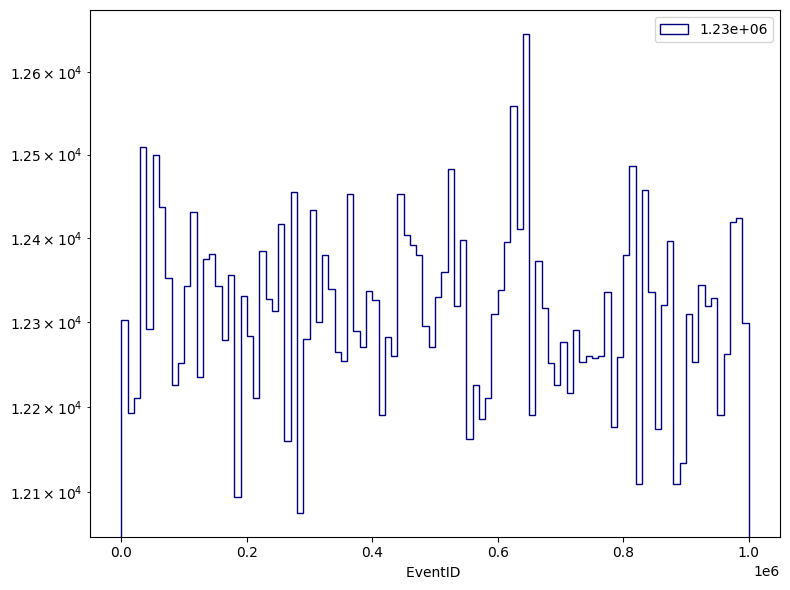

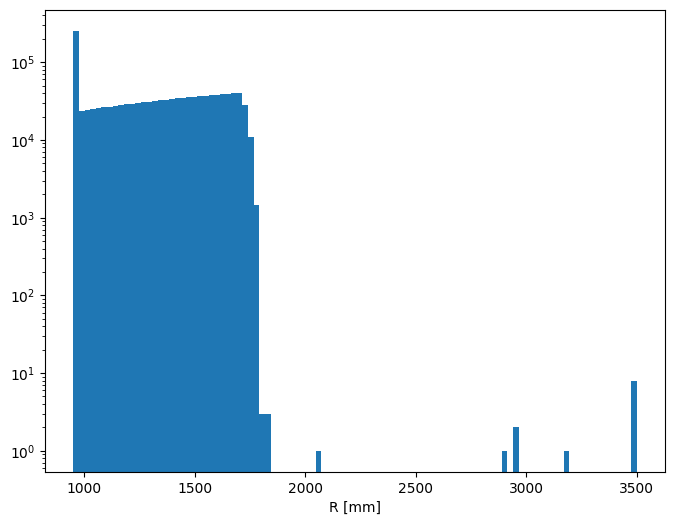

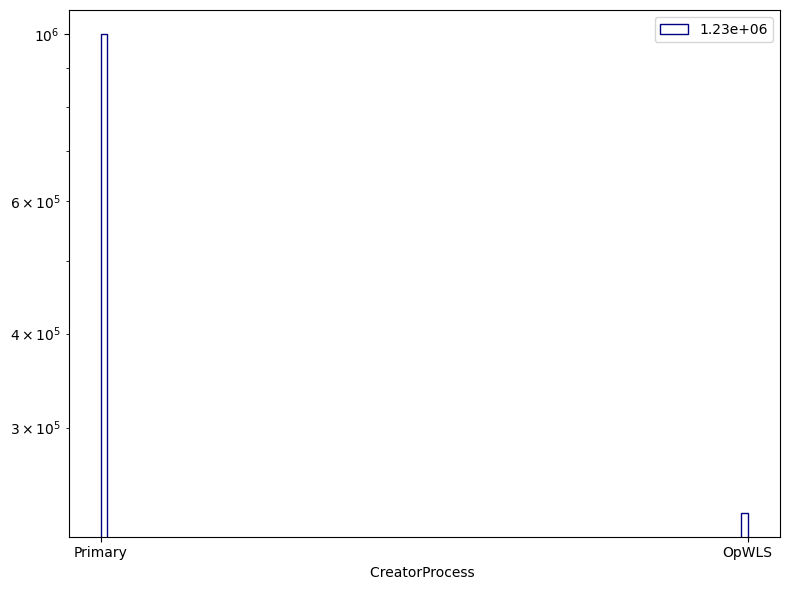

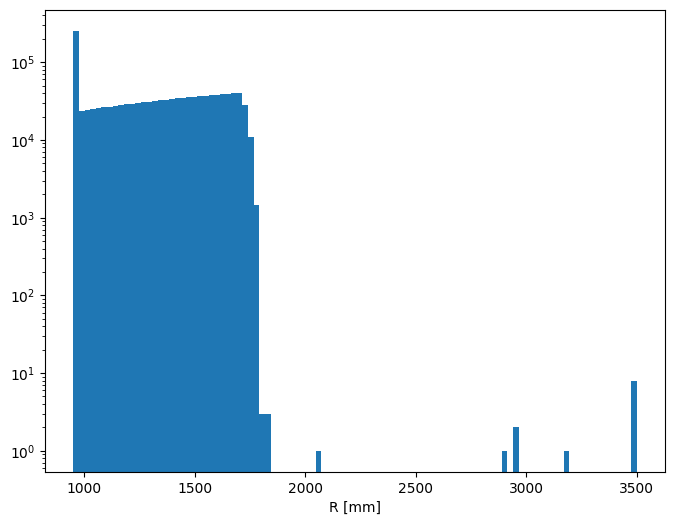

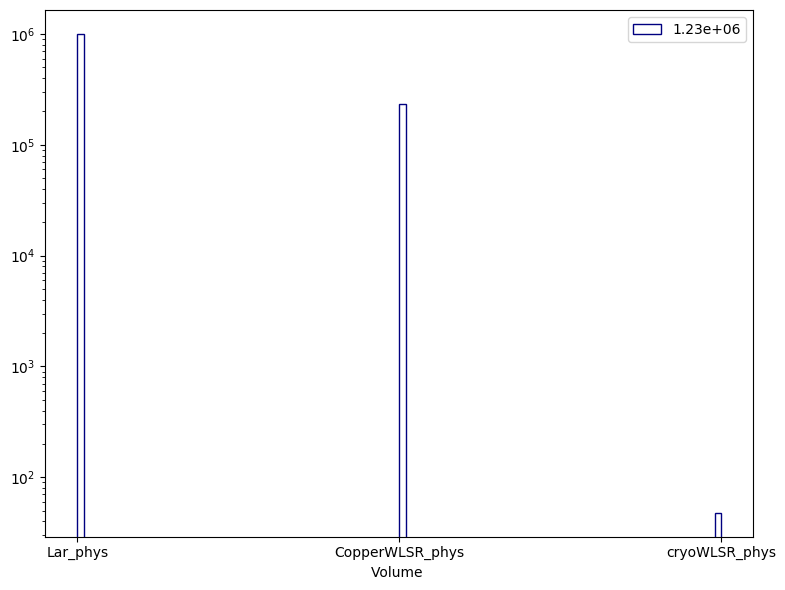

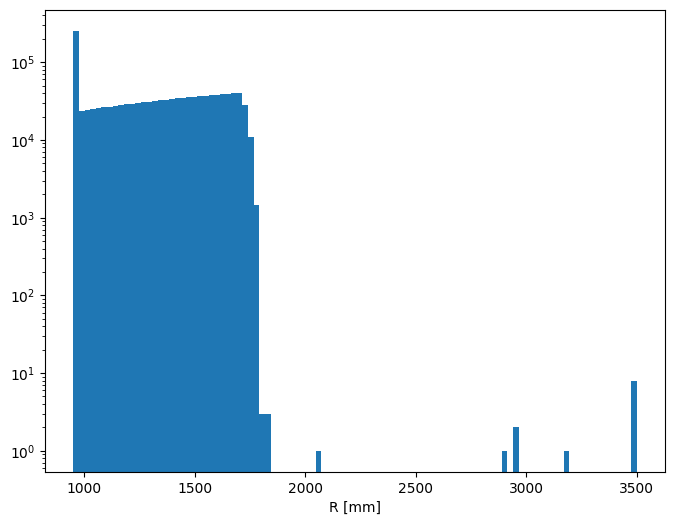

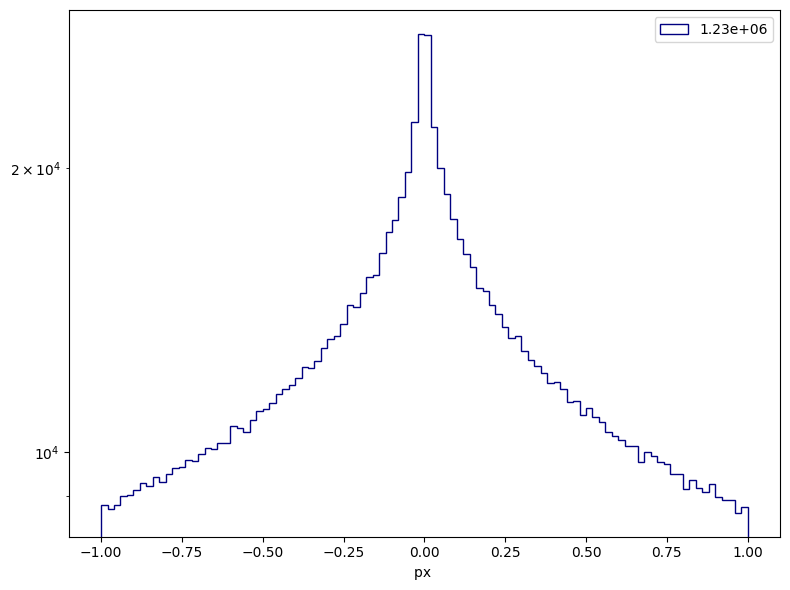

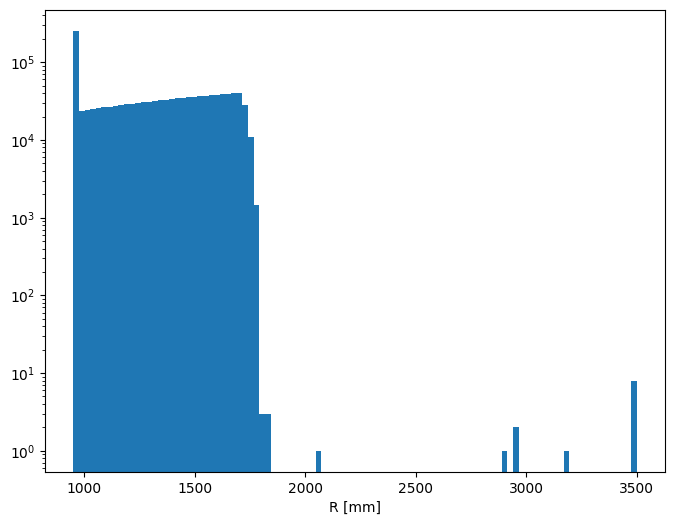

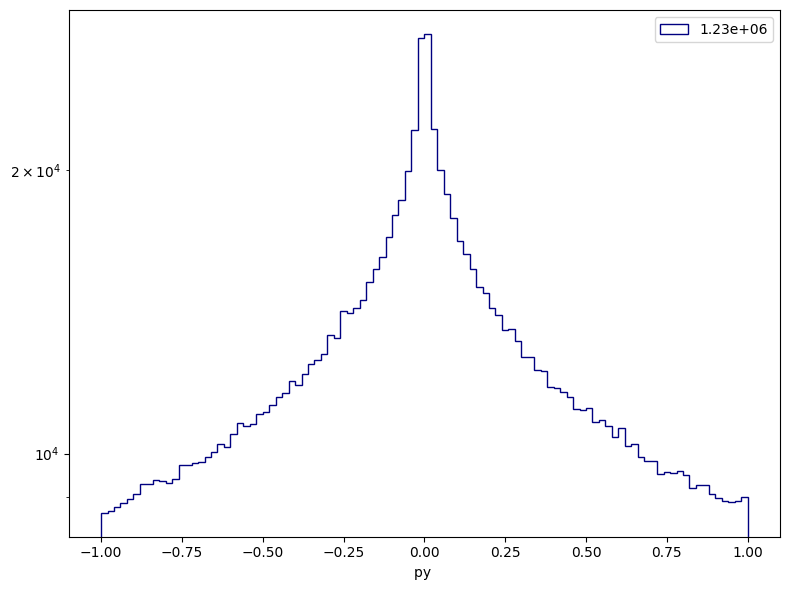

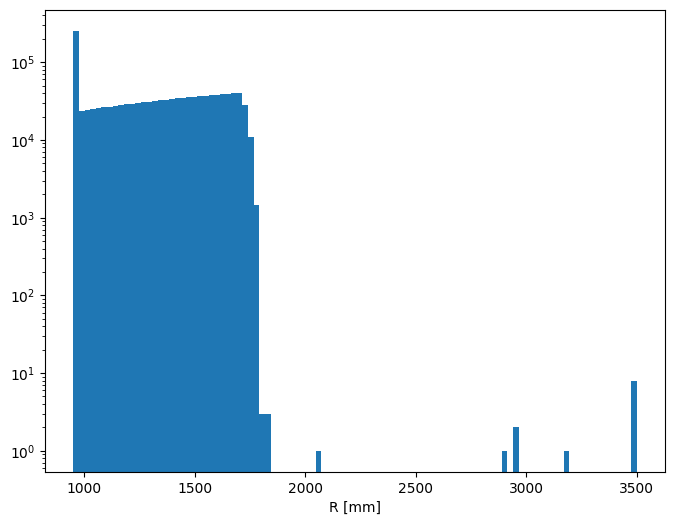

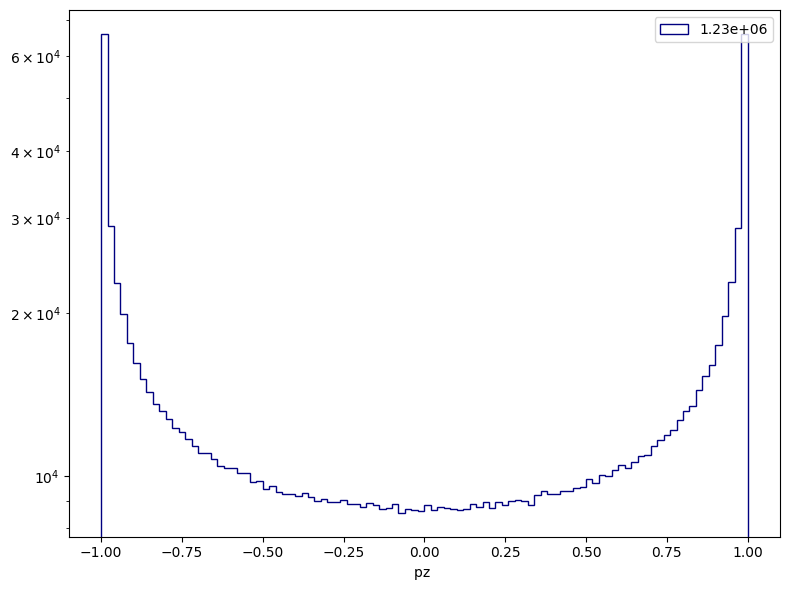

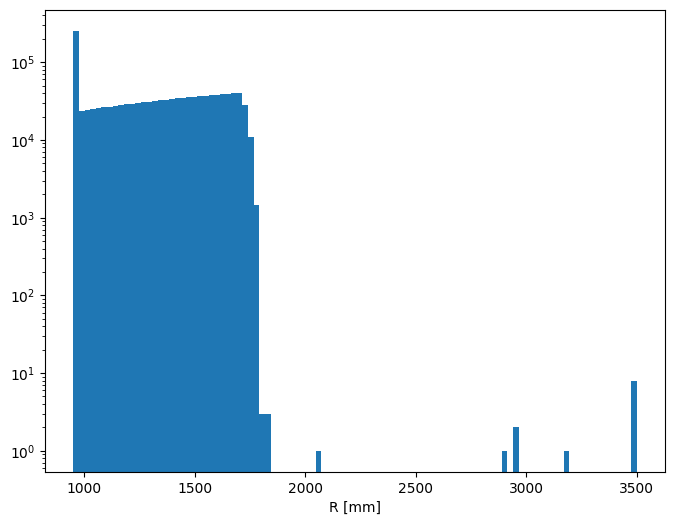

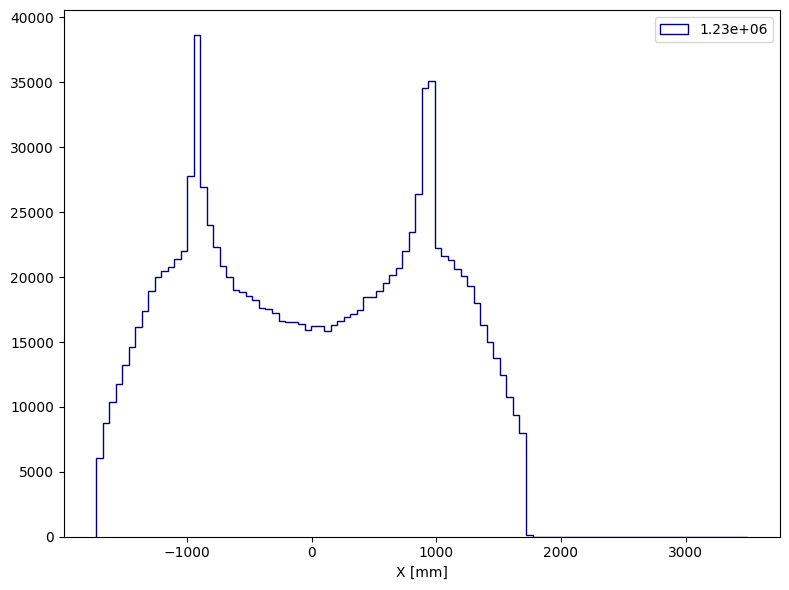

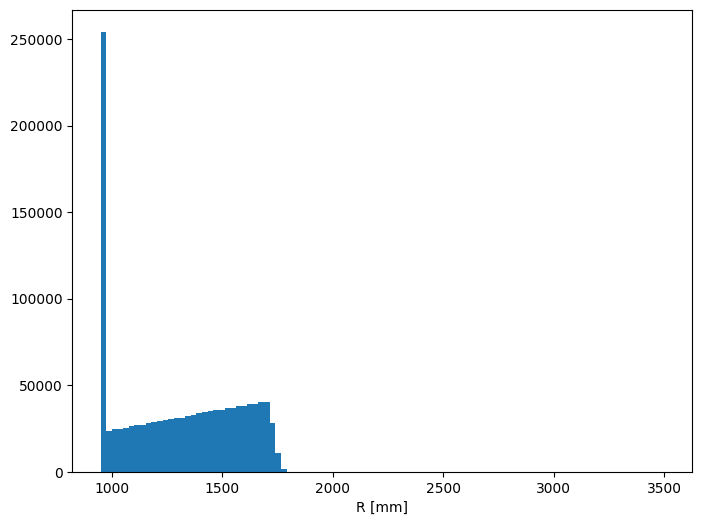

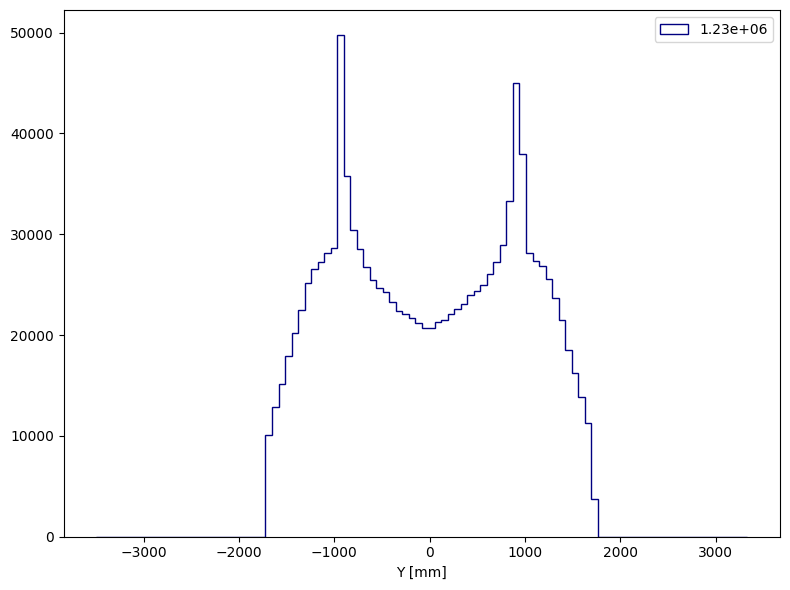

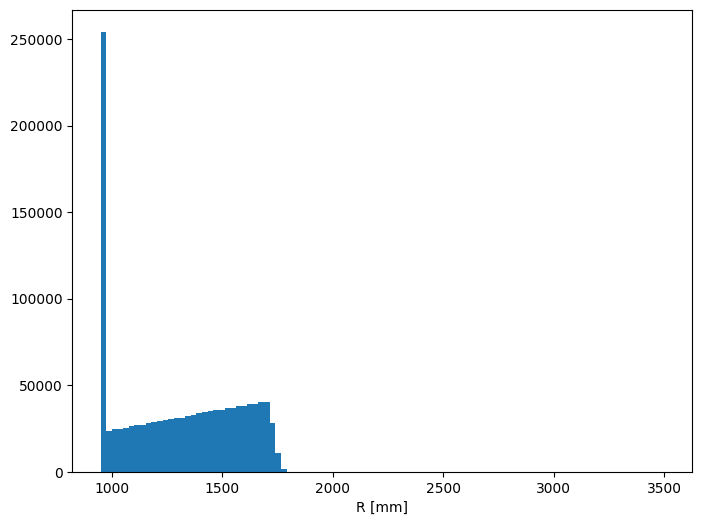

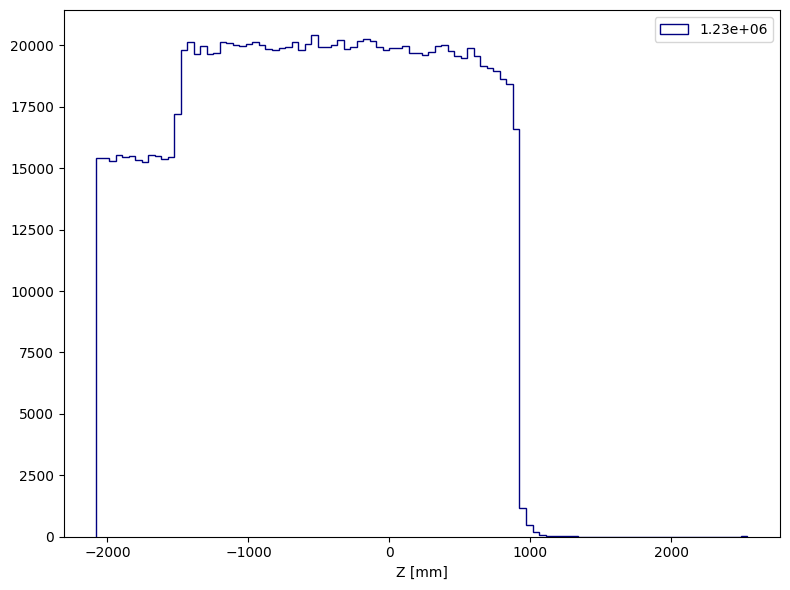

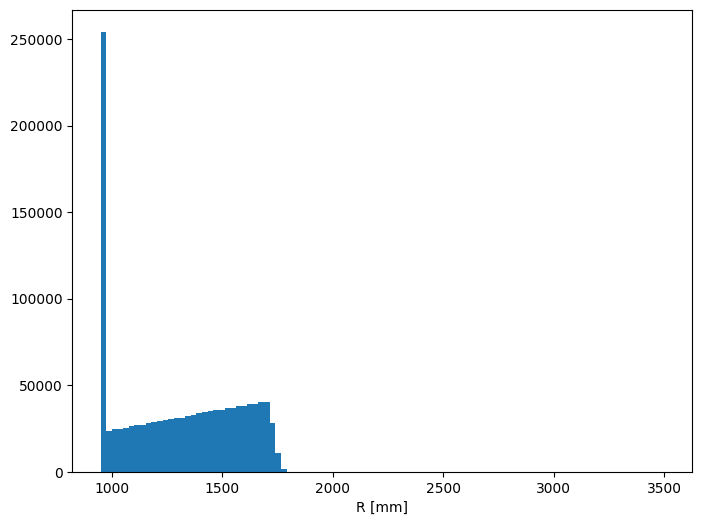

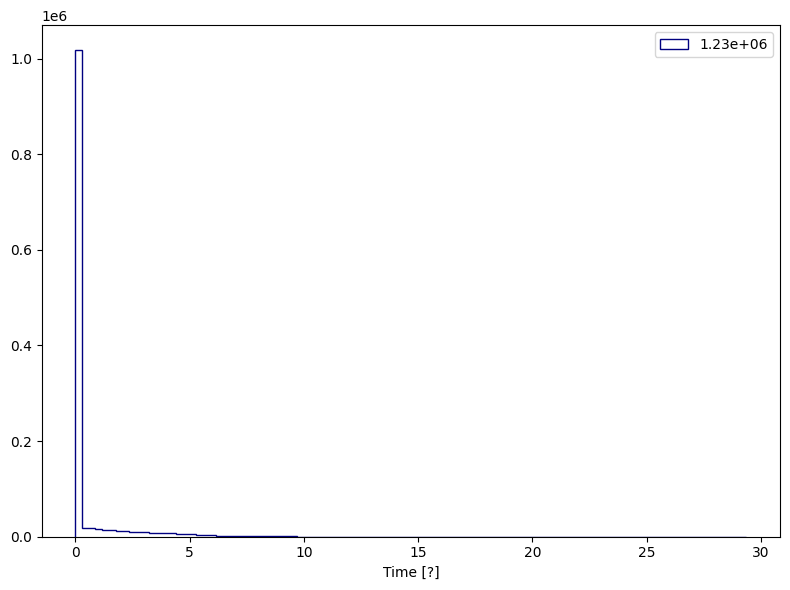

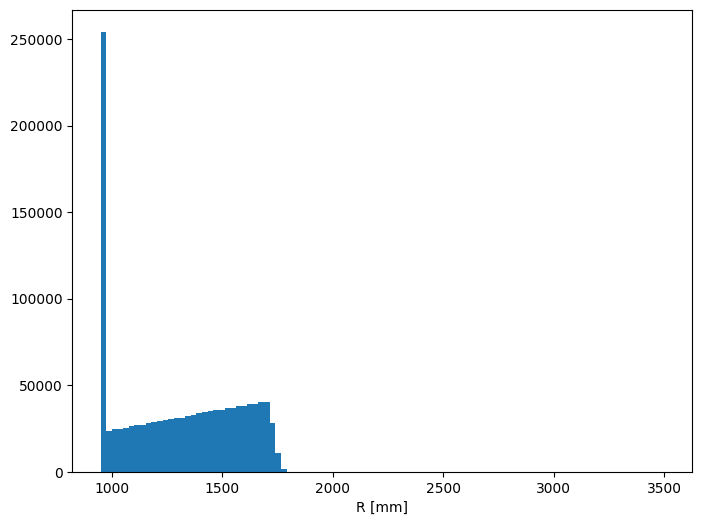

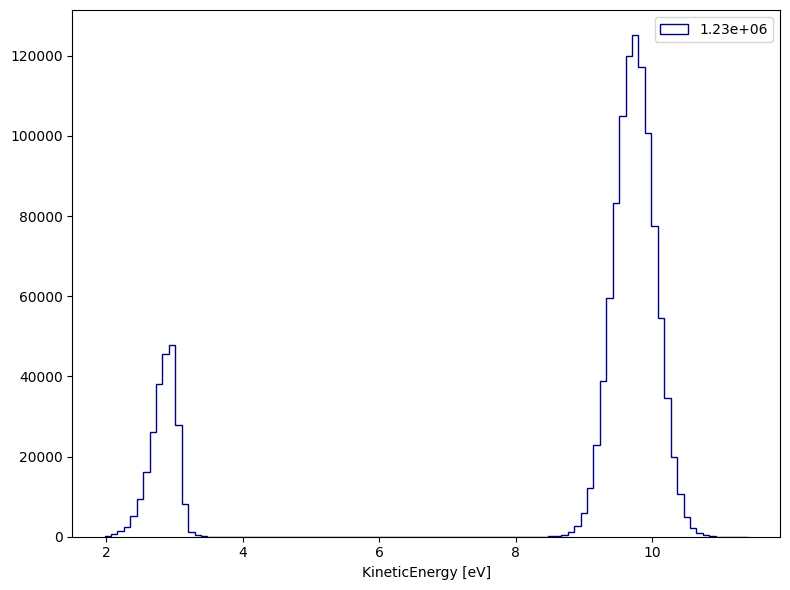

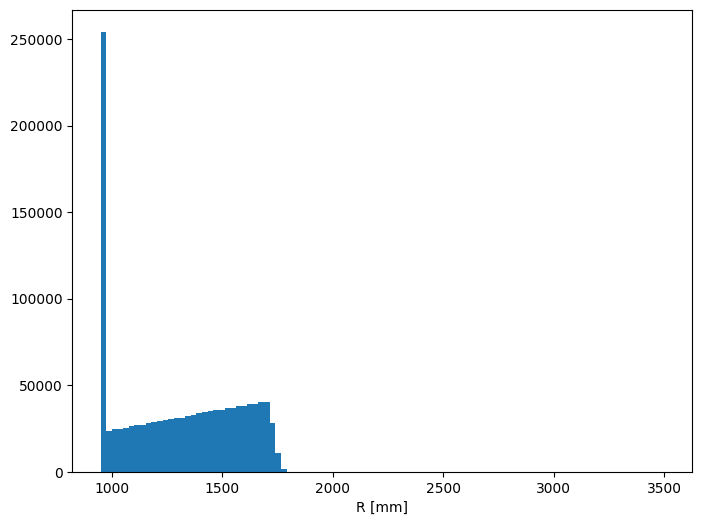

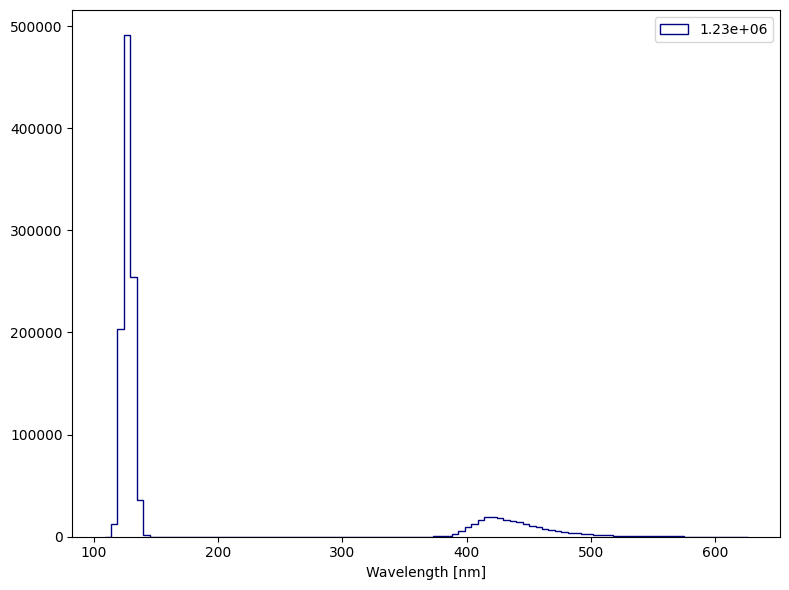

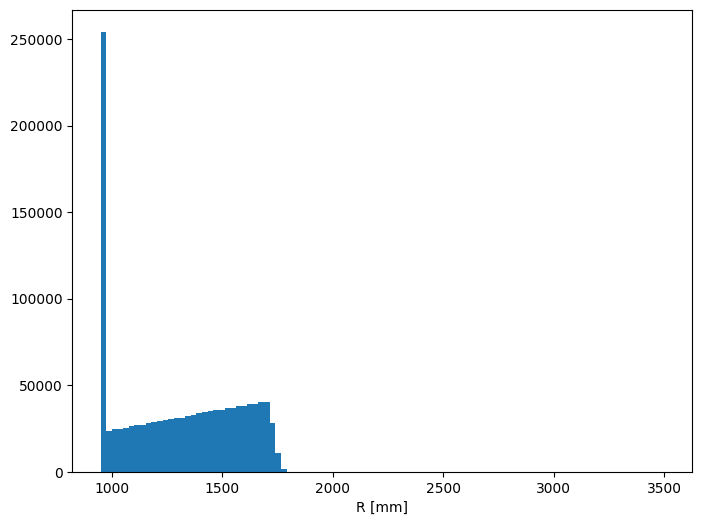

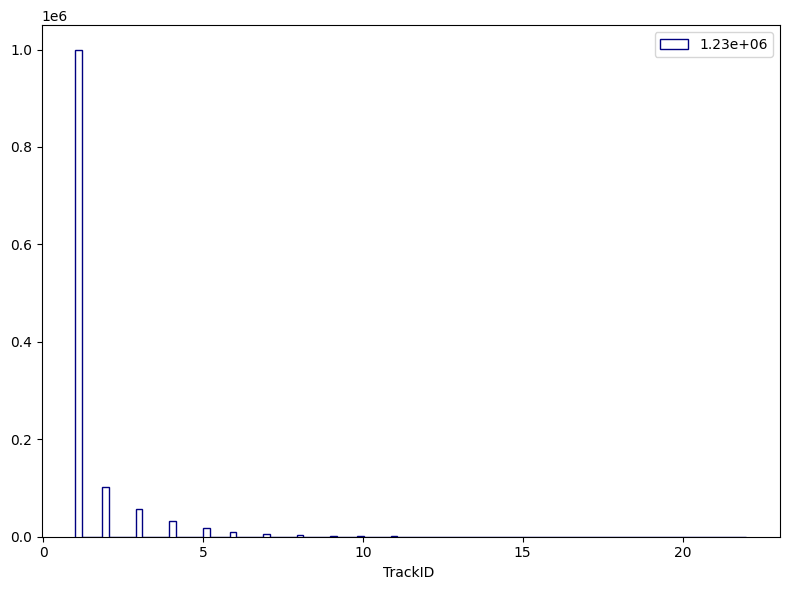

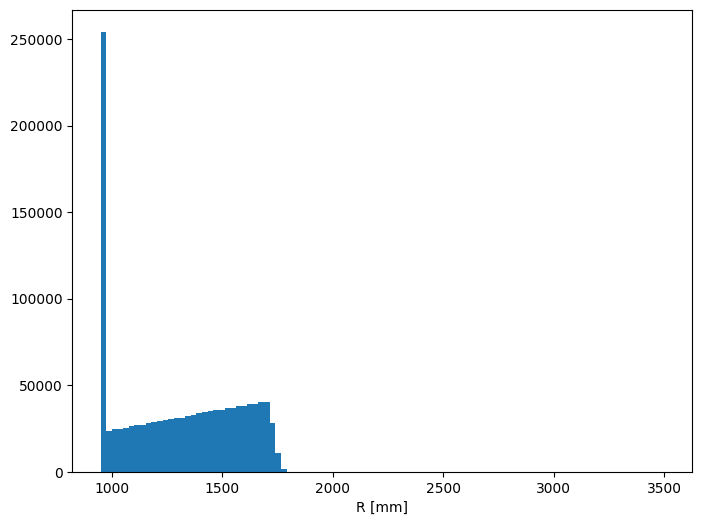

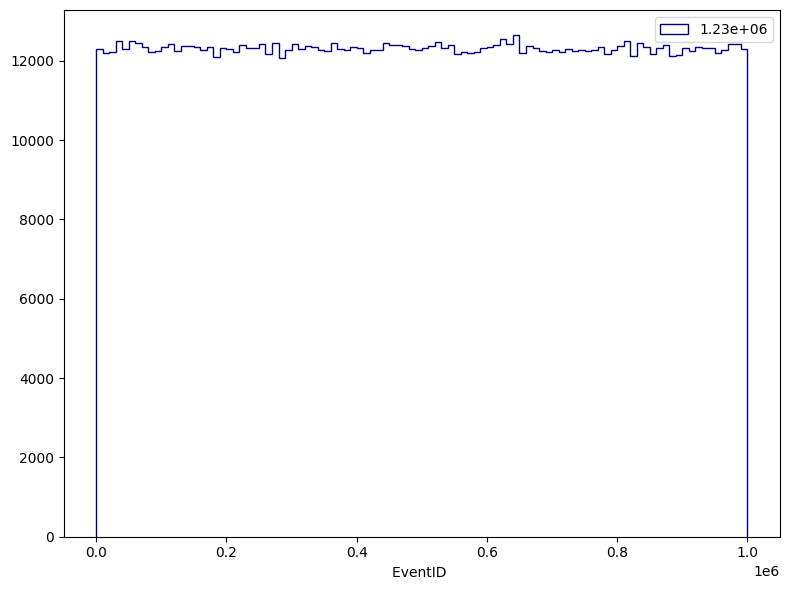

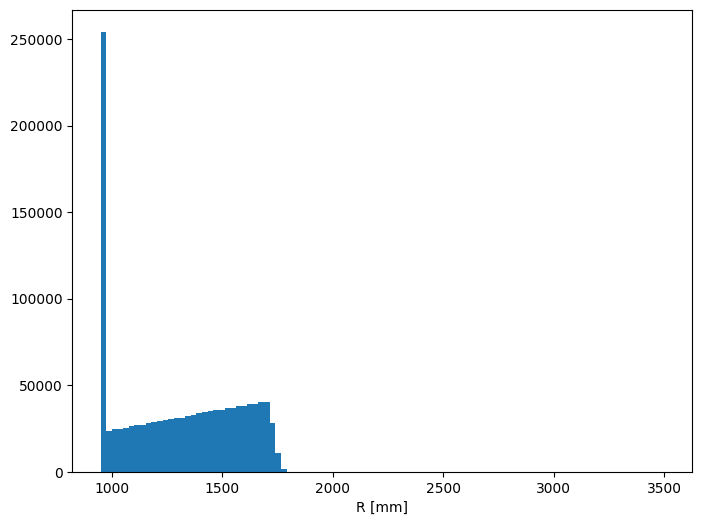

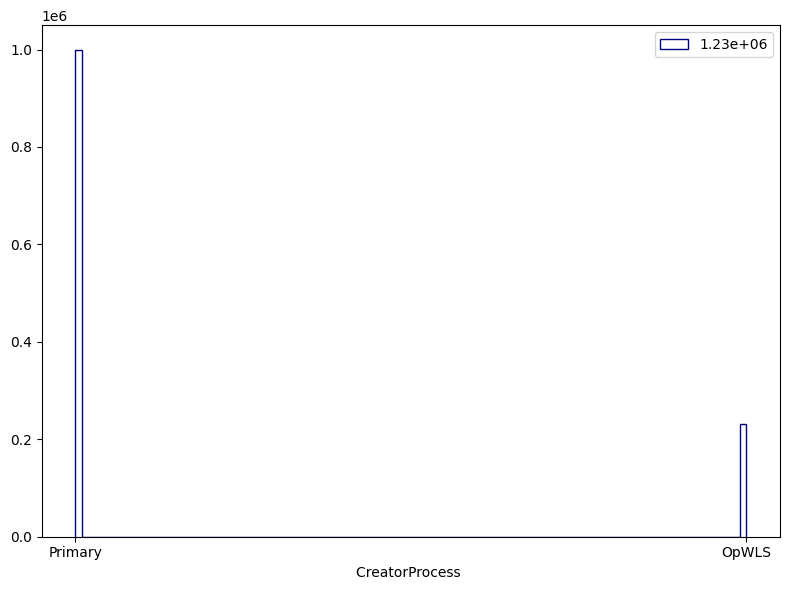

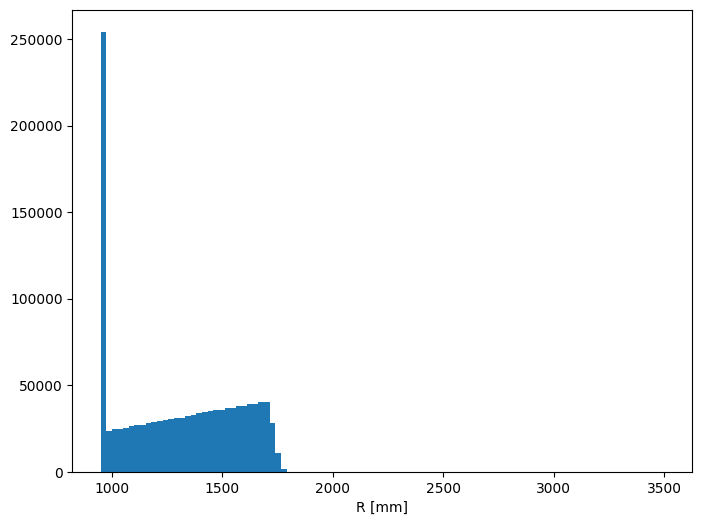

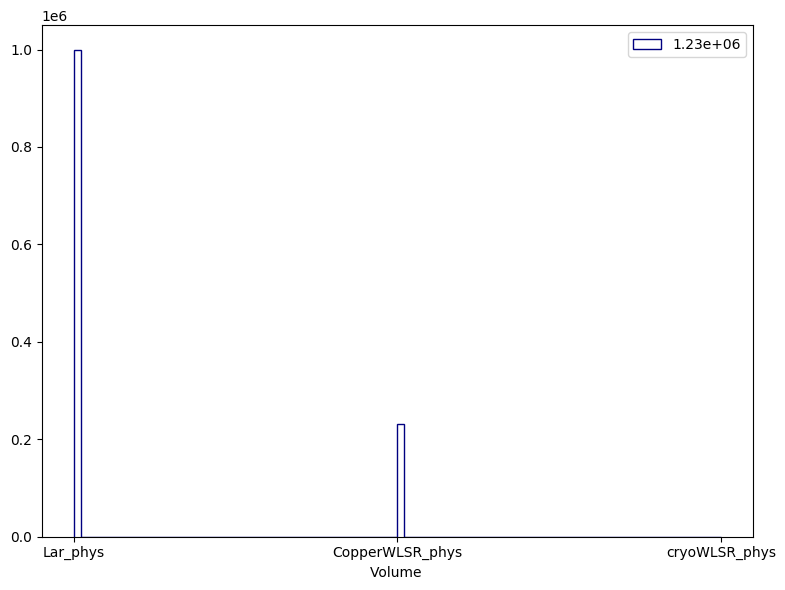

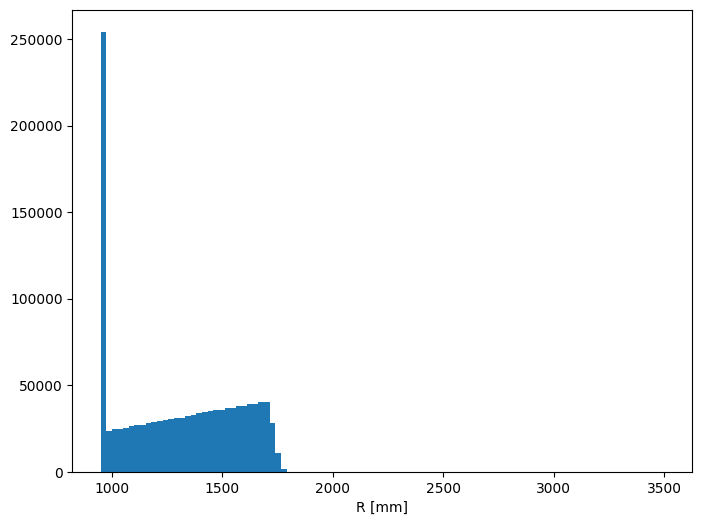

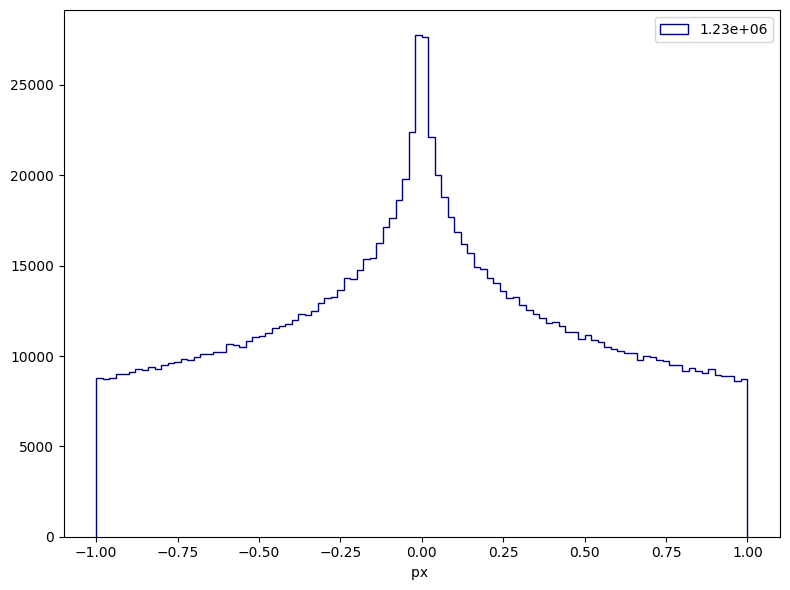

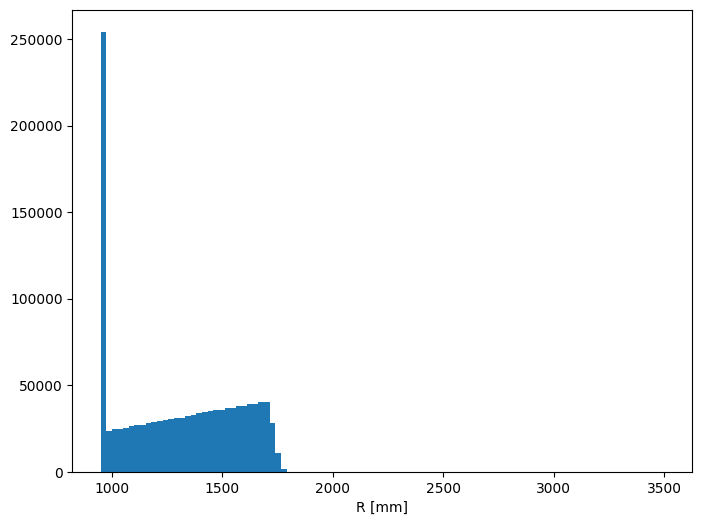

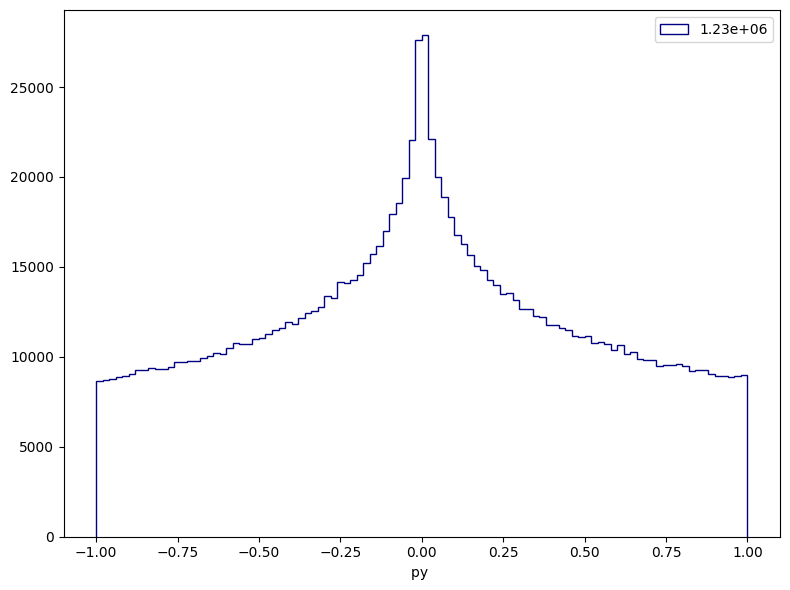

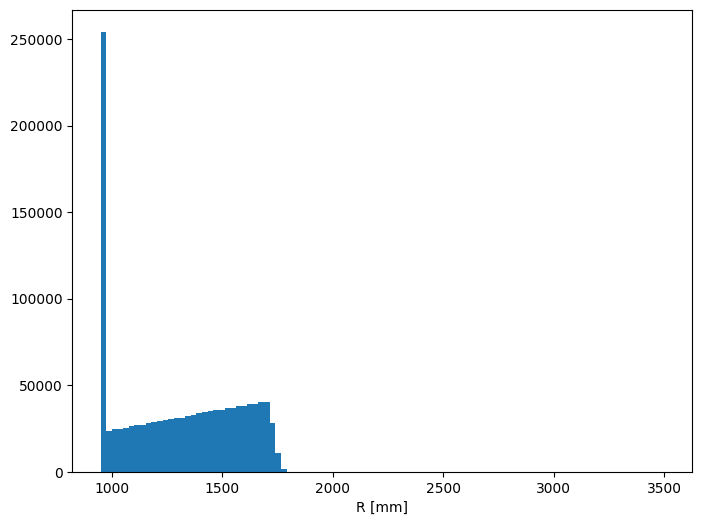

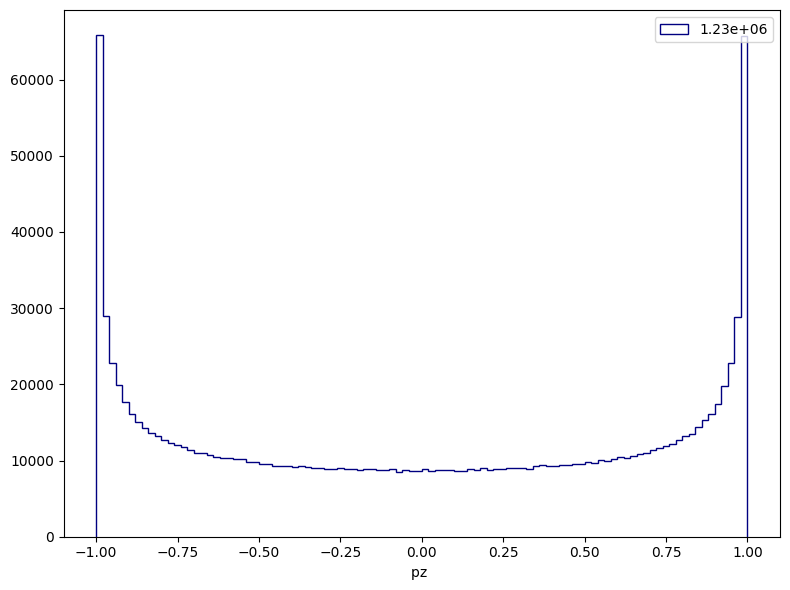

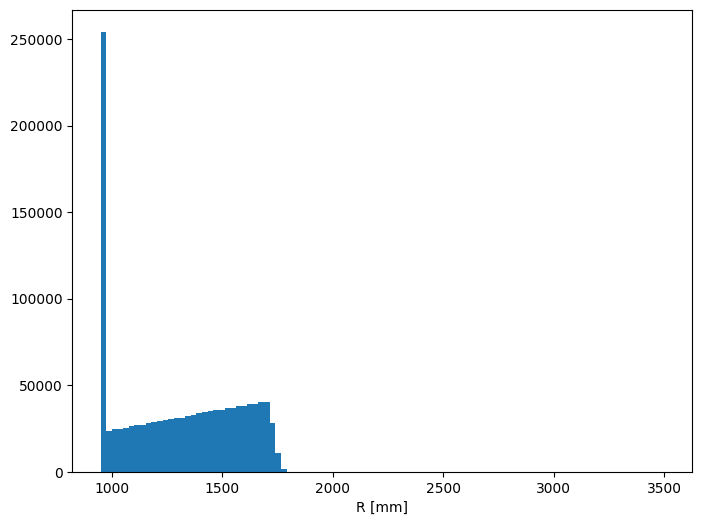

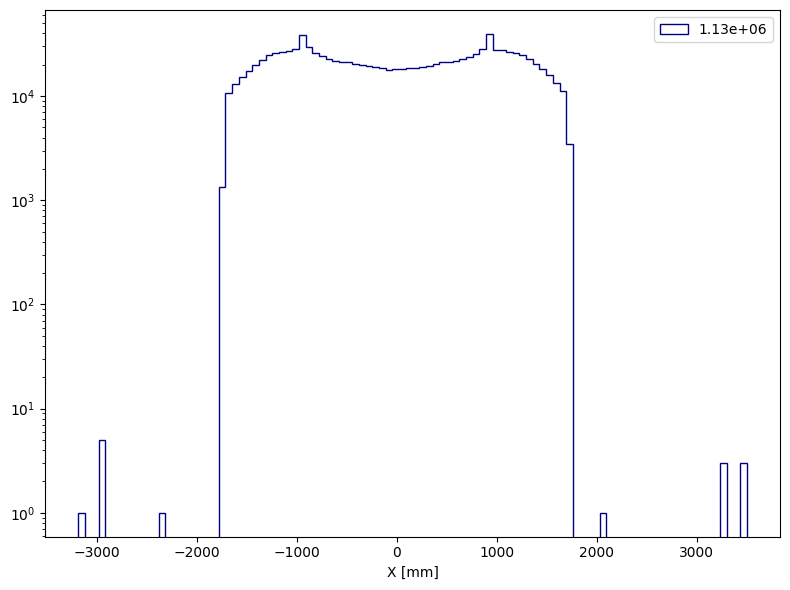

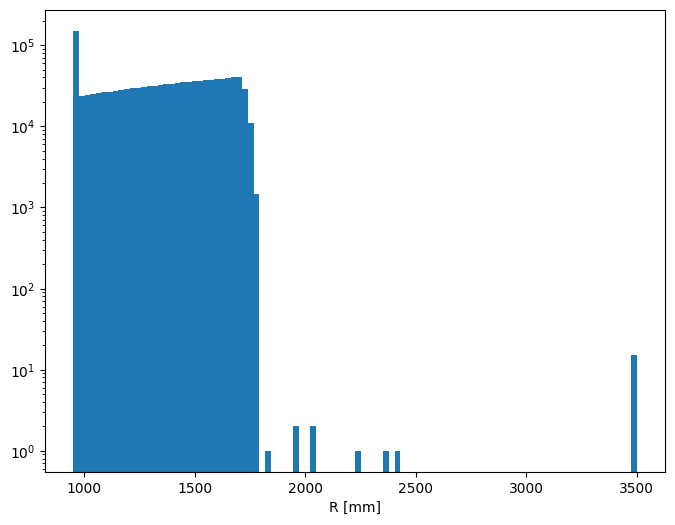

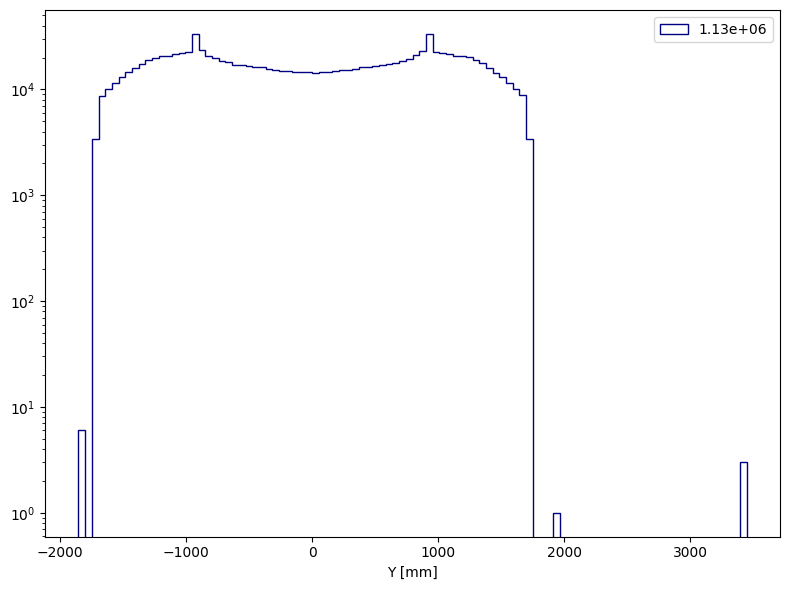

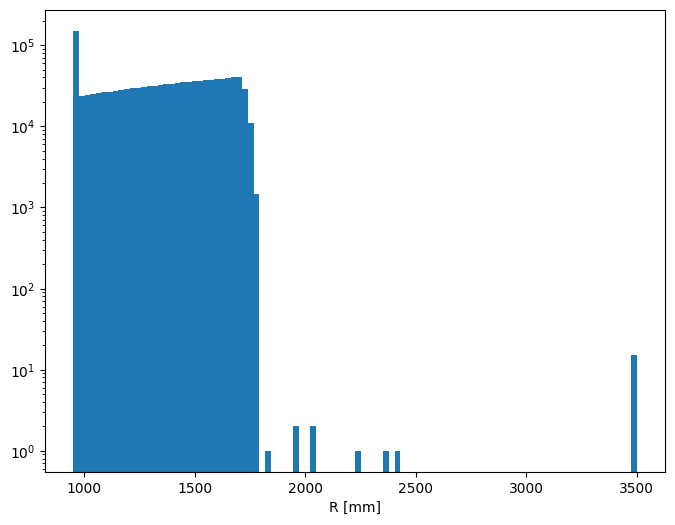

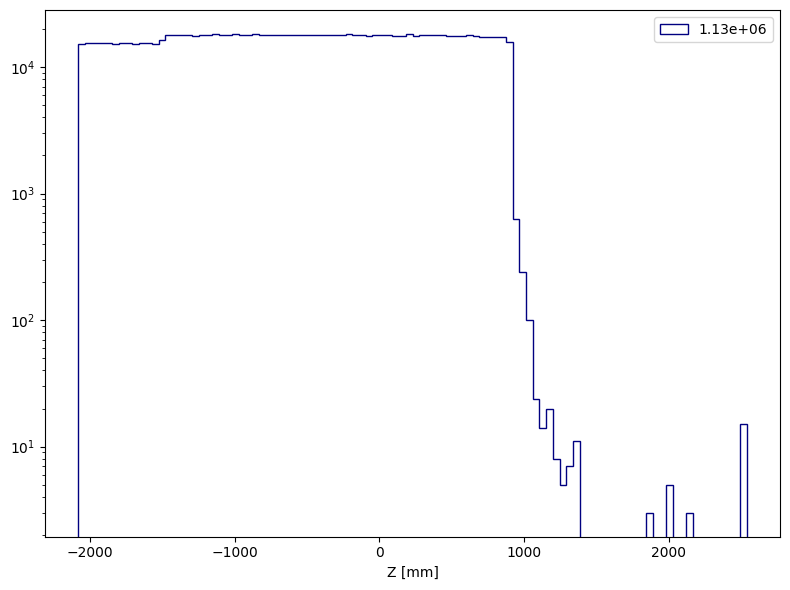

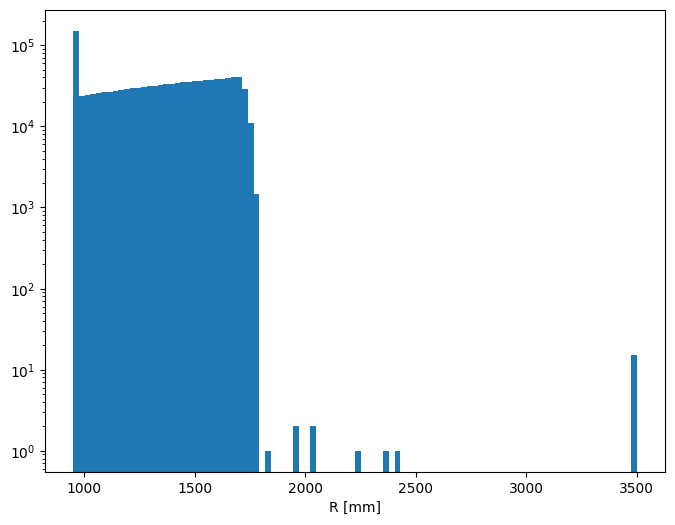

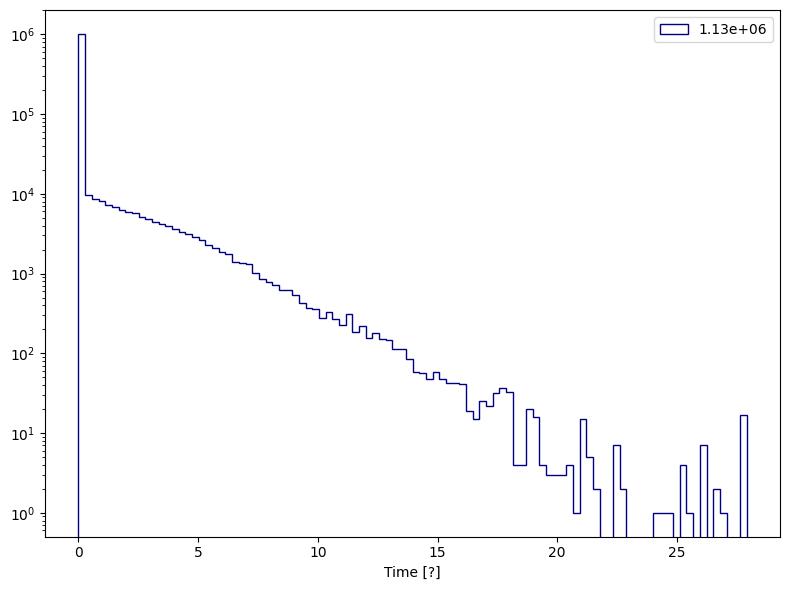

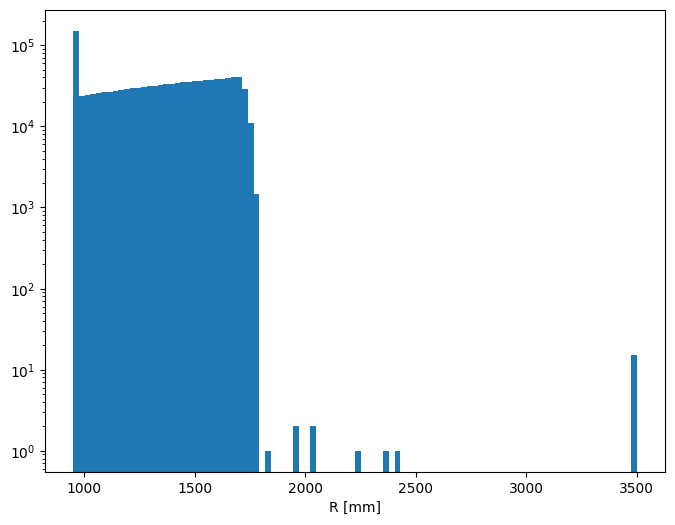

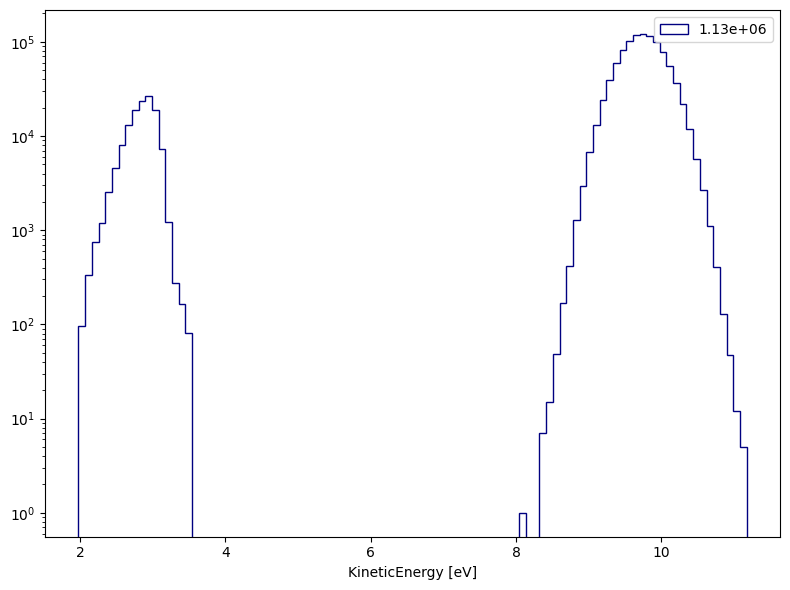

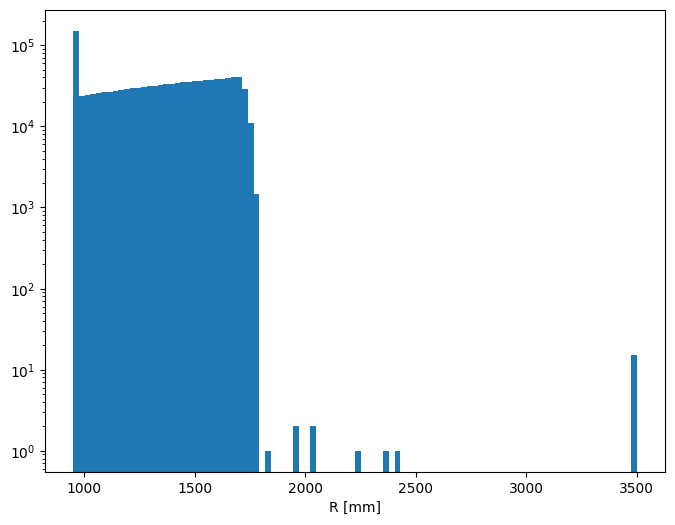

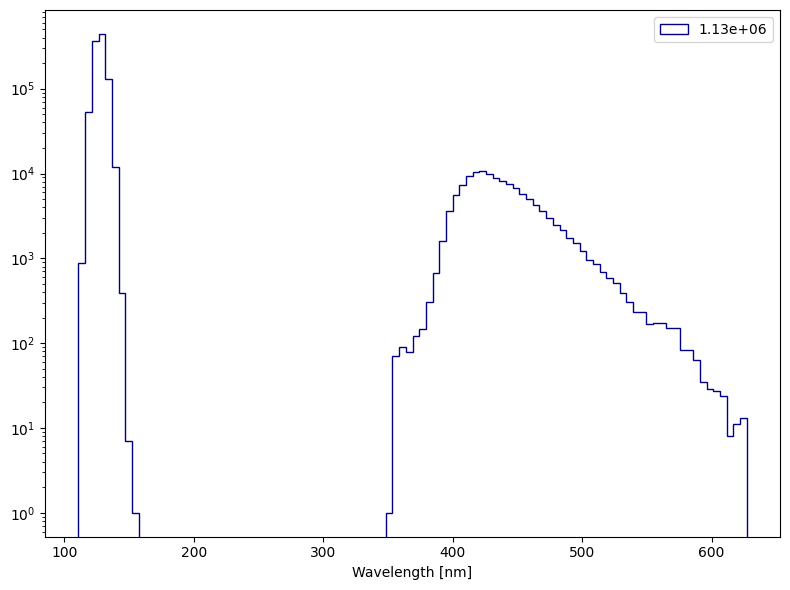

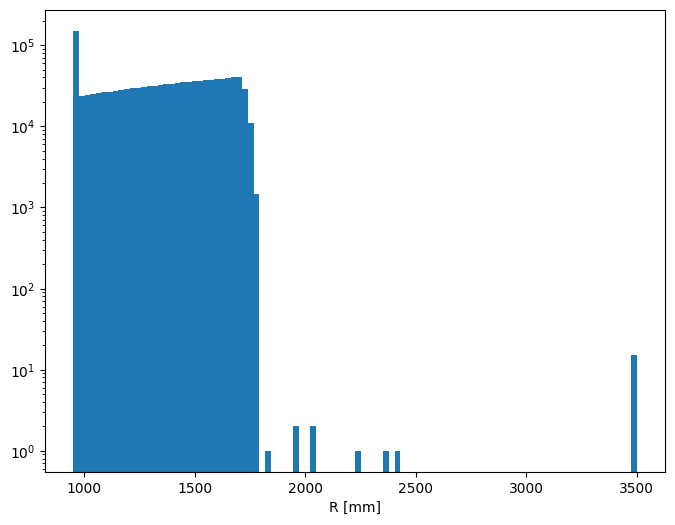

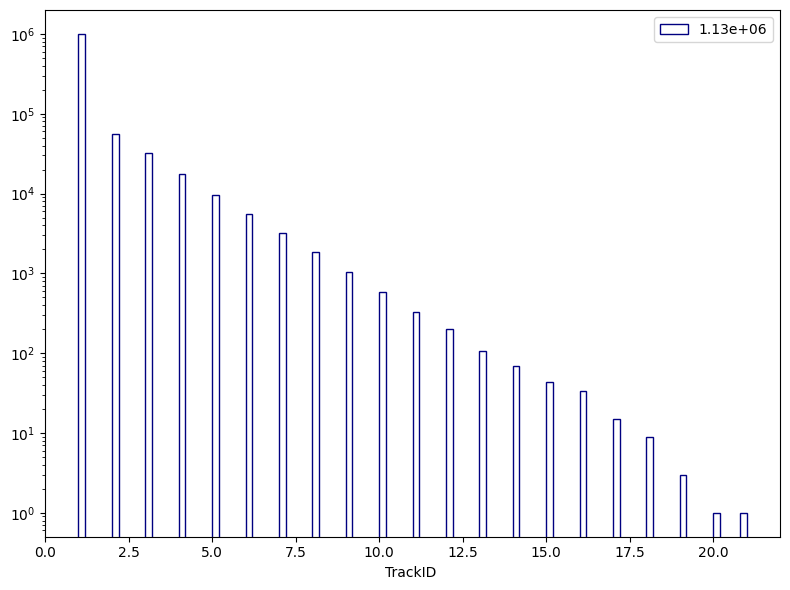

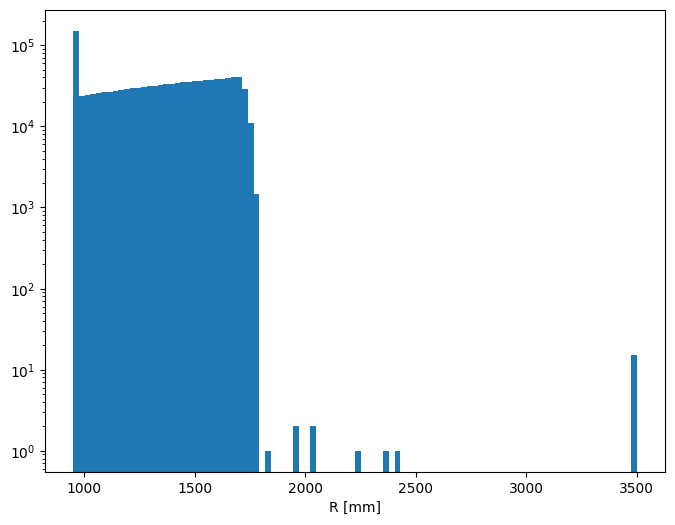

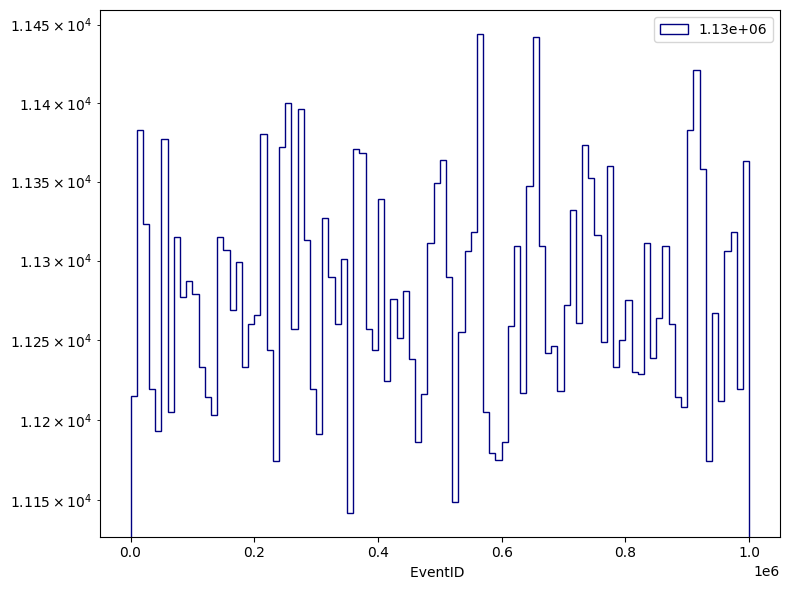

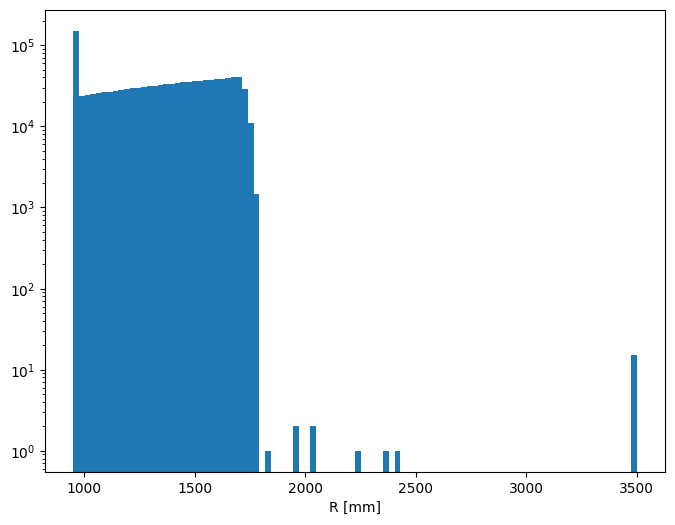

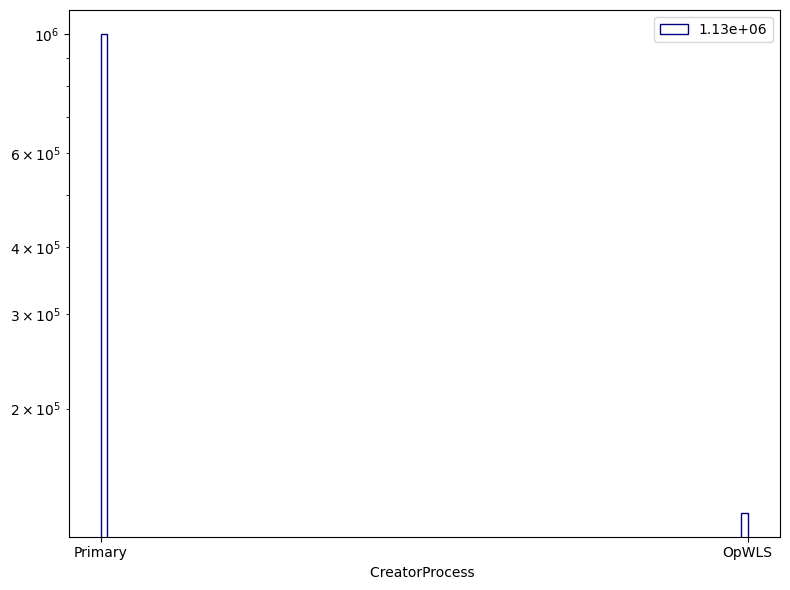

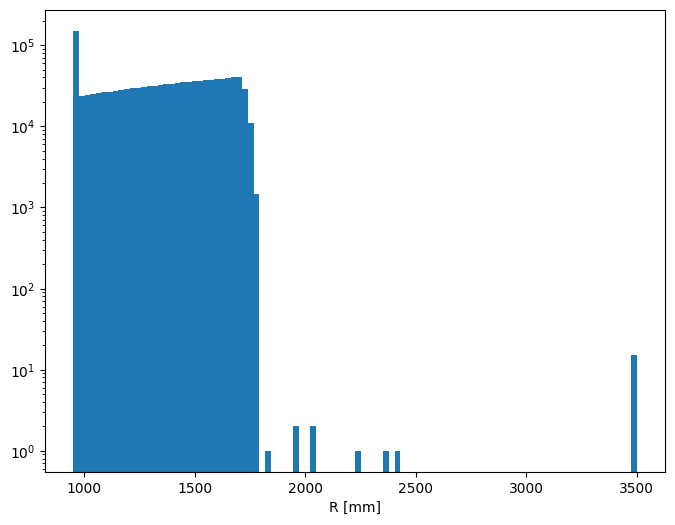

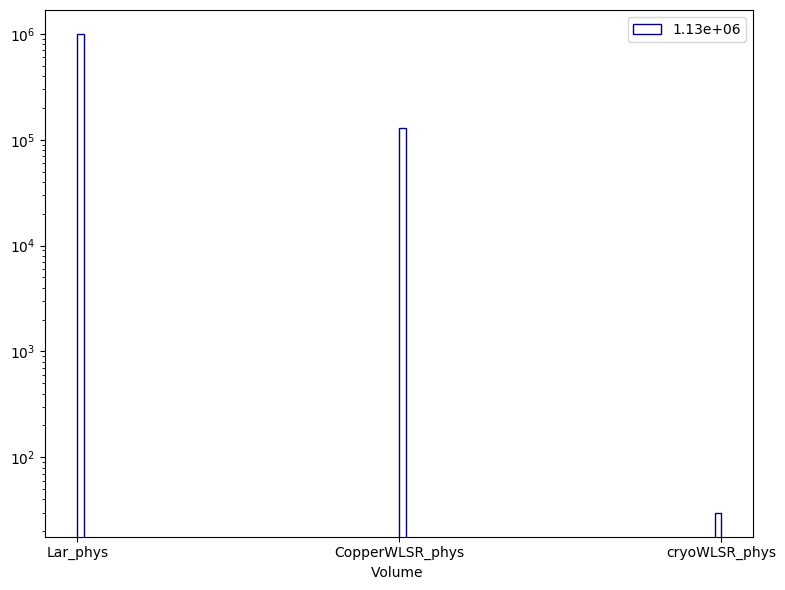

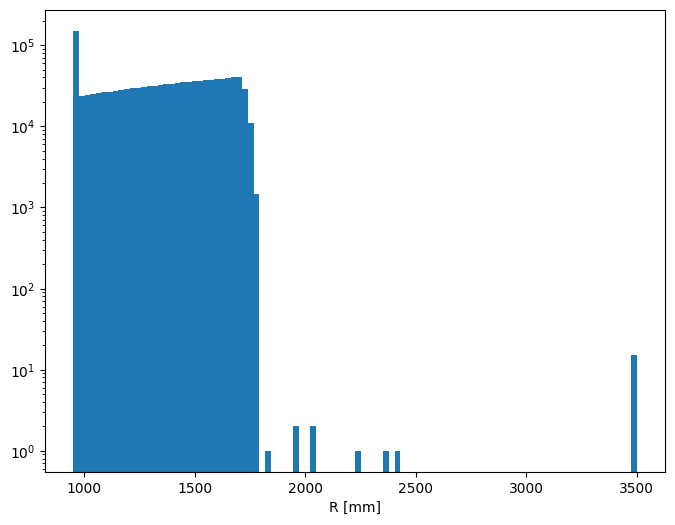

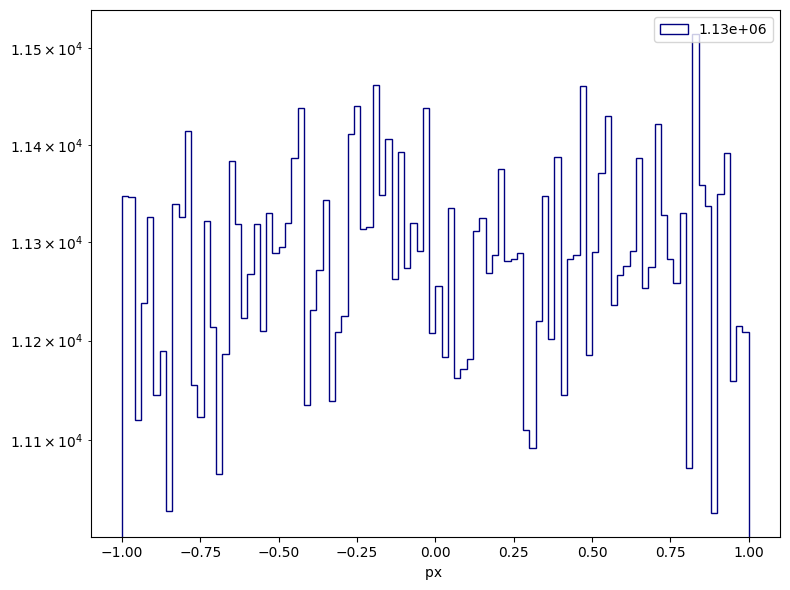

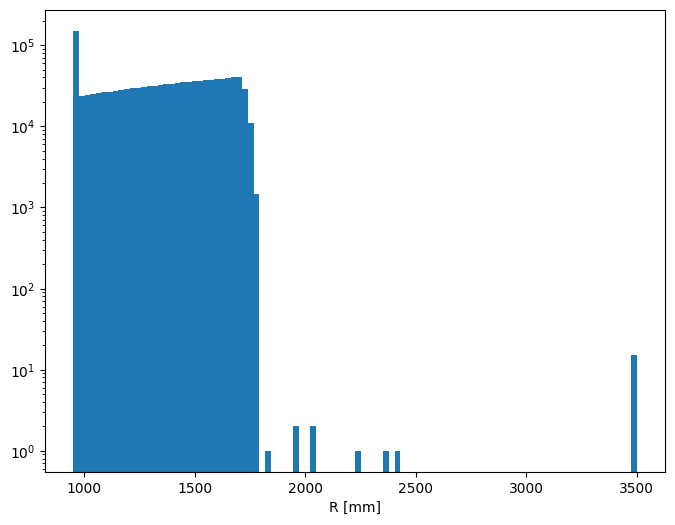

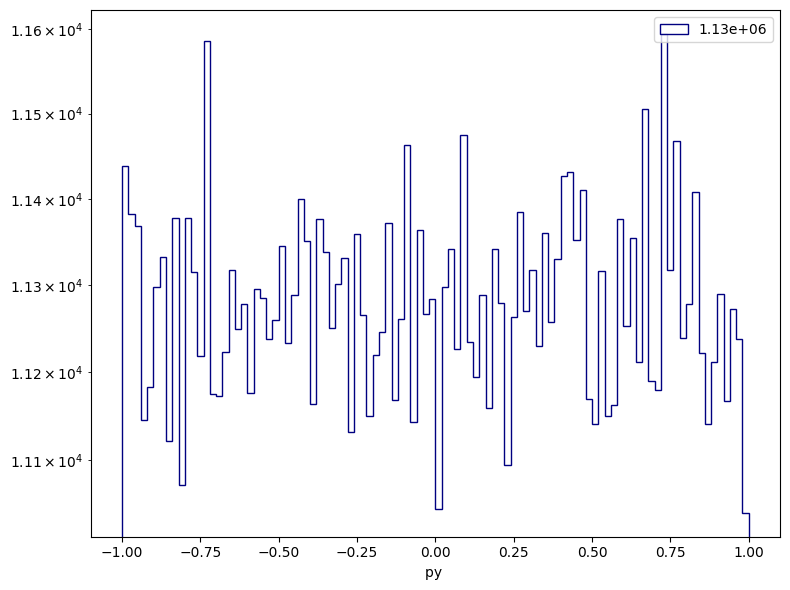

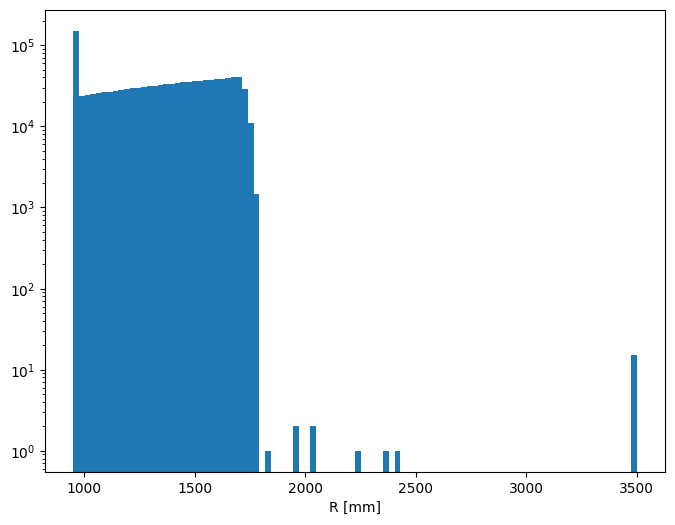

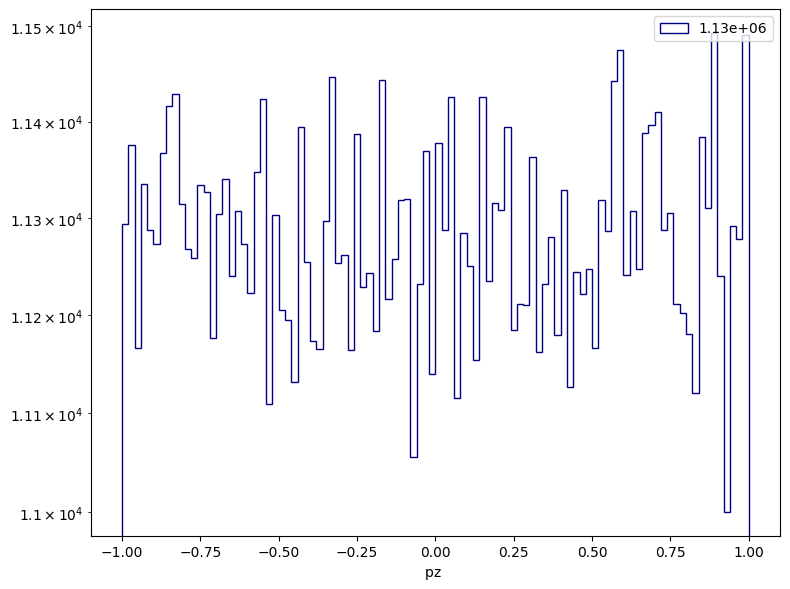

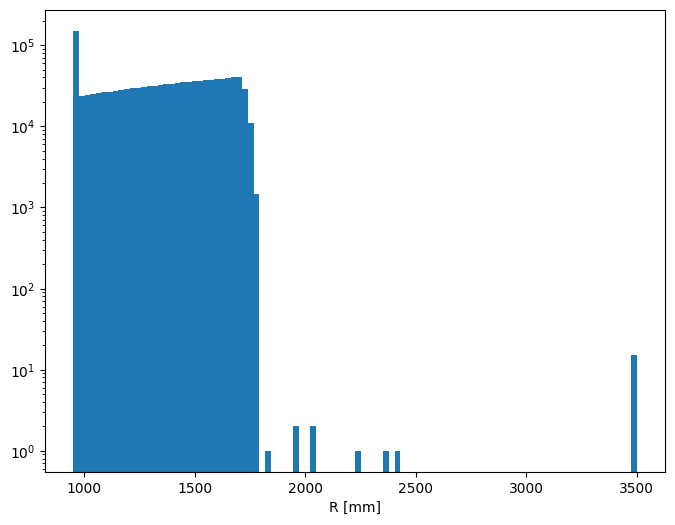

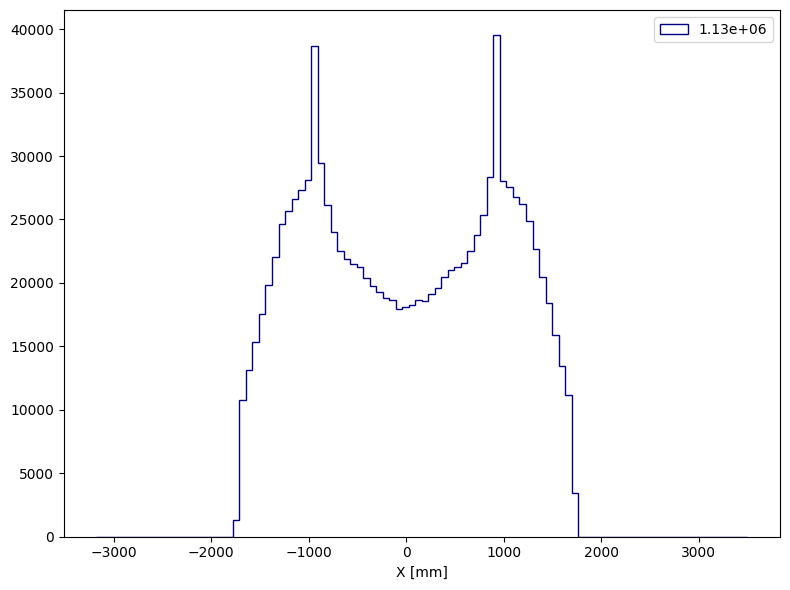

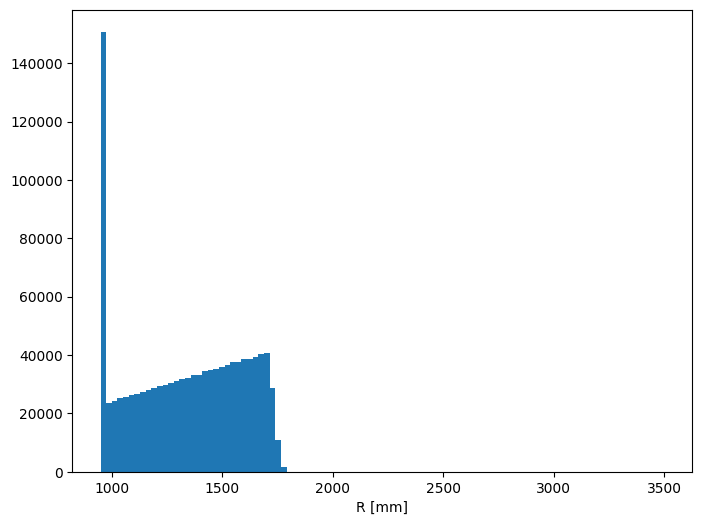

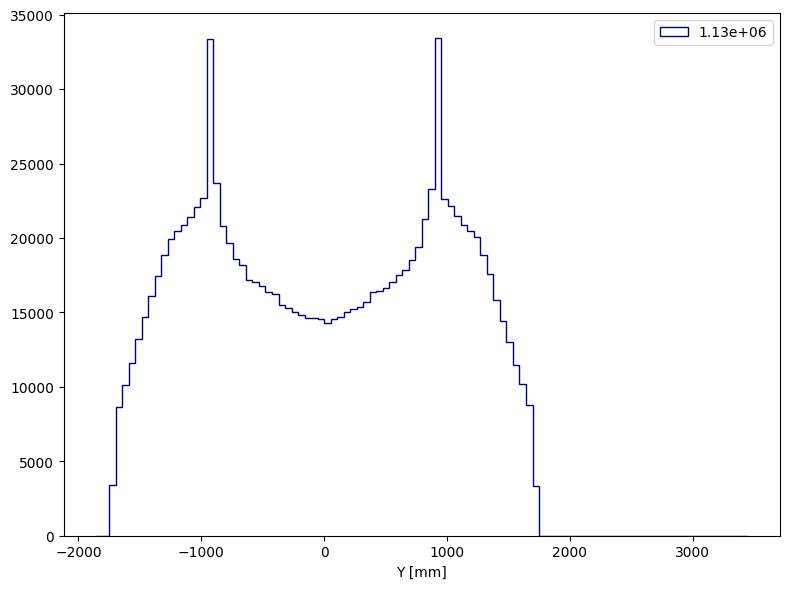

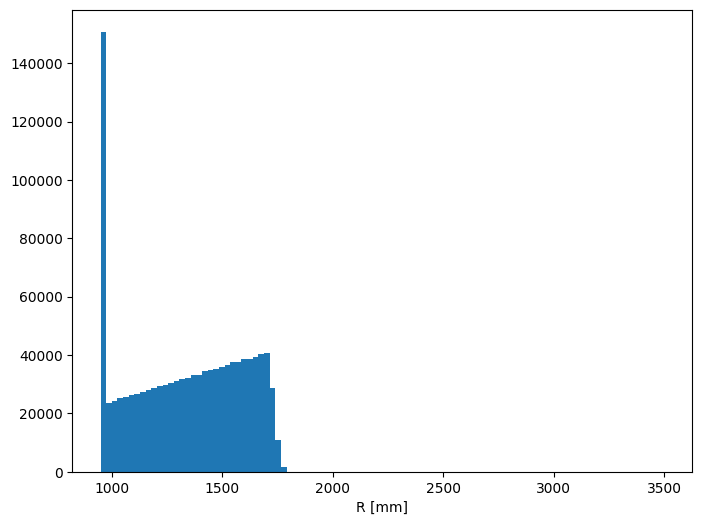

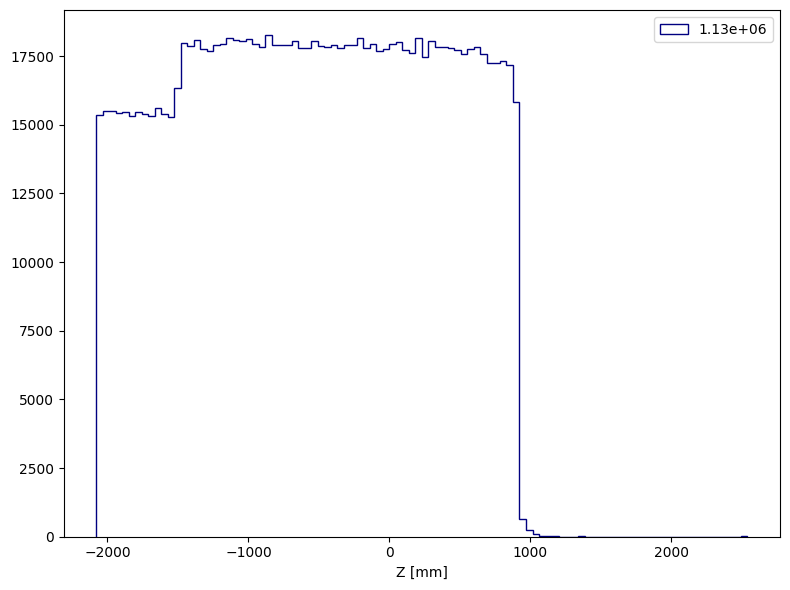

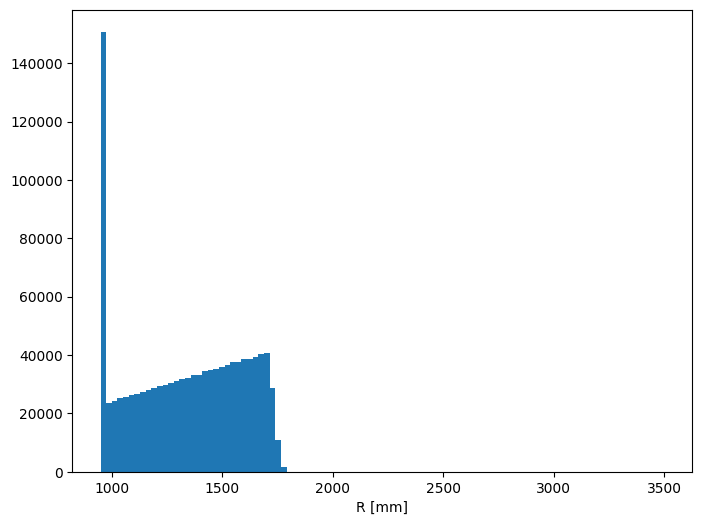

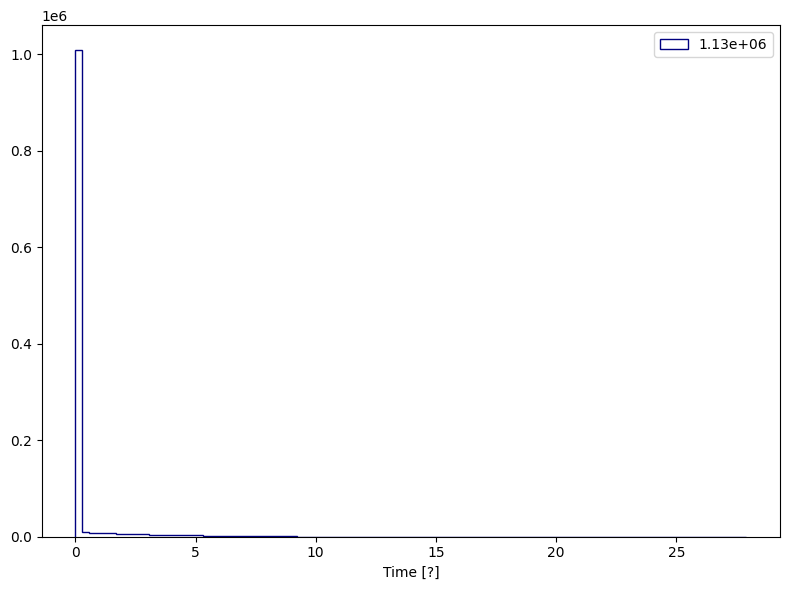

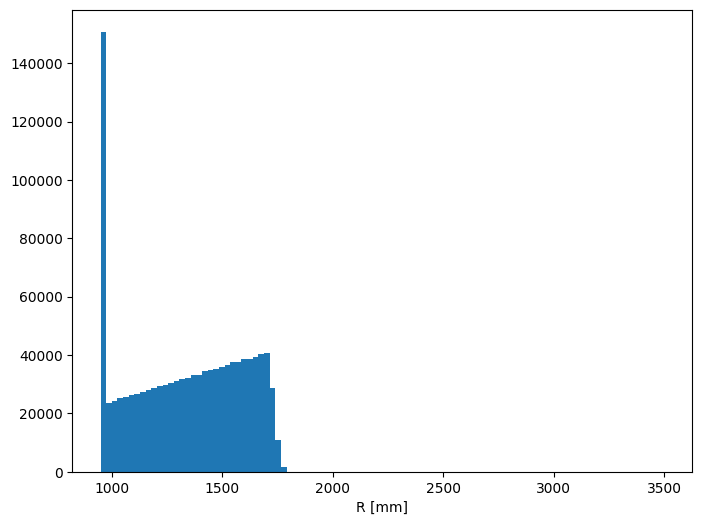

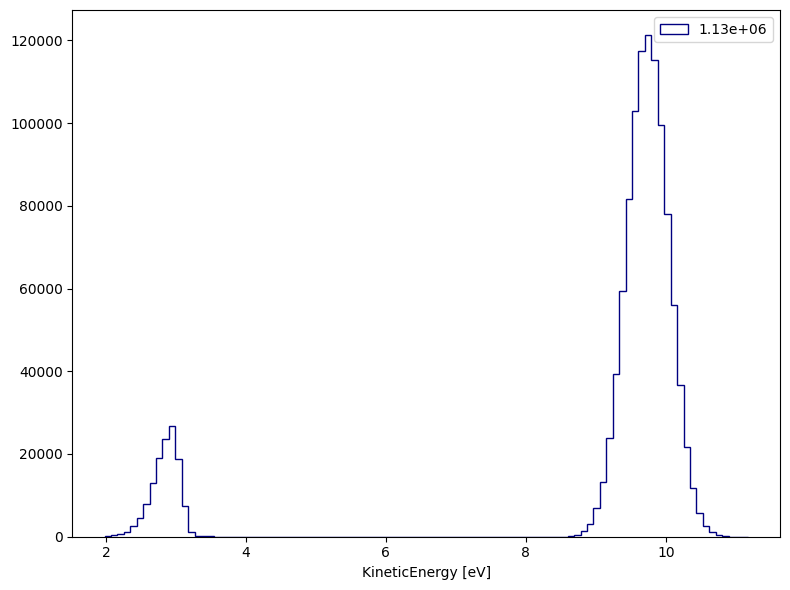

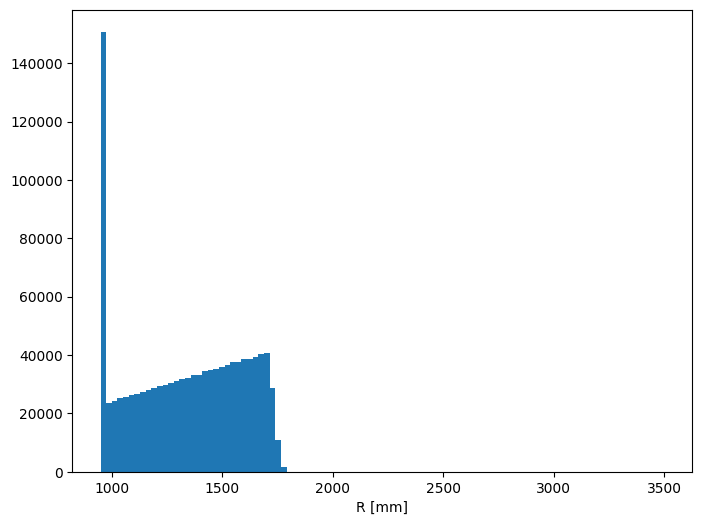

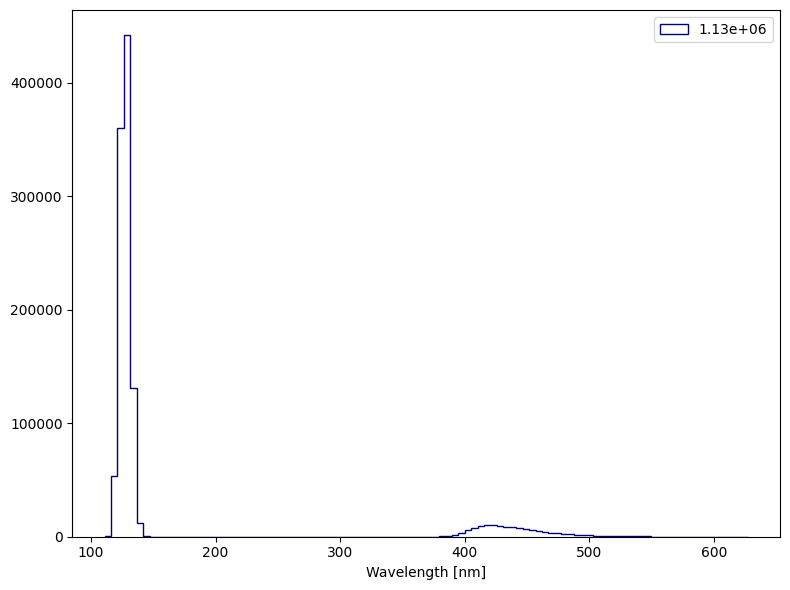

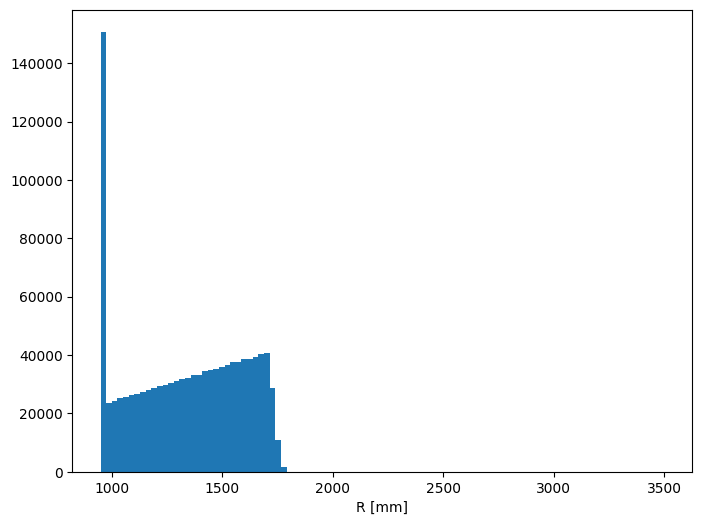

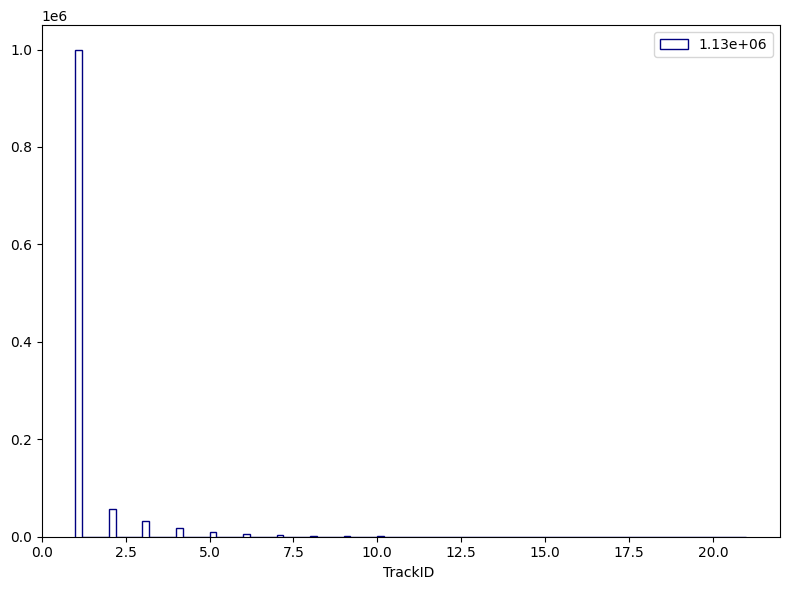

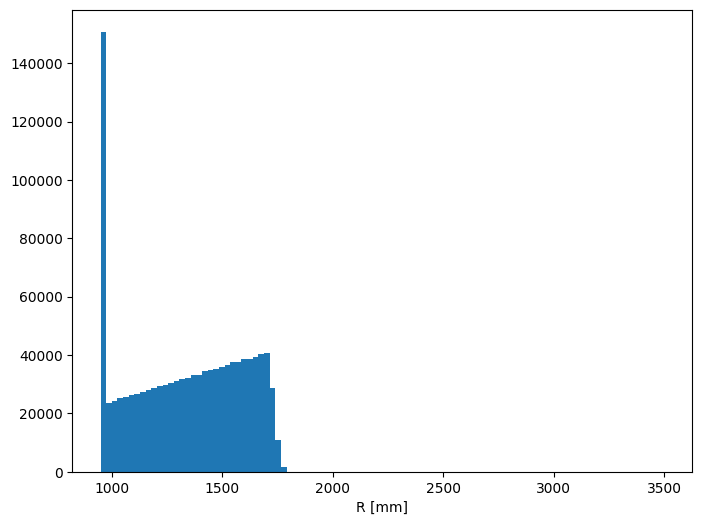

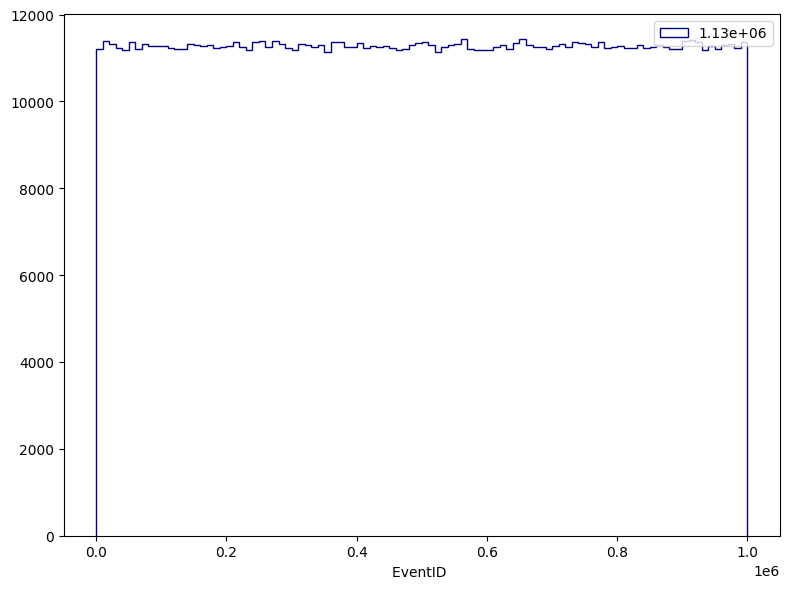

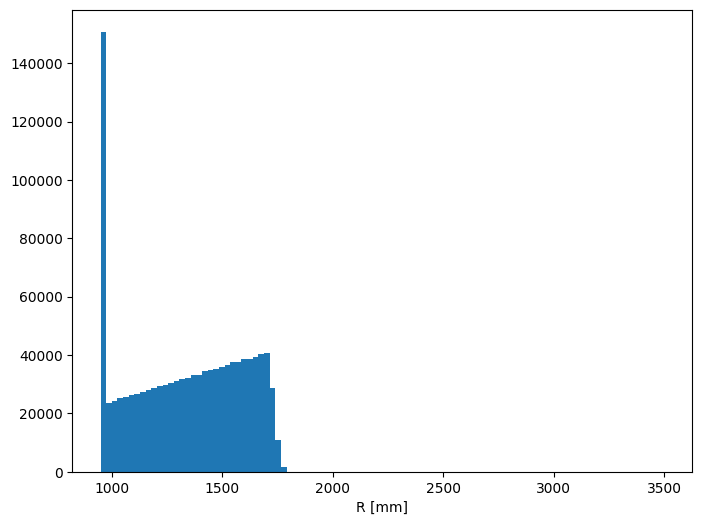

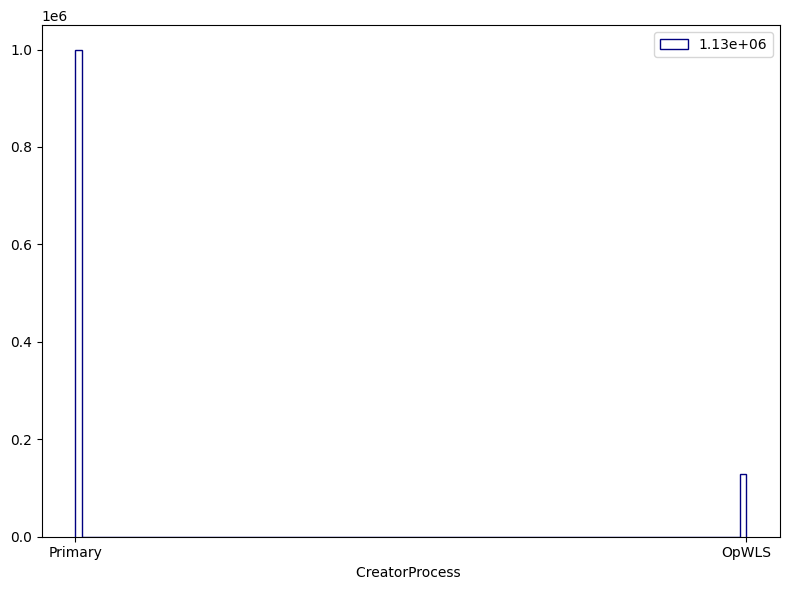

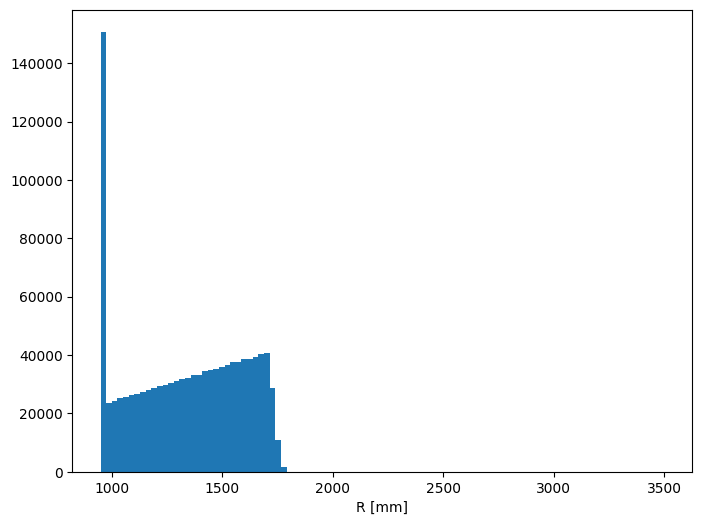

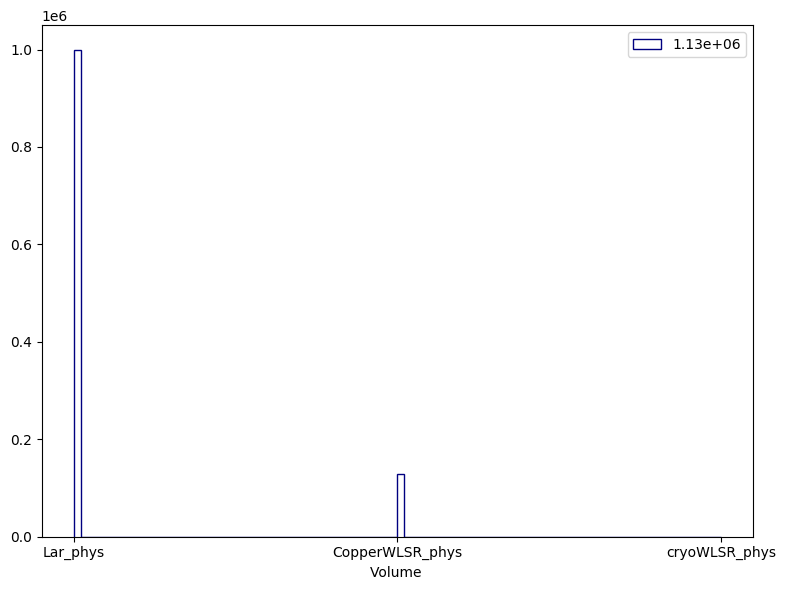

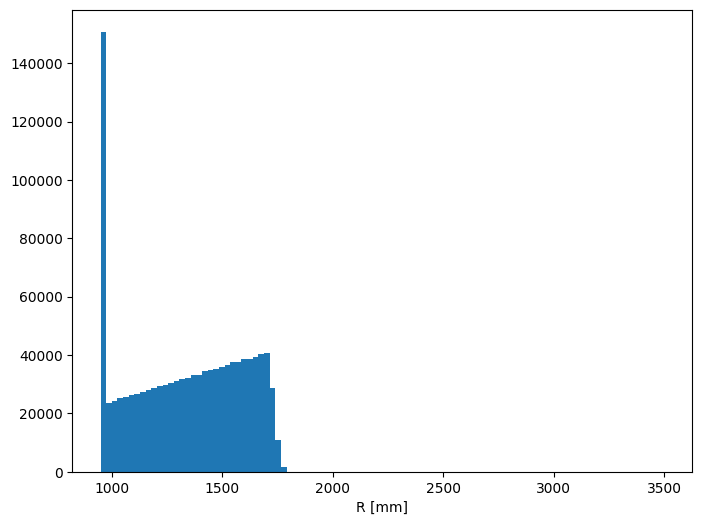

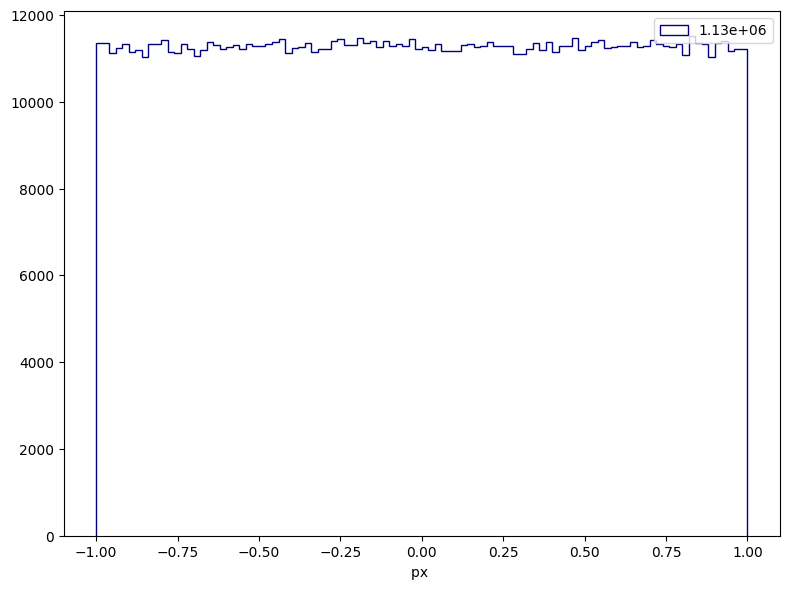

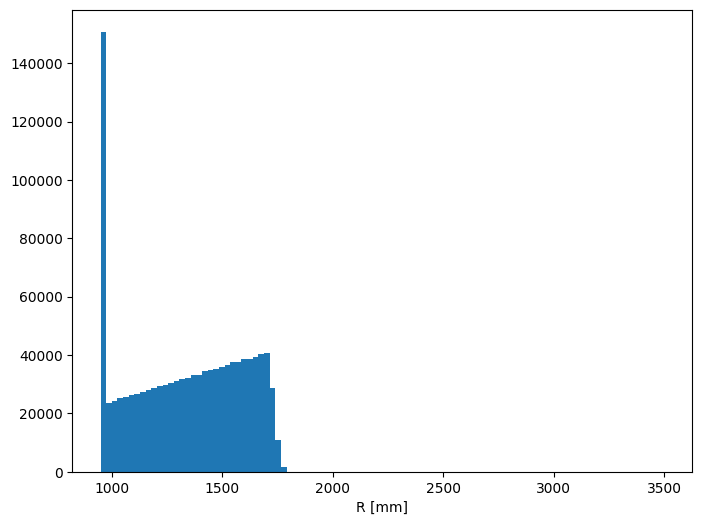

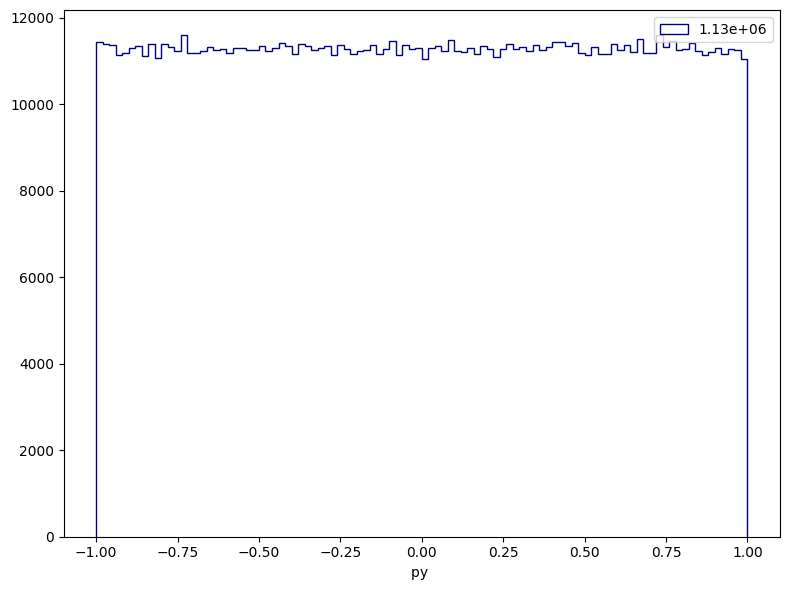

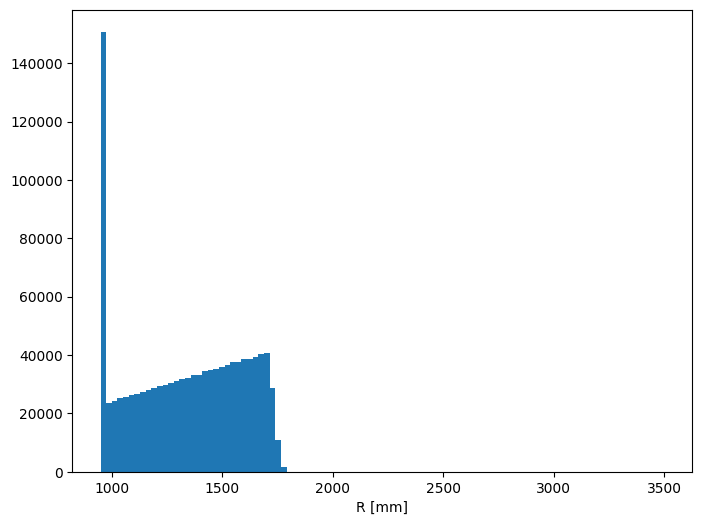

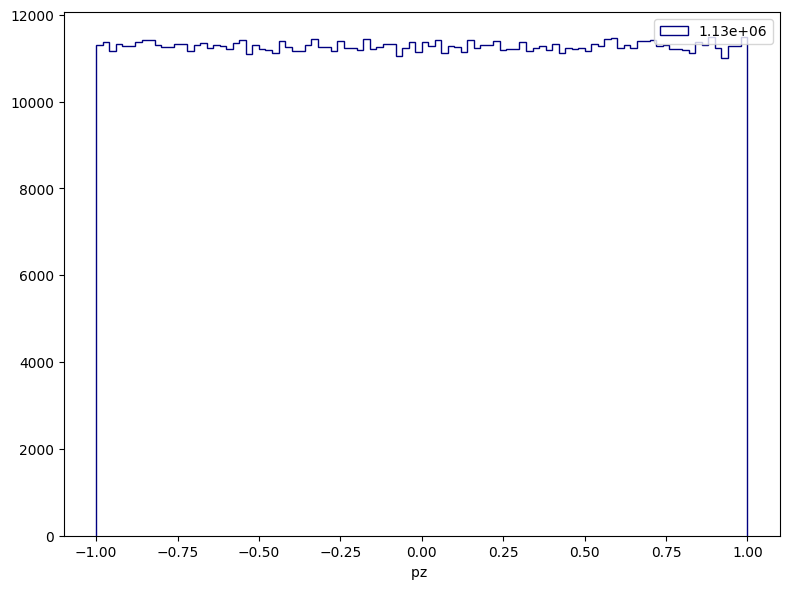

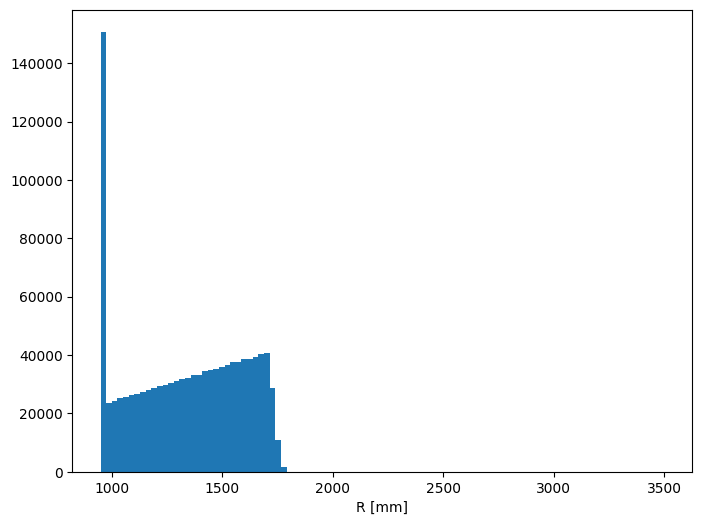

In [117]:
for file in ["old_file", "new_file", "corrected_file"]:

    tf = uproot.open(files[file])["OpticsTracks"]

    df = pd.DataFrame()

    for x in tqdm(tf.keys()):
        df[x] = tf[x].array(library="np")


    directory = file.split("_")[0]

    for scale in ["log", "linear"]:
        for key in df.keys():
            plt.figure(figsize = (8,6))
            plt.hist(df[key], bins = 100, histtype = "step", color = "navy", label = "{:.2e}".format(len(df[key])))
            plt.yscale(scale)
            plt.xlabel(f"{key} " + units[key])
            plt.tight_layout()
            plt.legend()
            plt.savefig(f"opmap_sanity/{directory}/tracklevel_{key}_{scale}.pdf")
            plt.savefig(f"opmap_sanity/{directory}/tracklevel_{key}_{scale}.png")
            
    
            plt.figure(figsize = (8,6))
            plt.hist(np.sqrt(np.power(df.X,2) + np.power(df.Y,2)), bins = 100)
            plt.xlabel("R [mm]")
            plt.yscale(scale)
            plt.savefig(f"opmap_sanity/{directory}/tracklevel_R_{scale}.pdf")
            plt.savefig(f"opmap_sanity/{directory}/tracklevel_R_{scale}.png")

# Generated optical maps

In [9]:
# from index to z coordinate
def compute_z(column, xbins, ybins, zmin):

    z = np.floor((column/xbins/ybins).values)
    
    return (z*2+zmin + 1)


# from index to y coordinate
def compute_y(column, xbins, ybins, ymin):
    
    y = np.floor((column%(xbins*ybins)/xbins).values)
    
    return (y*2+ymin +1)


# from index to x coordinate
def compute_x(column, xbins, ybins, xmin, ymin):
    
    x = np.floor((column%(xbins*ybins)%xbins).values)
    
    return (x*2+xmin+1) #baseline
#    return (x*2 - xmin + ymin + 1)

                      #x, z  
def plot_map(opmap_df, a, b):

    df = opmap_df.groupby([a,b]).prob.mean().reset_index()

    # Determina le dimensioni della griglia, includendo il range negativo
    a_min, a_max = df[a].min(), df[a].max()
    b_min, b_max = df[b].min(), df[b].max()

    # Decidi il passo per discretizzare la griglia
    step_size = 2

    # Crea una griglia di indici basata su a e z discretizzati
    a_bins = np.arange(a_min, a_max + step_size, step_size)
    b_bins = np.arange(b_min, b_max + step_size, step_size)

    # Crea una matrice di zeri per la griglia
    grid = np.zeros((len(b_bins), len(a_bins)))

    # Mappatura dei valori su questa griglia
    for _, row in df.iterrows():
        # Trova l'indice più vicino per y e z
        a_idx = np.digitize(row[a], a_bins) - 1
        b_idx = np.digitize(row[b], b_bins) - 1

        # Aggiungi il valore nella posizione corrispondente della griglia
        grid[b_idx, a_idx] = row['prob']

    # Crea il grafico
    plt.imshow(grid, origin='lower', cmap='viridis', extent=(a_min, a_max, b_min, b_max), vmax = 0.5)
    plt.colorbar(label='prob')  # Aggiungi la barra dei colori
    plt.xlabel(a + " [mm]")
    plt.ylabel(b + " [mm]")
#    plt.xlim([0,350])
#    plt.ylim([-454, 254])

In [10]:
maps = ["outer", "upperouter", "lowerouter", "inner", "upperinner", "lowerinner", "subrt"]

xbins = {"outer" : 92,  "upperouter" : 92,   "lowerouter" : 92,   "inner" : 46,   "upperinner" : 49, "lowerinner" : 49,  "subrt" : 25}
ybins = {"outer" : 84,  "upperouter" : 84,   "lowerouter": 84,    "inner" : 41,   "upperinner" : 46, "lowerinner" : 91,  "subrt" : 48}
zbins = {"outer" : 151, "upperouter" : 76+5, "lowerouter": 118+5, "inner" : 151,  "upperinner" : 76, "lowerinner" : 118, "subrt" : 30}

x_ranges = {"outer" : [-92, 92],  "upperouter" : [-92, 92],   "lowerouter" : [-92, 92],   "inner" : [-46, 46], "upperinner" : [-49, 49],  "lowerinner" : [-49, 49],  "subrt" : [-25, 25]}
y_ranges = { "outer" : [182, 350], "upperouter" : [182, 350],   "lowerouter" : [182, 350],   "inner" : [90, 172],  "upperinner" : [90, 182],  "lowerinner" : [0, 182],     "subrt" : [0,96]}
z_ranges = { "outer" : [-209, 93], "upperouter" : [102-10, 254], "lowerouter" : [-454, -218], "inner" : [-209, 93], "upperinner" : [102, 254], "lowerinner" : [-454, -218], "subrt" : [-208, -146]}

#for m in maps:
#    print(f"{m}\t\t", xbins[m] * ybins[m] * zbins[m])
    

In [11]:
# change this path to the directory to the ones containing optical maps files
path = "/lfs/l1/legend/users/cbarton/simulations/campaigns/opticalmap/latestversions"

opmap_df = pd.DataFrame()

index = 0

for m in tqdm(maps):
    
    tmp_df = pd.DataFrame()
    tf = uproot.open(os.path.join(path, m + "map.root"))["opmap"]
    
    tmp_df["index"]  = tf["index"].array(library="np")
    tmp_df["prob"]   = tf["prob"].array(library="np")
    
    tmp_df["x"] = compute_x(tmp_df.index, xbins[m], ybins[m], x_ranges[m][0], y_ranges[m][0])
    tmp_df["y"] = compute_y(tmp_df.index, xbins[m], ybins[m], y_ranges[m][0])
    tmp_df["z"] = compute_z(tmp_df.index, xbins[m], ybins[m], z_ranges[m][0])
    
    opmap_df = pd.concat([opmap_df, tmp_df])
    
    index = index + 1

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:06<00:00,  1.14it/s]


In [12]:
# remove voxels with probability == 0 for better visualization
opmap_df = opmap_df[opmap_df.prob > 0]

### 2D optical map

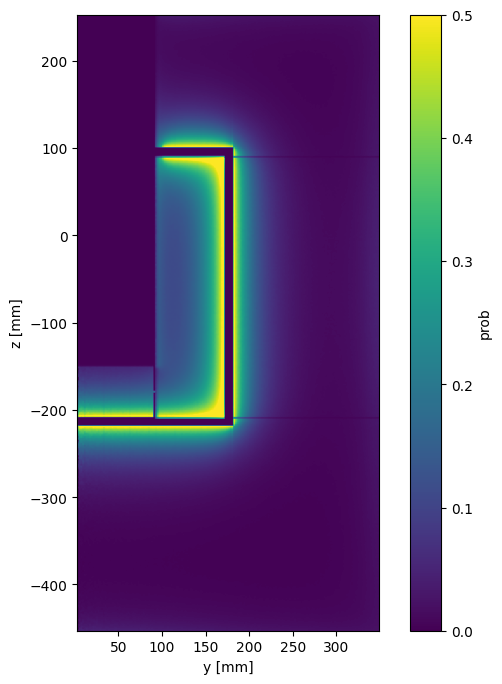

In [13]:
plt.figure(figsize = (8,8))
plot_map(opmap_df, "y", "z")

# To Do....
# write code to fix visualization

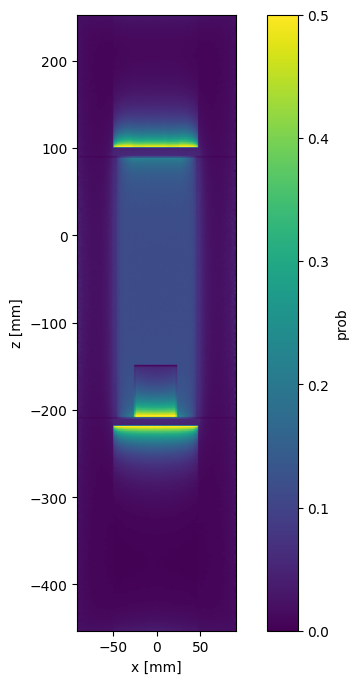

In [14]:
plt.figure(figsize = (8,8))
plot_map(opmap_df, "x", "z")

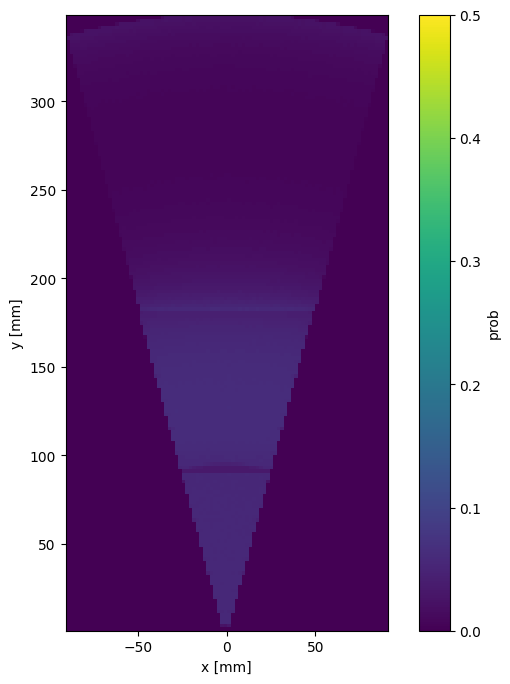

In [55]:
plt.figure(figsize = (8,8))
plot_map(opmap_df, "x", "y")

## 1D distribution along axis

### outer maps discontinuity check along z directions### 1D distribution along axis 

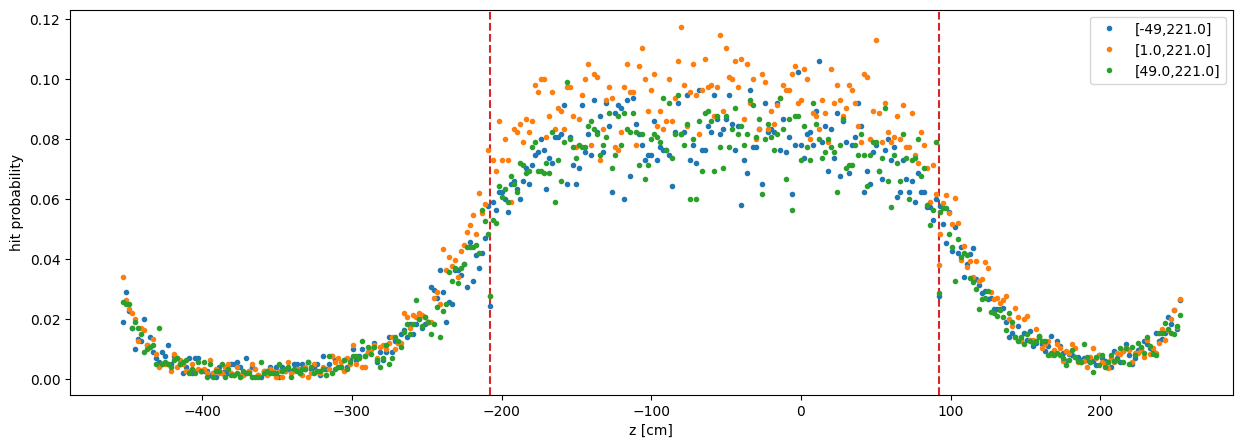

In [16]:
x_list = [-49, 1., 49.0]
y_list = [221.0]

plt.figure(figsize = (15,5))

for x in x_list:
    for y in y_list:

        selection = (opmap_df.x == x) & (opmap_df.y == y)
        selected_data = opmap_df[selection]

        plt.plot(selected_data.z, selected_data.prob, linestyle = "", marker = ".", label = f"[{x},{y}]")

plt.legend()
plt.xlabel("z [cm]")
plt.ylabel("hit probability")

plt.axvline(-208, color = "tab:red", linestyle = "--", zorder = -1)
plt.axvline(92, color = "tab:red", linestyle = "--", zorder = -1)


### outer maps discontinuity checkz along y direction (currently wrong and not working, y range should start at 0,  fix it!!!)

[183.0, 185.0, 187.0, 189.0, 191.0, 193.0, 195.0, 197.0, 199.0, 201.0, 203.0, 205.0, 207.0, 209.0, 211.0, 213.0, 215.0, 217.0, 219.0, 221.0, 223.0, 225.0, 227.0, 229.0, 231.0, 233.0, 235.0, 237.0, 239.0, 241.0, 243.0, 245.0, 247.0, 249.0, 251.0, 253.0, 255.0, 257.0, 259.0, 261.0, 263.0, 265.0, 267.0, 269.0, 271.0, 273.0, 275.0, 277.0, 279.0, 281.0, 283.0, 285.0, 287.0, 289.0, 291.0, 293.0, 295.0, 297.0, 299.0, 301.0, 303.0, 305.0, 307.0, 309.0, 311.0, 313.0, 315.0, 317.0, 319.0, 321.0, 323.0, 325.0, 327.0, 329.0, 331.0, 333.0, 335.0, 337.0, 339.0, 341.0, 343.0, 345.0, 347.0, 349.0]


Text(0, 0.5, 'hit probability')

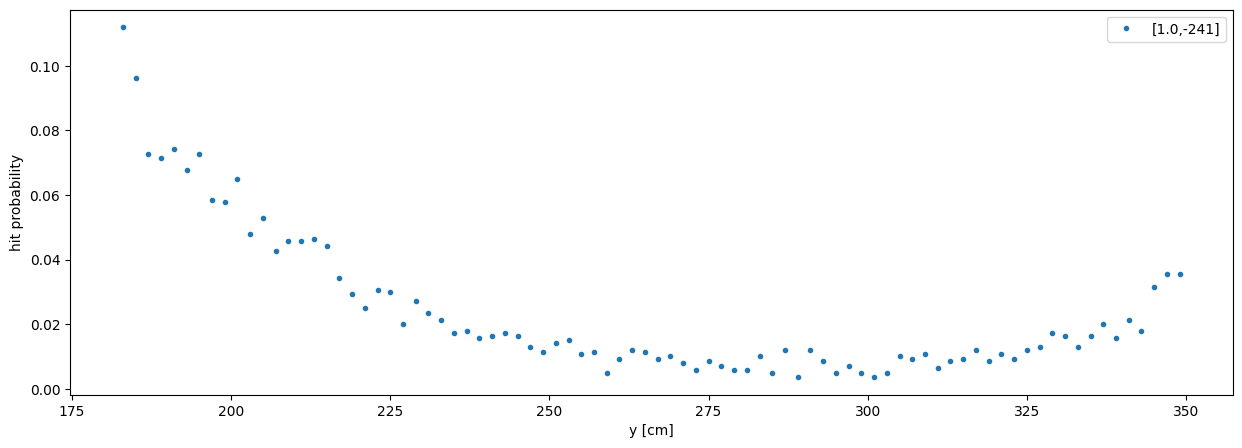

In [17]:
#x_list = [-49, 1., 49.0]
x_list = [1.]
#z_list = [121, -191, -251]
z_list = [-241]

plt.figure(figsize = (15,5))

for x in x_list:
    for z in z_list:

        selection = (opmap_df.x == x) & (opmap_df.z == z)
        selected_data = opmap_df[selection]
        
        print(sorted(selected_data.y.unique()))

        plt.plot(selected_data.y, selected_data.prob, linestyle = "", marker = ".", label = f"[{x},{z}]")

plt.legend()
plt.xlabel("y [cm]")
plt.ylabel("hit probability")
#plt.axvline(182, color = "tab:red", linestyle = "--", zorder = -1)
#plt.axvline(92, color = "tab:red", linestyle = "--", zorder = -1)


## Old stuff, randomly dumped here but can be ignored (or open with caution!!)

In [ ]:
# file to import for the optical map
file = "/lfs/l1/legend/users/cbarton/simulations/campaigns/opticalmap/4-innermap-wlsr-Feb2024/output/map.root"

# import the otpical map into a pandas dataframe using uproot

inner_opmap_df = pd.DataFrame()
tf = uproot.open(file)["opmap"]
inner_opmap_df["index"]  = tf["index"].array(library="np")
#inner_opmap_df["xprime"] = tf["Xprime"].array(library="np")
#inner_opmap_df["yprime"] = tf["Yprime"].array(library="np")
#inner_opmap_df["zprime"] = tf["Zprime"].array(library="np")
inner_opmap_df["prob"]   = tf["prob"].array(library="np")

# inner map size
#inn_xmin = -54
inn_xmin = -52
#inn_ymin = 92
inn_ymin = 90
inn_zmin = -151

inn_xbins = 54
inn_ybins = 55
inn_zbins = 151

# compute x,y,z coordinate from index and add to dataframe

inner_opmap_df["x"] = compute_x(inner_opmap_df.index, inn_xbins, inn_ybins, inn_xmin)
inner_opmap_df["y"] = compute_y(inner_opmap_df.index, inn_xbins, inn_ybins, inn_ymin)
inner_opmap_df["z"] = compute_z(inner_opmap_df.index, inn_xbins, inn_ybins, inn_zmin)

In [ ]:
# file to import for the optical map
file = "/lfs/l1/legend/users/cbarton/simulations/campaigns/opticalmap/5-outermap-7mdiam-wlsr-Apr2024/output/map.root"

outer_opmap_df = pd.DataFrame()
tf = uproot.open(file)["opmap"]
outer_opmap_df["index"]  = tf["index"].array(library="np")
#outer_opmap_df["xprime"] = tf["Xprime"].array(library="np")
#outer_opmap_df["yprime"] = tf["Yprime"].array(library="np")
#outer_opmap_df["zprime"] = tf["Zprime"].array(library="np")
outer_opmap_df["prob"]   = tf["prob"].array(library="np")

# inner map size 
#out_xmin = -92
out_xmin = -90
#out_ymin = 210
out_ymin = 208
out_zmin = -151

out_xbins = 92
out_ybins = 70
out_zbins = 151

# compute x,y,z coordinate from index and add to dataframe

outer_opmap_df["x"] = compute_x(outer_opmap_df.index, out_xbins, out_ybins, out_xmin)
outer_opmap_df["y"] = compute_y(outer_opmap_df.index, out_xbins, out_ybins, out_ymin)
outer_opmap_df["z"] = compute_z(outer_opmap_df.index, out_xbins, out_ybins, out_zmin)

In [ ]:
shift = 0

x_all = np.arange(-91 ,   93 , 2)
y_all = np.arange(99 ,   351, 2)
z_all = np.arange(-150,   152, 2)

In [ ]:
vmax = 0.4
cmap = sns.color_palette("viridis", 256)

inner_df = inner_opmap_df.groupby(["y","z"]).prob.mean().reset_index()
outer_df = outer_opmap_df.groupby(["y","z"]).prob.mean().reset_index()
out_inn_df = pd.concat([inner_df, outer_df])

all_combinations = set(itertools.product(y_all, z_all))
all_df = pd.DataFrame(all_combinations, columns=['y', 'z'])
all_df['prob'] = 0
all_df = all_df.sort_values(["y", "z"])

df = all_df
heatmap_data = df.pivot(index = "z", columns = "y", values = "prob")
sns.heatmap(heatmap_data, cmap = cmap, vmax = vmax, cbar_kws={"extend": "max"})

df = out_inn_df.merge(all_df, how = "outer", on = ["y", "z"])
heatmap_data = df.pivot(index = "z", columns = "y", values = "prob_x")
sns.heatmap(heatmap_data, cmap = cmap, vmax = vmax, cbar = False)
plt.axis('scaled')
#plt.show()
#plt.savefig("inner_map_yz.pdf")
#plt.savefig("inner_map_yz.png")

In [ ]:
vmax = 0.4
cmap = sns.color_palette("viridis", 256)

inner_df = inner_opmap_df.groupby(["x","z"]).prob.mean().reset_index()
outer_df = outer_opmap_df.groupby(["x","z"]).prob.mean().reset_index()
out_inn_df = pd.concat([inner_df, outer_df])

all_combinations = set(itertools.product(x_all, z_all))
all_df = pd.DataFrame(all_combinations, columns=['x', 'z'])
all_df['prob'] = 0
all_df = all_df.sort_values(["x", "z"])

df = all_df
heatmap_data = df.pivot(index = "z", columns = "x", values = "prob")
sns.heatmap(heatmap_data, cmap = cmap, vmax = vmax, cbar_kws={"extend": "max"})

df = out_inn_df.merge(all_df, how = "outer", on = ["x", "z"])
heatmap_data = df.pivot(index = "x", columns = "z", values = "prob_x")
#sns.heatmap(heatmap_data, cmap = cmap, vmax = vmax, cbar = False)
plt.axis('scaled')
plt.show()
#plt.savefig("inner_map_yz.pdf")
#plt.savefig("inner_map_yz.png")

In [ ]:

#kBird = LinearSegmentedColormap.from_list("custom_cmap", colors, 6)
vmax = 0.4
cmap = sns.color_palette("viridis", 256)


# compute mean value of optical map along z direction and concatenate inner and outer maps
inner_df = inner_opmap_df.groupby(["x","y"]).prob.mean().reset_index()
outer_df = outer_opmap_df.groupby(["x","y"]).prob.mean().reset_index()
out_inn_df = pd.concat([inner_df, outer_df])


all_combinations = set(itertools.product(x_all, y_all))
all_df = pd.DataFrame(all_combinations, columns=['x', 'y'])
all_df['prob'] = 0
all_df = all_df.sort_values(["x", "y"])

df = all_df
heatmap_data = df.pivot(index = "y", columns = "x", values = "prob")
sns.heatmap(heatmap_data, cmap = cmap, vmax = vmax, cbar_kws={"extend": "max"})
#
df = out_inn_df.merge(all_df, how = "outer", on = ["x", "y"])
heatmap_data = df.pivot(index = "y", columns = "x", values = "prob_x")
ax = sns.heatmap(heatmap_data, cmap = cmap, vmax = vmax, cbar = False)
plt.axis('scaled')

# Definire il centro e il raggio della circonferenza
center = (200, 0)
radius = 3

# Aggiungere la circonferenza
circle = plt.Circle(center, radius, color='white', fill=False, linewidth=2)

# Aggiungere la circonferenza agli assi
ax.add_patch(circle)


#plt.savefig("inner_map_xy.pdf")
#plt.savefig("inner_map_xy.png")

In [58]:
# compute mean value of optical map along z direction and concatenate inner and outer maps
inner_df = inner_opmap_df.groupby(["x","y"]).prob.mean().reset_index()
outer_df = outer_opmap_df.groupby(["x","y"]).prob.mean().reset_index()

inner_df = inner_df.pivot(index = "y", columns = "x", values = "prob")
outer_df = outer_df.pivot(index = "y", columns = "x", values = "prob")

NameError: name 'inner_opmap_df' is not defined

In [56]:
def draw_dodecagon_alternating(num_lati, lunghezza_lato):
    
    # Calcoliamo le coordinate dei vertici del dodecagono
    angoli = np.linspace(0, 2*np.pi, num_lati, endpoint=False)
    x = lunghezza_lato * np.cos(angoli)
    y = lunghezza_lato * np.sin(angoli)
    
    
    # this part is needed to have some distance 
    # between the light guides so that they don't overlap
    angolo = 0
    x = []
    y = []
    
    for i in range(24):
        if i % 2 != 0:
            angolo += 29/180*np.pi
            x.append(lunghezza_lato * np.cos(angolo))
            y.append(lunghezza_lato * np.sin(angolo))
        else:
            angolo += 1/180*np.pi
            x.append(lunghezza_lato * np.cos(angolo))
            y.append(lunghezza_lato * np.sin(angolo))
            

    # let's rotate the panels' position so that the panel number matches the optical maps
    angolo_rotazione = -np.pi/2 - np.pi / 12.5
    
    rotazione = np.array([[np.cos(angolo_rotazione), -np.sin(angolo_rotazione)],
                          [np.sin(angolo_rotazione), np.cos(angolo_rotazione)]])
    vertici = np.column_stack((x, y))
    vertici_ruotati = np.dot(vertici, rotazione)

    # Uniamo il primo e l'ultimo vertice per chiudere il dodecagono dopo la rotazione
    vertici_ruotati = np.vstack((vertici_ruotati, vertici_ruotati[0]))

    # Disegniamo il dodecagono con i lati colorati in base ai valori e alla palette
    for i in range(num_lati):
        if i % 2 == 0:
            #fig, ax = plt.subplots(figsize=(5, 4))
            colore = "grey"
            
            #print(valori.index)
            shift = 0
            ax.plot([vertici_ruotati[i, 0]+shift, vertici_ruotati[i+1, 0]+shift], [vertici_ruotati[i, 1], vertici_ruotati[i+1, 1]], color=colore, linewidth=6)

NameError: name 'inner_df' is not defined

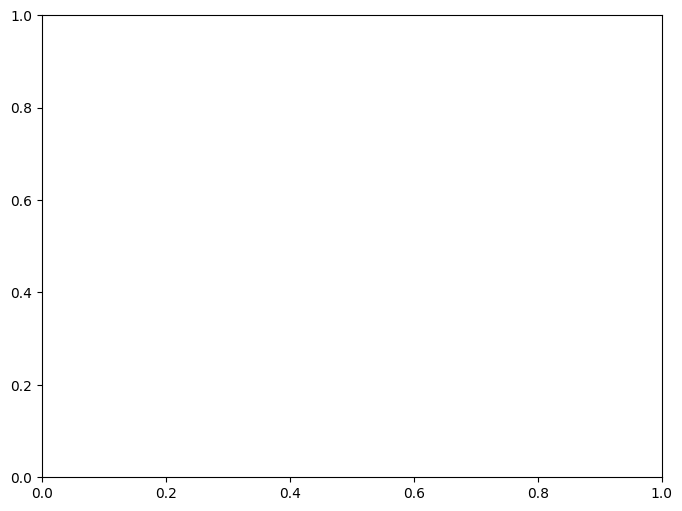

In [57]:
# Creare una figura con assi sovrapposti
fig, ax = plt.subplots(figsize=(8, 6))

cmap = "viridis"

# Heatmap 1
ax1 = ax.imshow(inner_df.values, cmap=cmap, extent=[inn_xmin, -inn_xmin, inn_ymin, inn_ymin + inn_ybins*2], origin='lower', vmin=0, vmax=vmax)

# Heatmap 2
ax2 = ax.imshow(outer_df.values, cmap=cmap, extent=[out_xmin, -out_xmin, out_ymin, out_ymin + out_ybins*2], origin='lower', vmin=0, vmax=vmax)

# Aggiungere una barra dei colori
cbar = plt.colorbar(ax1, ax=ax, orientation='vertical', extend = "max")
cbar.ax.set_ylabel('probability')


# Definire il centro e il raggio della circonferenza
center = (0, 0)
radius = 95
RT = plt.Circle(center, 94, color='grey', fill=False, linewidth=2)
cryo = plt.Circle(center, 351, color='grey', fill=False, linewidth=2)

# Aggiungere la circonferenza agli assi
ax.add_patch(RT)
ax.add_patch(cryo)

cmap = mpl.colormaps[cmap]
color_at_zero = cmap(0.0)
ax.set_facecolor(color_at_zero)

x = np.linspace(-350, 350)

theta = np.linspace(0, 2*np.pi, 12)

angles = np.tan(theta)

#for m in [3.6]:
    #plt.plot(x, m*x, color = "tab:red")
    #plt.plot(x, -m*x, color = "tab:red")
    
draw_dodecagon_alternating(24, 211)

ax.set_xlim([-220,220])
ax.set_ylim([0, 350])

ax.set_xlabel("x [cm]")
ax.set_ylabel("y [cm]")

#plt.show()
plt.savefig("newmap_xy.pdf")
plt.savefig("newmap_xy.png")

In [ ]:
# compute mean value of optical map along z direction and concatenate inner and outer maps
inner_df = inner_opmap_df.groupby(["y", "z"]).prob.mean().reset_index()
outer_df = outer_opmap_df.groupby(["y", "z"]).prob.mean().reset_index()

inner_df = inner_df.pivot(index = "z", columns = "y", values = "prob")
outer_df = outer_df.pivot(index = "z", columns = "y", values = "prob")

In [ ]:
# Creare una figura con assi sovrapposti
fig, ax = plt.subplots(figsize=(8, 6))

cmap = "viridis"

vmax = 0.4

# Heatmap 1
ax1 = ax.imshow(inner_df.values, cmap=cmap, extent=[inn_ymin, inn_ymin + inn_ybins*2, inn_zmin, inn_zmin + inn_zbins*2], origin='lower', vmin=0, vmax=vmax)

print(out_ymin)

# Heatmap 2
ax2 = ax.imshow(outer_df.values, cmap=cmap, extent=[out_ymin, out_ymin + out_ybins*2, out_zmin, out_zmin + out_zbins*2], origin='lower', vmin=0, vmax=vmax)

plt.xlim([0,355])
plt.ylim([-250,250])


cmap = mpl.colormaps[cmap]
color_at_zero = cmap(0.0)
ax.set_facecolor(color_at_zero)

# Aggiungere una barra dei colori
cbar = plt.colorbar(ax1, ax=ax, orientation='vertical', extend = "max")
cbar.ax.set_ylabel('probability')

mod_color = "grey"

ax.plot([204, 204],[-150, 150], linewidth = 6, color = mod_color)
ax.plot([95, 204],[150, 150], linewidth = 6, color = mod_color)
ax.plot([0, 204],[-150, -150], linewidth = 6, color = mod_color)

ax.plot([350, 350],[-250, 250], linewidth = 3, color = mod_color)

ax.plot([0, 0],[0, 250], linewidth = 125, color = "red")



In [ ]:
hist_range = [0, 1]
bin_width = 0.01
nbins = int(hist_range[1]/bin_width)

plt.figure(figsize = (8,6))
plt.hist(opmap_df[opmap_df.prob > 0].prob, histtype = "step", range = hist_range, bins = nbins)
plt.xlabel("probability")
#plt.yscale("log")
plt.show()

In [ ]:
hist_range = [0, 0.8]
bin_width = 0.005
nbins = int(hist_range[1]/bin_width)

plt.figure(figsize = (8,6))
plt.hist(opmap_df.explode("xprime").xprime, histtype = "step", range = hist_range, bins = nbins)
plt.show()

In [ ]:
for i in tqdm(range(2100)[:10]):
    index = 168000 + i
    plt.figure(figsize = (8,6))
    plt.plot(opmap_df.loc[index].x, opmap_df.loc[index].y, marker = "o", color = "red")
    plt.hist2d(opmap_df.loc[index].xprime, opmap_df.loc[index].yprime, cmap = "inferno", bins = [100, 100], range = [[-100, 100], [100, 300]], vmax = 10)
    plt.colorbar()
    plt.show()
    plt.savefig(f"plots-for-animation/map_index_{index}.png")
    plt.close()

In [ ]:
n = 200
for i in tqdm(np.linspace(0, xbins*ybins * (n-1), n)):
    index = i
    plt.figure(figsize = (8,6))
    plt.plot(opmap_df.loc[index].y, opmap_df.loc[index].z, marker = "o", color = "red")
    plt.hist2d(opmap_df.loc[index].yprime, opmap_df.loc[index].zprime, cmap = "inferno", bins = [100, 100], range = [[0, 350], [-300, 300]], vmax = 10)
    plt.colorbar()
#    plt.show()
    plt.savefig(f"/lfs/l1/legend/users/morella/legend1k_simulation/argon_energy_deposit/plots-for-animation/innermap_zy_{index}.png")
    plt.close()

In [ ]:
n = 100000
for i in tqdm(np.arange(0, n, xbins*ybins)):
    index = i
    plt.figure(figsize = (8,6))
    plt.plot(opmap_df.iloc[index].y, opmap_df.iloc[index].z, marker = "o", color = "red")
    plt.hist2d(opmap_df.iloc[index].yprime, opmap_df.iloc[index].zprime, cmap = "inferno", bins = [100, 100], range = [[0, 350], [-300, 300]], vmax = 10)
    plt.colorbar()
#    plt.show()
    plt.savefig(f"/lfs/l1/legend/users/morella/legend1k_simulation/argon_energy_deposit/plots-for-animation/innermap_zy_{index}.png")
    plt.close()